# Baseline Code

This code introduces a two-step training for the N-HPatches problem. In N-HPatches problem, we aim to generate a patch descriptor that is able to perform successfully tasks such as matching, retrieval or verification. 

Contrary to classical HPatches dataset, in N-HPatches, images contain random non-smooth perturbations produced by a synthetic noise. This noise could be critical when training the descriptor, therefore, we introduce a denoising model that could help us to deal with those perturbations. Denoising models have been already introduced in the course [tutorials](https://github.com/MatchLab-Imperial/deep-learning-course) and lectures, their objective is to generate a clean/denoised version of the input image.  We will refer in this code to the images with noise as `noisy`, to the images after applying the denoise model as `denoised` and the original patches from HPatches (so no extra noise added) which are used as ground-truth for the denoising step as `clean`. 


Thus, we aim to minimize the noise in images before the second step, which is computing a feature vector, also called descriptor. Those descriptions must be a powerful representation of the input patches. The idea behind is that if two descriptors belong two similar patches, they should be close to each other, i.e. have a low Euclidean distance. See figure below:

![](https://i.ibb.co/4tvm3Vh/descriptorspace.png)

This baseline code gives a method you can use to compare to whatever another approach you develop.  There are several other approaches you can test to see if there is any improvement, e.g. train the descriptor directly with noisy patches, without the denoising model. However, this code provides some guidance about how to implement the different blocks, how to stack them if desired, how to read the data and how to evaluate the method.

The values given can be improved without changing the core method, only by tuning correctly the hyperparameters or giving it more training time, among others.

As a first step of the project, you should get familiar with the problem and the provided code, so you can develop more complex and robust algorithms afterward. 

## Safety Check

As Google Colab is an external platform, we cannot guarantee that everytime you connect to a remote server, you will have the same amount of RAM or video RAM. For that reason, we will first check the amount of memory we have in the notebook. RAM should be around 12.9 GB, which is enough to load the datasets in memory. Also, usually, we have available 11.4 GB of GPU memory, which is more than enough to run this code. However, some users reported having only 500 MB of GPU memory. If you have that amount, restart the environment to see if you get the corresponding 11.4 GB.

In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

RAM Free: 29.3 GB  | Proc size: 50.7 MB
GPU RAM Free: 10874MB | Used: 390MB | Util   3% | Total 11264MB


## Downloading Functions and Data

The first step is to clone the GitHub repository of the course, which contains already implemented functions. You can use your own function and import them here doing the same. In addition, we are going to download and extract the N-HPatches data. 

As a note, in colab, we can run terminal commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we will use to move through directories (`cd` command). It takes around 5 minutes to download and unzip the dataset. 


In [ ]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

In [3]:
# Change directory
%cd keras_triplet_descriptor    


C:\Users\User\Downloads\keras_triplet_descriptor


In [ ]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


In [ ]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [4]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [5]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [6]:
hpatches_dir = './hpatches'
splits_path = 'splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   

In [ ]:
seqs

In [7]:
seqs_train = list(filter(lambda x: x.split('\\')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('\\')[-1] in split['test'], seqs)) 

In [ ]:
len(seqs)

In [ ]:
len(seqs_train)

In [ ]:
len(seqs_test)

## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [8]:
def get_denoise_model(shape, do):
  
    inputs = Input(shape)
    
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(inputs)))
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(pool1)))
    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(pool2)))
    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(pool3)))
    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation = 'relu', padding='same')(pool4)))
    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation = 'relu', padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(up6)))
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(up7)))
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(up8)))
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(up9)))
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(conv9)))

    conv10 = Dropout(0)(Conv2D(1, (1, 1))(conv9))

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


def get_descriptor_model(shape):
  
    '''Architecture copies HardNet architecture'''

    init_weights = keras.initializers.he_normal()

    descriptor_model = Sequential()
    descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))
    descriptor_model.add(Dropout(0.3))

    descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))

    # Final descriptor reshape
    descriptor_model.add(Reshape((128,)))

    return descriptor_model
  

def triplet_loss(x):
  
    output_dim = 128
    a, p, n = x
    _alpha = 1.0
    positive_distance = K.mean(K.square(a - p), axis=-1)
    negative_distance = K.mean(K.square(a - n), axis=-1)

    return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [9]:
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 5), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
#denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
#denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


In [10]:
shape = (32, 32, 1)
denoise_model_adam_do = get_denoise_model(shape, 0)
denoise_model_adam_do1 = get_denoise_model(shape, 0.1)
denoise_model_adam_do2 = get_denoise_model(shape, 0.2)
denoise_model_adam_do3 = get_denoise_model(shape, 0.3)
denoise_model_adam_do4 = get_denoise_model(shape, 0.4)
denoise_model_adam_do5 = get_denoise_model(shape, 0.5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [11]:
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)



denoise_model_adam_do.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_adam_do1.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_adam_do2.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_adam_do3.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_adam_do4.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_adam_do5.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])

#epochs = 1
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
#for e in range(epochs):
denoise_history_adam_do = denoise_model_adam_do.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adam_do1 = denoise_model_adam_do1.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adam_do2 = denoise_model_adam_do2.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adam_do3 = denoise_model_adam_do3.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adam_do4 = denoise_model_adam_do4.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adam_do5 = denoise_model_adam_do5.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

### Saves optimizer and weights


### Uploads files to external hosting
#!curl -F "file=@denoise.h5" https://file.io


Instructions for updating:
Use tf.cast instead.
Epoch 1/5


 255/1816 [===>..........................] - ETA: 5:13:41 - loss: 114.0172 - mean_absolute_error: 114.01 - ETA: 2:37:40 - loss: 115.4811 - mean_absolute_error: 115.48 - ETA: 1:45:35 - loss: 112.4297 - mean_absolute_error: 112.42 - ETA: 1:03:48 - loss: 111.5259 - mean_absolute_error: 111.52 - ETA: 45:53 - loss: 112.9696 - mean_absolute_error: 112.9696 - ETA: 35:55 - loss: 110.5769 - mean_absolute_error: 110.57 - ETA: 29:35 - loss: 108.9893 - mean_absolute_error: 108.98 - ETA: 25:12 - loss: 107.2647 - mean_absolute_error: 107.26 - ETA: 23:29 - loss: 106.1075 - mean_absolute_error: 106.10 - ETA: 20:42 - loss: 103.8316 - mean_absolute_error: 103.83 - ETA: 18:31 - loss: 101.8207 - mean_absolute_error: 101.82 - ETA: 16:46 - loss: 99.8632 - mean_absolute_error: 99.8632 - ETA: 16:02 - loss: 97.9037 - mean_absolute_error: 97.90 - ETA: 14:44 - loss: 94.2152 - mean_absolute_error: 94.21 - ETA: 14:11 - loss: 92.7692 - mean_absolute_error: 92.76 - ETA: 13:11 - loss: 88.8731 - mean_absolute_error: 8

 506/1816 [=======>......................] - ETA: 2:11 - loss: 21.4162 - mean_absolute_error: 21.416 - ETA: 2:10 - loss: 21.3054 - mean_absolute_error: 21.305 - ETA: 2:09 - loss: 21.2015 - mean_absolute_error: 21.201 - ETA: 2:09 - loss: 21.1495 - mean_absolute_error: 21.149 - ETA: 2:08 - loss: 21.0456 - mean_absolute_error: 21.045 - ETA: 2:08 - loss: 20.9429 - mean_absolute_error: 20.942 - ETA: 2:07 - loss: 20.8481 - mean_absolute_error: 20.848 - ETA: 2:06 - loss: 20.7487 - mean_absolute_error: 20.748 - ETA: 2:06 - loss: 20.6524 - mean_absolute_error: 20.652 - ETA: 2:05 - loss: 20.5557 - mean_absolute_error: 20.555 - ETA: 2:05 - loss: 20.4637 - mean_absolute_error: 20.463 - ETA: 2:04 - loss: 20.3766 - mean_absolute_error: 20.376 - ETA: 2:03 - loss: 20.2844 - mean_absolute_error: 20.284 - ETA: 2:03 - loss: 20.1971 - mean_absolute_error: 20.197 - ETA: 2:03 - loss: 20.1525 - mean_absolute_error: 20.152 - ETA: 2:02 - loss: 20.0694 - mean_absolute_error: 20.069 - ETA: 2:01 - loss: 19.9847 -

 735/1816 [===========>..................] - ETA: 1:24 - loss: 14.4985 - mean_absolute_error: 14.498 - ETA: 1:24 - loss: 14.4834 - mean_absolute_error: 14.483 - ETA: 1:23 - loss: 14.4533 - mean_absolute_error: 14.453 - ETA: 1:23 - loss: 14.4400 - mean_absolute_error: 14.440 - ETA: 1:23 - loss: 14.4099 - mean_absolute_error: 14.409 - ETA: 1:23 - loss: 14.3807 - mean_absolute_error: 14.380 - ETA: 1:23 - loss: 14.3518 - mean_absolute_error: 14.351 - ETA: 1:22 - loss: 14.3226 - mean_absolute_error: 14.322 - ETA: 1:22 - loss: 14.3083 - mean_absolute_error: 14.308 - ETA: 1:22 - loss: 14.2932 - mean_absolute_error: 14.293 - ETA: 1:22 - loss: 14.2661 - mean_absolute_error: 14.266 - ETA: 1:22 - loss: 14.2528 - mean_absolute_error: 14.252 - ETA: 1:22 - loss: 14.2390 - mean_absolute_error: 14.239 - ETA: 1:22 - loss: 14.2252 - mean_absolute_error: 14.225 - ETA: 1:22 - loss: 14.2105 - mean_absolute_error: 14.210 - ETA: 1:22 - loss: 14.1979 - mean_absolute_error: 14.197 - ETA: 1:21 - loss: 14.1694 -

 991/1816 [===============>..............] - ETA: 1:03 - loss: 12.2050 - mean_absolute_error: 12.205 - ETA: 1:03 - loss: 12.1895 - mean_absolute_error: 12.189 - ETA: 1:02 - loss: 12.1820 - mean_absolute_error: 12.182 - ETA: 1:02 - loss: 12.1674 - mean_absolute_error: 12.167 - ETA: 1:02 - loss: 12.1611 - mean_absolute_error: 12.161 - ETA: 1:02 - loss: 12.1547 - mean_absolute_error: 12.154 - ETA: 1:02 - loss: 12.1407 - mean_absolute_error: 12.140 - ETA: 1:02 - loss: 12.1340 - mean_absolute_error: 12.134 - ETA: 1:02 - loss: 12.1195 - mean_absolute_error: 12.119 - ETA: 1:02 - loss: 12.1067 - mean_absolute_error: 12.106 - ETA: 1:01 - loss: 12.0942 - mean_absolute_error: 12.094 - ETA: 1:01 - loss: 12.0820 - mean_absolute_error: 12.082 - ETA: 1:01 - loss: 12.0693 - mean_absolute_error: 12.069 - ETA: 1:01 - loss: 12.0560 - mean_absolute_error: 12.056 - ETA: 1:01 - loss: 12.0490 - mean_absolute_error: 12.049 - ETA: 1:01 - loss: 12.0421 - mean_absolute_error: 12.042 - ETA: 1:01 - loss: 12.0282 -

1245/1816 [===================>..........] - ETA: 44s - loss: 10.8286 - mean_absolute_error: 10.82 - ETA: 44s - loss: 10.8203 - mean_absolute_error: 10.82 - ETA: 44s - loss: 10.8121 - mean_absolute_error: 10.81 - ETA: 44s - loss: 10.8042 - mean_absolute_error: 10.80 - ETA: 44s - loss: 10.7962 - mean_absolute_error: 10.79 - ETA: 44s - loss: 10.7886 - mean_absolute_error: 10.78 - ETA: 44s - loss: 10.7812 - mean_absolute_error: 10.78 - ETA: 43s - loss: 10.7736 - mean_absolute_error: 10.77 - ETA: 43s - loss: 10.7661 - mean_absolute_error: 10.76 - ETA: 43s - loss: 10.7584 - mean_absolute_error: 10.75 - ETA: 43s - loss: 10.7505 - mean_absolute_error: 10.75 - ETA: 43s - loss: 10.7437 - mean_absolute_error: 10.74 - ETA: 43s - loss: 10.7356 - mean_absolute_error: 10.73 - ETA: 43s - loss: 10.7289 - mean_absolute_error: 10.72 - ETA: 43s - loss: 10.7215 - mean_absolute_error: 10.72 - ETA: 42s - loss: 10.7178 - mean_absolute_error: 10.71 - ETA: 42s - loss: 10.7097 - mean_absolute_error: 10.70 - ETA

1538/1816 [========================>.....] - ETA: 29s - loss: 9.9898 - mean_absolute_error: 9.98 - ETA: 29s - loss: 9.9846 - mean_absolute_error: 9.98 - ETA: 29s - loss: 9.9802 - mean_absolute_error: 9.98 - ETA: 29s - loss: 9.9746 - mean_absolute_error: 9.97 - ETA: 29s - loss: 9.9698 - mean_absolute_error: 9.96 - ETA: 29s - loss: 9.9651 - mean_absolute_error: 9.96 - ETA: 28s - loss: 9.9599 - mean_absolute_error: 9.95 - ETA: 28s - loss: 9.9537 - mean_absolute_error: 9.95 - ETA: 28s - loss: 9.9485 - mean_absolute_error: 9.94 - ETA: 28s - loss: 9.9435 - mean_absolute_error: 9.94 - ETA: 28s - loss: 9.9378 - mean_absolute_error: 9.93 - ETA: 28s - loss: 9.9328 - mean_absolute_error: 9.93 - ETA: 28s - loss: 9.9278 - mean_absolute_error: 9.92 - ETA: 28s - loss: 9.9229 - mean_absolute_error: 9.92 - ETA: 28s - loss: 9.9173 - mean_absolute_error: 9.91 - ETA: 27s - loss: 9.9119 - mean_absolute_error: 9.91 - ETA: 27s - loss: 9.9063 - mean_absolute_error: 9.90 - ETA: 27s - loss: 9.9016 - mean_absolu

1799/1816 [============================>.] - ETA: 13s - loss: 9.3377 - mean_absolute_error: 9.33 - ETA: 13s - loss: 9.3339 - mean_absolute_error: 9.33 - ETA: 13s - loss: 9.3305 - mean_absolute_error: 9.33 - ETA: 13s - loss: 9.3273 - mean_absolute_error: 9.32 - ETA: 13s - loss: 9.3255 - mean_absolute_error: 9.32 - ETA: 13s - loss: 9.3230 - mean_absolute_error: 9.32 - ETA: 13s - loss: 9.3212 - mean_absolute_error: 9.32 - ETA: 13s - loss: 9.3191 - mean_absolute_error: 9.31 - ETA: 13s - loss: 9.3170 - mean_absolute_error: 9.31 - ETA: 13s - loss: 9.3131 - mean_absolute_error: 9.31 - ETA: 12s - loss: 9.3097 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3058 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3038 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3028 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3008 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.2986 - mean_absolute_error: 9.29 - ETA: 12s - loss: 9.2970 - mean_absolute_error: 9.29 - ETA: 12s - loss: 9.2952 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 8.9170 - mean_absolute_error: 8.917 - ETA: 0s - loss: 8.9140 - mean_absolute_error: 8.914 - ETA: 0s - loss: 8.9115 - mean_absolute_error: 8.911 - ETA: 0s - loss: 8.9084 - mean_absolute_error: 8.908 - ETA: 0s - loss: 8.9055 - mean_absolute_error: 8.905 - ETA: 0s - loss: 8.9023 - mean_absolute_error: 8.902 - ETA: 0s - loss: 8.8988 - mean_absolute_error: 8.898 - ETA: 0s - loss: 8.8974 - mean_absolute_error: 8.897 - ETA: 0s - loss: 8.8943 - mean_absolute_error: 8.894 - 94s 52ms/step - loss: 8.8928 - mean_absolute_error: 8.8928 - val_loss: 5.6649 - val_mean_absolute_error: 5.6649
Epoch 2/5


 261/1816 [===>..........................] - ETA: 1:37 - loss: 6.3299 - mean_absolute_error: 6.329 - ETA: 1:55 - loss: 6.0743 - mean_absolute_error: 6.074 - ETA: 1:36 - loss: 6.2456 - mean_absolute_error: 6.245 - ETA: 1:28 - loss: 6.1954 - mean_absolute_error: 6.195 - ETA: 1:24 - loss: 6.2933 - mean_absolute_error: 6.293 - ETA: 1:22 - loss: 6.2729 - mean_absolute_error: 6.272 - ETA: 1:23 - loss: 6.2686 - mean_absolute_error: 6.268 - ETA: 1:24 - loss: 6.2954 - mean_absolute_error: 6.295 - ETA: 1:25 - loss: 6.2624 - mean_absolute_error: 6.262 - ETA: 1:24 - loss: 6.3162 - mean_absolute_error: 6.316 - ETA: 1:25 - loss: 6.3030 - mean_absolute_error: 6.303 - ETA: 1:24 - loss: 6.2783 - mean_absolute_error: 6.278 - ETA: 1:24 - loss: 6.2920 - mean_absolute_error: 6.292 - ETA: 1:23 - loss: 6.3116 - mean_absolute_error: 6.311 - ETA: 1:22 - loss: 6.3107 - mean_absolute_error: 6.310 - ETA: 1:21 - loss: 6.3269 - mean_absolute_error: 6.326 - ETA: 1:21 - loss: 6.3461 - mean_absolute_error: 6.346 - ETA

 534/1816 [=======>......................] - ETA: 1:07 - loss: 6.3222 - mean_absolute_error: 6.322 - ETA: 1:07 - loss: 6.3233 - mean_absolute_error: 6.323 - ETA: 1:07 - loss: 6.3221 - mean_absolute_error: 6.322 - ETA: 1:07 - loss: 6.3207 - mean_absolute_error: 6.320 - ETA: 1:07 - loss: 6.3241 - mean_absolute_error: 6.324 - ETA: 1:07 - loss: 6.3224 - mean_absolute_error: 6.322 - ETA: 1:07 - loss: 6.3216 - mean_absolute_error: 6.321 - ETA: 1:07 - loss: 6.3209 - mean_absolute_error: 6.320 - ETA: 1:07 - loss: 6.3232 - mean_absolute_error: 6.323 - ETA: 1:07 - loss: 6.3255 - mean_absolute_error: 6.325 - ETA: 1:07 - loss: 6.3249 - mean_absolute_error: 6.324 - ETA: 1:06 - loss: 6.3229 - mean_absolute_error: 6.322 - ETA: 1:06 - loss: 6.3192 - mean_absolute_error: 6.319 - ETA: 1:06 - loss: 6.3187 - mean_absolute_error: 6.318 - ETA: 1:06 - loss: 6.3167 - mean_absolute_error: 6.316 - ETA: 1:06 - loss: 6.3159 - mean_absolute_error: 6.315 - ETA: 1:06 - loss: 6.3174 - mean_absolute_error: 6.317 - ETA

 817/1816 [============>.................] - ETA: 55s - loss: 6.2960 - mean_absolute_error: 6.29 - ETA: 55s - loss: 6.2959 - mean_absolute_error: 6.29 - ETA: 55s - loss: 6.2958 - mean_absolute_error: 6.29 - ETA: 55s - loss: 6.2945 - mean_absolute_error: 6.29 - ETA: 55s - loss: 6.2934 - mean_absolute_error: 6.29 - ETA: 55s - loss: 6.2912 - mean_absolute_error: 6.29 - ETA: 55s - loss: 6.2895 - mean_absolute_error: 6.28 - ETA: 55s - loss: 6.2885 - mean_absolute_error: 6.28 - ETA: 55s - loss: 6.2867 - mean_absolute_error: 6.28 - ETA: 55s - loss: 6.2863 - mean_absolute_error: 6.28 - ETA: 55s - loss: 6.2887 - mean_absolute_error: 6.28 - ETA: 54s - loss: 6.2881 - mean_absolute_error: 6.28 - ETA: 54s - loss: 6.2871 - mean_absolute_error: 6.28 - ETA: 54s - loss: 6.2859 - mean_absolute_error: 6.28 - ETA: 54s - loss: 6.2873 - mean_absolute_error: 6.28 - ETA: 54s - loss: 6.2869 - mean_absolute_error: 6.28 - ETA: 54s - loss: 6.2866 - mean_absolute_error: 6.28 - ETA: 54s - loss: 6.2839 - mean_absolu

1080/1816 [================>.............] - ETA: 42s - loss: 6.2422 - mean_absolute_error: 6.24 - ETA: 42s - loss: 6.2408 - mean_absolute_error: 6.24 - ETA: 42s - loss: 6.2395 - mean_absolute_error: 6.23 - ETA: 42s - loss: 6.2384 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2385 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2374 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2370 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2378 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2382 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2379 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2375 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2371 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2367 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2358 - mean_absolute_error: 6.23 - ETA: 41s - loss: 6.2355 - mean_absolute_error: 6.23 - ETA: 40s - loss: 6.2341 - mean_absolute_error: 6.23 - ETA: 40s - loss: 6.2341 - mean_absolute_error: 6.23 - ETA: 40s - loss: 6.2346 - mean_absolu

1253/1816 [===================>..........] - ETA: 31s - loss: 6.2083 - mean_absolute_error: 6.20 - ETA: 31s - loss: 6.2085 - mean_absolute_error: 6.20 - ETA: 31s - loss: 6.2082 - mean_absolute_error: 6.20 - ETA: 31s - loss: 6.2085 - mean_absolute_error: 6.20 - ETA: 31s - loss: 6.2082 - mean_absolute_error: 6.20 - ETA: 31s - loss: 6.2086 - mean_absolute_error: 6.20 - ETA: 31s - loss: 6.2088 - mean_absolute_error: 6.20 - ETA: 31s - loss: 6.2087 - mean_absolute_error: 6.20 - ETA: 30s - loss: 6.2092 - mean_absolute_error: 6.20 - ETA: 30s - loss: 6.2108 - mean_absolute_error: 6.21 - ETA: 30s - loss: 6.2106 - mean_absolute_error: 6.21 - ETA: 30s - loss: 6.2106 - mean_absolute_error: 6.21 - ETA: 30s - loss: 6.2098 - mean_absolute_error: 6.20 - ETA: 30s - loss: 6.2100 - mean_absolute_error: 6.21 - ETA: 30s - loss: 6.2094 - mean_absolute_error: 6.20 - ETA: 30s - loss: 6.2095 - mean_absolute_error: 6.20 - ETA: 30s - loss: 6.2096 - mean_absolute_error: 6.20 - ETA: 30s - loss: 6.2096 - mean_absolu

1529/1816 [========================>.....] - ETA: 24s - loss: 6.2015 - mean_absolute_error: 6.20 - ETA: 24s - loss: 6.2011 - mean_absolute_error: 6.20 - ETA: 24s - loss: 6.2010 - mean_absolute_error: 6.20 - ETA: 24s - loss: 6.2013 - mean_absolute_error: 6.20 - ETA: 24s - loss: 6.2010 - mean_absolute_error: 6.20 - ETA: 24s - loss: 6.2006 - mean_absolute_error: 6.20 - ETA: 24s - loss: 6.2004 - mean_absolute_error: 6.20 - ETA: 24s - loss: 6.2005 - mean_absolute_error: 6.20 - ETA: 24s - loss: 6.2004 - mean_absolute_error: 6.20 - ETA: 24s - loss: 6.1997 - mean_absolute_error: 6.19 - ETA: 24s - loss: 6.2002 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2004 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.1999 - mean_absolute_error: 6.19 - ETA: 23s - loss: 6.2004 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2003 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2000 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.1998 - mean_absolute_error: 6.19 - ETA: 23s - loss: 6.1998 - mean_absolu

1807/1816 [============================>.] - ETA: 12s - loss: 6.1702 - mean_absolute_error: 6.17 - ETA: 12s - loss: 6.1700 - mean_absolute_error: 6.17 - ETA: 12s - loss: 6.1700 - mean_absolute_error: 6.17 - ETA: 12s - loss: 6.1700 - mean_absolute_error: 6.17 - ETA: 12s - loss: 6.1699 - mean_absolute_error: 6.16 - ETA: 12s - loss: 6.1694 - mean_absolute_error: 6.16 - ETA: 12s - loss: 6.1697 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1692 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1688 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1685 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1679 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1678 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1682 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1675 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1668 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1664 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1659 - mean_absolute_error: 6.16 - ETA: 11s - loss: 6.1660 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 6.1469 - mean_absolute_error: 6.146 - ETA: 0s - loss: 6.1468 - mean_absolute_error: 6.146 - ETA: 0s - loss: 6.1466 - mean_absolute_error: 6.146 - ETA: 0s - loss: 6.1470 - mean_absolute_error: 6.147 - 85s 47ms/step - loss: 6.1466 - mean_absolute_error: 6.1466 - val_loss: 5.5727 - val_mean_absolute_error: 5.5727
Epoch 3/5


 279/1816 [===>..........................] - ETA: 1:59 - loss: 5.7012 - mean_absolute_error: 5.701 - ETA: 1:51 - loss: 5.6846 - mean_absolute_error: 5.684 - ETA: 1:34 - loss: 5.7788 - mean_absolute_error: 5.778 - ETA: 1:28 - loss: 5.7458 - mean_absolute_error: 5.745 - ETA: 1:24 - loss: 5.8949 - mean_absolute_error: 5.894 - ETA: 1:21 - loss: 5.9566 - mean_absolute_error: 5.956 - ETA: 1:20 - loss: 5.9281 - mean_absolute_error: 5.928 - ETA: 1:19 - loss: 5.9345 - mean_absolute_error: 5.934 - ETA: 1:18 - loss: 5.8962 - mean_absolute_error: 5.896 - ETA: 1:17 - loss: 5.8778 - mean_absolute_error: 5.877 - ETA: 1:16 - loss: 5.8626 - mean_absolute_error: 5.862 - ETA: 1:16 - loss: 5.8548 - mean_absolute_error: 5.854 - ETA: 1:17 - loss: 5.8512 - mean_absolute_error: 5.851 - ETA: 1:16 - loss: 5.8709 - mean_absolute_error: 5.870 - ETA: 1:16 - loss: 5.8543 - mean_absolute_error: 5.854 - ETA: 1:16 - loss: 5.8850 - mean_absolute_error: 5.885 - ETA: 1:15 - loss: 5.8904 - mean_absolute_error: 5.890 - ETA

 579/1816 [========>.....................] - ETA: 1:03 - loss: 5.9722 - mean_absolute_error: 5.972 - ETA: 1:03 - loss: 5.9713 - mean_absolute_error: 5.971 - ETA: 1:03 - loss: 5.9714 - mean_absolute_error: 5.971 - ETA: 1:03 - loss: 5.9711 - mean_absolute_error: 5.971 - ETA: 1:02 - loss: 5.9656 - mean_absolute_error: 5.965 - ETA: 1:02 - loss: 5.9657 - mean_absolute_error: 5.965 - ETA: 1:02 - loss: 5.9652 - mean_absolute_error: 5.965 - ETA: 1:02 - loss: 5.9662 - mean_absolute_error: 5.966 - ETA: 1:02 - loss: 5.9663 - mean_absolute_error: 5.966 - ETA: 1:02 - loss: 5.9665 - mean_absolute_error: 5.966 - ETA: 1:02 - loss: 5.9670 - mean_absolute_error: 5.967 - ETA: 1:02 - loss: 5.9686 - mean_absolute_error: 5.968 - ETA: 1:02 - loss: 5.9675 - mean_absolute_error: 5.967 - ETA: 1:02 - loss: 5.9651 - mean_absolute_error: 5.965 - ETA: 1:01 - loss: 5.9651 - mean_absolute_error: 5.965 - ETA: 1:01 - loss: 5.9643 - mean_absolute_error: 5.964 - ETA: 1:01 - loss: 5.9604 - mean_absolute_error: 5.960 - ETA

 874/1816 [=============>................] - ETA: 49s - loss: 5.9429 - mean_absolute_error: 5.94 - ETA: 49s - loss: 5.9437 - mean_absolute_error: 5.94 - ETA: 49s - loss: 5.9437 - mean_absolute_error: 5.94 - ETA: 49s - loss: 5.9439 - mean_absolute_error: 5.94 - ETA: 49s - loss: 5.9444 - mean_absolute_error: 5.94 - ETA: 49s - loss: 5.9447 - mean_absolute_error: 5.94 - ETA: 49s - loss: 5.9441 - mean_absolute_error: 5.94 - ETA: 49s - loss: 5.9449 - mean_absolute_error: 5.94 - ETA: 49s - loss: 5.9449 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9445 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9445 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9439 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9444 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9458 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9459 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9456 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9458 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9471 - mean_absolu

1175/1816 [==================>...........] - ETA: 37s - loss: 5.9355 - mean_absolute_error: 5.93 - ETA: 37s - loss: 5.9340 - mean_absolute_error: 5.93 - ETA: 37s - loss: 5.9331 - mean_absolute_error: 5.93 - ETA: 37s - loss: 5.9335 - mean_absolute_error: 5.93 - ETA: 37s - loss: 5.9328 - mean_absolute_error: 5.93 - ETA: 37s - loss: 5.9322 - mean_absolute_error: 5.93 - ETA: 37s - loss: 5.9336 - mean_absolute_error: 5.93 - ETA: 37s - loss: 5.9334 - mean_absolute_error: 5.93 - ETA: 37s - loss: 5.9341 - mean_absolute_error: 5.93 - ETA: 37s - loss: 5.9340 - mean_absolute_error: 5.93 - ETA: 37s - loss: 5.9335 - mean_absolute_error: 5.93 - ETA: 36s - loss: 5.9341 - mean_absolute_error: 5.93 - ETA: 36s - loss: 5.9345 - mean_absolute_error: 5.93 - ETA: 36s - loss: 5.9346 - mean_absolute_error: 5.93 - ETA: 36s - loss: 5.9336 - mean_absolute_error: 5.93 - ETA: 36s - loss: 5.9331 - mean_absolute_error: 5.93 - ETA: 36s - loss: 5.9334 - mean_absolute_error: 5.93 - ETA: 36s - loss: 5.9341 - mean_absolu

1476/1816 [=======================>......] - ETA: 25s - loss: 5.9208 - mean_absolute_error: 5.92 - ETA: 25s - loss: 5.9213 - mean_absolute_error: 5.92 - ETA: 25s - loss: 5.9211 - mean_absolute_error: 5.92 - ETA: 25s - loss: 5.9208 - mean_absolute_error: 5.92 - ETA: 25s - loss: 5.9195 - mean_absolute_error: 5.91 - ETA: 25s - loss: 5.9199 - mean_absolute_error: 5.91 - ETA: 25s - loss: 5.9204 - mean_absolute_error: 5.92 - ETA: 24s - loss: 5.9200 - mean_absolute_error: 5.92 - ETA: 24s - loss: 5.9198 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9199 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9190 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9186 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9185 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9190 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9187 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9186 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9186 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9186 - mean_absolu

1777/1816 [============================>.] - ETA: 13s - loss: 5.9104 - mean_absolute_error: 5.91 - ETA: 13s - loss: 5.9106 - mean_absolute_error: 5.91 - ETA: 13s - loss: 5.9104 - mean_absolute_error: 5.91 - ETA: 13s - loss: 5.9106 - mean_absolute_error: 5.91 - ETA: 13s - loss: 5.9098 - mean_absolute_error: 5.90 - ETA: 13s - loss: 5.9094 - mean_absolute_error: 5.90 - ETA: 13s - loss: 5.9097 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9097 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9097 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9096 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9095 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9098 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9100 - mean_absolute_error: 5.91 - ETA: 12s - loss: 5.9099 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9094 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9092 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9089 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9085 - mean_absolu

1816/1816 [==============================] - ETA: 1s - loss: 5.8931 - mean_absolute_error: 5.893 - ETA: 1s - loss: 5.8924 - mean_absolute_error: 5.892 - ETA: 1s - loss: 5.8923 - mean_absolute_error: 5.892 - ETA: 1s - loss: 5.8919 - mean_absolute_error: 5.891 - ETA: 1s - loss: 5.8916 - mean_absolute_error: 5.891 - ETA: 1s - loss: 5.8914 - mean_absolute_error: 5.891 - ETA: 0s - loss: 5.8915 - mean_absolute_error: 5.891 - ETA: 0s - loss: 5.8913 - mean_absolute_error: 5.891 - ETA: 0s - loss: 5.8912 - mean_absolute_error: 5.891 - ETA: 0s - loss: 5.8910 - mean_absolute_error: 5.891 - ETA: 0s - loss: 5.8912 - mean_absolute_error: 5.891 - ETA: 0s - loss: 5.8912 - mean_absolute_error: 5.891 - ETA: 0s - loss: 5.8903 - mean_absolute_error: 5.890 - ETA: 0s - loss: 5.8903 - mean_absolute_error: 5.890 - ETA: 0s - loss: 5.8899 - mean_absolute_error: 5.889 - ETA: 0s - loss: 5.8898 - mean_absolute_error: 5.889 - ETA: 0s - loss: 5.8899 - mean_absolute_error: 5.889 - ETA: 0s - loss: 5.8902 - mean_absolut

 292/1816 [===>..........................] - ETA: 1:23 - loss: 5.6610 - mean_absolute_error: 5.661 - ETA: 1:41 - loss: 5.5861 - mean_absolute_error: 5.586 - ETA: 1:24 - loss: 5.6184 - mean_absolute_error: 5.618 - ETA: 1:18 - loss: 5.7208 - mean_absolute_error: 5.720 - ETA: 1:16 - loss: 5.8218 - mean_absolute_error: 5.821 - ETA: 1:14 - loss: 5.8324 - mean_absolute_error: 5.832 - ETA: 1:13 - loss: 5.8379 - mean_absolute_error: 5.837 - ETA: 1:12 - loss: 5.8197 - mean_absolute_error: 5.819 - ETA: 1:12 - loss: 5.8359 - mean_absolute_error: 5.835 - ETA: 1:11 - loss: 5.8308 - mean_absolute_error: 5.830 - ETA: 1:10 - loss: 5.8350 - mean_absolute_error: 5.835 - ETA: 1:10 - loss: 5.8373 - mean_absolute_error: 5.837 - ETA: 1:10 - loss: 5.8182 - mean_absolute_error: 5.818 - ETA: 1:10 - loss: 5.7898 - mean_absolute_error: 5.789 - ETA: 1:09 - loss: 5.8073 - mean_absolute_error: 5.807 - ETA: 1:09 - loss: 5.7900 - mean_absolute_error: 5.790 - ETA: 1:09 - loss: 5.7889 - mean_absolute_error: 5.788 - ETA

 593/1816 [========>.....................] - ETA: 57s - loss: 5.7902 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7903 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7903 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7919 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7924 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7941 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7936 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7929 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7915 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7914 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7903 - mean_absolute_error: 5.79 - ETA: 57s - loss: 5.7922 - mean_absolute_error: 5.79 - ETA: 56s - loss: 5.7919 - mean_absolute_error: 5.79 - ETA: 56s - loss: 5.7877 - mean_absolute_error: 5.78 - ETA: 56s - loss: 5.7866 - mean_absolute_error: 5.78 - ETA: 56s - loss: 5.7844 - mean_absolute_error: 5.78 - ETA: 56s - loss: 5.7843 - mean_absolute_error: 5.78 - ETA: 56s - loss: 5.7813 - mean_absolu

 894/1816 [=============>................] - ETA: 46s - loss: 5.7785 - mean_absolute_error: 5.77 - ETA: 46s - loss: 5.7785 - mean_absolute_error: 5.77 - ETA: 46s - loss: 5.7785 - mean_absolute_error: 5.77 - ETA: 46s - loss: 5.7784 - mean_absolute_error: 5.77 - ETA: 46s - loss: 5.7789 - mean_absolute_error: 5.77 - ETA: 46s - loss: 5.7787 - mean_absolute_error: 5.77 - ETA: 45s - loss: 5.7789 - mean_absolute_error: 5.77 - ETA: 45s - loss: 5.7794 - mean_absolute_error: 5.77 - ETA: 45s - loss: 5.7813 - mean_absolute_error: 5.78 - ETA: 45s - loss: 5.7814 - mean_absolute_error: 5.78 - ETA: 45s - loss: 5.7818 - mean_absolute_error: 5.78 - ETA: 45s - loss: 5.7817 - mean_absolute_error: 5.78 - ETA: 45s - loss: 5.7813 - mean_absolute_error: 5.78 - ETA: 45s - loss: 5.7808 - mean_absolute_error: 5.78 - ETA: 45s - loss: 5.7803 - mean_absolute_error: 5.78 - ETA: 45s - loss: 5.7800 - mean_absolute_error: 5.78 - ETA: 45s - loss: 5.7795 - mean_absolute_error: 5.77 - ETA: 45s - loss: 5.7789 - mean_absolu

1196/1816 [==================>...........] - ETA: 34s - loss: 5.7633 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7636 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7637 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7625 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7622 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7615 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7601 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7588 - mean_absolute_error: 5.75 - ETA: 34s - loss: 5.7585 - mean_absolute_error: 5.75 - ETA: 34s - loss: 5.7590 - mean_absolute_error: 5.75 - ETA: 34s - loss: 5.7591 - mean_absolute_error: 5.75 - ETA: 34s - loss: 5.7594 - mean_absolute_error: 5.75 - ETA: 34s - loss: 5.7588 - mean_absolute_error: 5.75 - ETA: 33s - loss: 5.7590 - mean_absolute_error: 5.75 - ETA: 33s - loss: 5.7591 - mean_absolute_error: 5.75 - ETA: 33s - loss: 5.7595 - mean_absolute_error: 5.75 - ETA: 33s - loss: 5.7598 - mean_absolute_error: 5.75 - ETA: 33s - loss: 5.7596 - mean_absolu

1495/1816 [=======================>......] - ETA: 23s - loss: 5.7516 - mean_absolute_error: 5.75 - ETA: 23s - loss: 5.7508 - mean_absolute_error: 5.75 - ETA: 23s - loss: 5.7512 - mean_absolute_error: 5.75 - ETA: 23s - loss: 5.7513 - mean_absolute_error: 5.75 - ETA: 23s - loss: 5.7516 - mean_absolute_error: 5.75 - ETA: 23s - loss: 5.7510 - mean_absolute_error: 5.75 - ETA: 23s - loss: 5.7507 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7510 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7512 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7518 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7513 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7512 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7509 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7513 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7508 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7509 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7513 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7505 - mean_absolu

1797/1816 [============================>.] - ETA: 12s - loss: 5.7402 - mean_absolute_error: 5.74 - ETA: 12s - loss: 5.7405 - mean_absolute_error: 5.74 - ETA: 11s - loss: 5.7402 - mean_absolute_error: 5.74 - ETA: 11s - loss: 5.7401 - mean_absolute_error: 5.74 - ETA: 11s - loss: 5.7397 - mean_absolute_error: 5.73 - ETA: 11s - loss: 5.7396 - mean_absolute_error: 5.73 - ETA: 11s - loss: 5.7395 - mean_absolute_error: 5.73 - ETA: 11s - loss: 5.7389 - mean_absolute_error: 5.73 - ETA: 11s - loss: 5.7392 - mean_absolute_error: 5.73 - ETA: 11s - loss: 5.7395 - mean_absolute_error: 5.73 - ETA: 11s - loss: 5.7395 - mean_absolute_error: 5.73 - ETA: 11s - loss: 5.7397 - mean_absolute_error: 5.73 - ETA: 11s - loss: 5.7395 - mean_absolute_error: 5.73 - ETA: 11s - loss: 5.7397 - mean_absolute_error: 5.73 - ETA: 11s - loss: 5.7395 - mean_absolute_error: 5.73 - ETA: 10s - loss: 5.7393 - mean_absolute_error: 5.73 - ETA: 10s - loss: 5.7385 - mean_absolute_error: 5.73 - ETA: 10s - loss: 5.7384 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 5.7371 - mean_absolute_error: 5.737 - ETA: 0s - loss: 5.7369 - mean_absolute_error: 5.736 - ETA: 0s - loss: 5.7368 - mean_absolute_error: 5.736 - ETA: 0s - loss: 5.7369 - mean_absolute_error: 5.736 - ETA: 0s - loss: 5.7370 - mean_absolute_error: 5.737 - ETA: 0s - loss: 5.7368 - mean_absolute_error: 5.736 - ETA: 0s - loss: 5.7368 - mean_absolute_error: 5.736 - ETA: 0s - loss: 5.7366 - mean_absolute_error: 5.736 - ETA: 0s - loss: 5.7361 - mean_absolute_error: 5.736 - 75s 41ms/step - loss: 5.7359 - mean_absolute_error: 5.7359 - val_loss: 5.2367 - val_mean_absolute_error: 5.2367
Epoch 5/5


 288/1816 [===>..........................] - ETA: 1:12 - loss: 5.0558 - mean_absolute_error: 5.055 - ETA: 1:43 - loss: 5.1775 - mean_absolute_error: 5.177 - ETA: 1:27 - loss: 5.4763 - mean_absolute_error: 5.476 - ETA: 1:20 - loss: 5.6533 - mean_absolute_error: 5.653 - ETA: 1:17 - loss: 5.6815 - mean_absolute_error: 5.681 - ETA: 1:16 - loss: 5.6421 - mean_absolute_error: 5.642 - ETA: 1:14 - loss: 5.6352 - mean_absolute_error: 5.635 - ETA: 1:13 - loss: 5.6805 - mean_absolute_error: 5.680 - ETA: 1:12 - loss: 5.6528 - mean_absolute_error: 5.652 - ETA: 1:11 - loss: 5.6693 - mean_absolute_error: 5.669 - ETA: 1:10 - loss: 5.6970 - mean_absolute_error: 5.697 - ETA: 1:10 - loss: 5.7078 - mean_absolute_error: 5.707 - ETA: 1:10 - loss: 5.7112 - mean_absolute_error: 5.711 - ETA: 1:10 - loss: 5.7127 - mean_absolute_error: 5.712 - ETA: 1:09 - loss: 5.6869 - mean_absolute_error: 5.686 - ETA: 1:09 - loss: 5.7324 - mean_absolute_error: 5.732 - ETA: 1:09 - loss: 5.7134 - mean_absolute_error: 5.713 - ETA

 558/1816 [========>.....................] - ETA: 59s - loss: 5.6755 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6776 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6772 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6770 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6766 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6770 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6744 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6734 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6742 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6727 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6730 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6714 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6757 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6788 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6783 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6785 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6790 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6775 - mean_absolu

 830/1816 [============>.................] - ETA: 51s - loss: 5.6633 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6626 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6639 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6646 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6641 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6643 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6623 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6606 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6619 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6616 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6616 - mean_absolute_error: 5.66 - ETA: 51s - loss: 5.6617 - mean_absolute_error: 5.66 - ETA: 50s - loss: 5.6609 - mean_absolute_error: 5.66 - ETA: 50s - loss: 5.6600 - mean_absolute_error: 5.66 - ETA: 50s - loss: 5.6588 - mean_absolute_error: 5.65 - ETA: 50s - loss: 5.6593 - mean_absolute_error: 5.65 - ETA: 50s - loss: 5.6595 - mean_absolute_error: 5.65 - ETA: 50s - loss: 5.6582 - mean_absolu

1111/1816 [=================>............] - ETA: 41s - loss: 5.6586 - mean_absolute_error: 5.65 - ETA: 41s - loss: 5.6591 - mean_absolute_error: 5.65 - ETA: 41s - loss: 5.6590 - mean_absolute_error: 5.65 - ETA: 41s - loss: 5.6587 - mean_absolute_error: 5.65 - ETA: 41s - loss: 5.6579 - mean_absolute_error: 5.65 - ETA: 41s - loss: 5.6576 - mean_absolute_error: 5.65 - ETA: 41s - loss: 5.6578 - mean_absolute_error: 5.65 - ETA: 41s - loss: 5.6581 - mean_absolute_error: 5.65 - ETA: 40s - loss: 5.6577 - mean_absolute_error: 5.65 - ETA: 40s - loss: 5.6577 - mean_absolute_error: 5.65 - ETA: 40s - loss: 5.6583 - mean_absolute_error: 5.65 - ETA: 40s - loss: 5.6582 - mean_absolute_error: 5.65 - ETA: 40s - loss: 5.6579 - mean_absolute_error: 5.65 - ETA: 40s - loss: 5.6579 - mean_absolute_error: 5.65 - ETA: 40s - loss: 5.6579 - mean_absolute_error: 5.65 - ETA: 40s - loss: 5.6586 - mean_absolute_error: 5.65 - ETA: 40s - loss: 5.6581 - mean_absolute_error: 5.65 - ETA: 40s - loss: 5.6576 - mean_absolu

1392/1816 [=====================>........] - ETA: 29s - loss: 5.6558 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6554 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6558 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6560 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6556 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6558 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6563 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6557 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6553 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6549 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6548 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6548 - mean_absolute_error: 5.65 - ETA: 29s - loss: 5.6544 - mean_absolute_error: 5.65 - ETA: 28s - loss: 5.6545 - mean_absolute_error: 5.65 - ETA: 28s - loss: 5.6547 - mean_absolute_error: 5.65 - ETA: 28s - loss: 5.6549 - mean_absolute_error: 5.65 - ETA: 28s - loss: 5.6543 - mean_absolute_error: 5.65 - ETA: 28s - loss: 5.6542 - mean_absolu

1658/1816 [==========================>...] - ETA: 18s - loss: 5.6589 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6593 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6595 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6594 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6590 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6590 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6593 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6594 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6592 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6586 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6586 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6588 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6587 - mean_absolute_error: 5.65 - ETA: 17s - loss: 5.6585 - mean_absolute_error: 5.65 - ETA: 16s - loss: 5.6579 - mean_absolute_error: 5.65 - ETA: 16s - loss: 5.6576 - mean_absolute_error: 5.65 - ETA: 16s - loss: 5.6570 - mean_absolute_error: 5.65 - ETA: 16s - loss: 5.6571 - mean_absolu

1816/1816 [==============================] - ETA: 6s - loss: 5.6474 - mean_absolute_error: 5.647 - ETA: 6s - loss: 5.6474 - mean_absolute_error: 5.647 - ETA: 6s - loss: 5.6471 - mean_absolute_error: 5.647 - ETA: 6s - loss: 5.6470 - mean_absolute_error: 5.647 - ETA: 6s - loss: 5.6473 - mean_absolute_error: 5.647 - ETA: 6s - loss: 5.6470 - mean_absolute_error: 5.647 - ETA: 6s - loss: 5.6469 - mean_absolute_error: 5.646 - ETA: 6s - loss: 5.6469 - mean_absolute_error: 5.646 - ETA: 6s - loss: 5.6466 - mean_absolute_error: 5.646 - ETA: 6s - loss: 5.6466 - mean_absolute_error: 5.646 - ETA: 6s - loss: 5.6465 - mean_absolute_error: 5.646 - ETA: 5s - loss: 5.6460 - mean_absolute_error: 5.646 - ETA: 5s - loss: 5.6461 - mean_absolute_error: 5.646 - ETA: 5s - loss: 5.6454 - mean_absolute_error: 5.645 - ETA: 5s - loss: 5.6454 - mean_absolute_error: 5.645 - ETA: 5s - loss: 5.6447 - mean_absolute_error: 5.644 - ETA: 5s - loss: 5.6453 - mean_absolute_error: 5.645 - ETA: 5s - loss: 5.6450 - mean_absolut

 143/1816 [=>............................] - ETA: 2:16:28 - loss: 119.8708 - mean_absolute_error: 119.87 - ETA: 46:23 - loss: 111.9065 - mean_absolute_error: 111.9065 - ETA: 35:09 - loss: 109.5439 - mean_absolute_error: 109.54 - ETA: 28:27 - loss: 103.6121 - mean_absolute_error: 103.61 - ETA: 23:58 - loss: 110.6589 - mean_absolute_error: 110.65 - ETA: 20:46 - loss: 103.2948 - mean_absolute_error: 103.29 - ETA: 18:22 - loss: 101.0472 - mean_absolute_error: 101.04 - ETA: 16:33 - loss: 98.4014 - mean_absolute_error: 98.4014 - ETA: 13:47 - loss: 94.1406 - mean_absolute_error: 94.14 - ETA: 12:45 - loss: 91.5150 - mean_absolute_error: 91.51 - ETA: 11:54 - loss: 89.2674 - mean_absolute_error: 89.26 - ETA: 11:10 - loss: 86.2216 - mean_absolute_error: 86.22 - ETA: 10:31 - loss: 82.9330 - mean_absolute_error: 82.93 - ETA: 9:57 - loss: 79.4553 - mean_absolute_error: 79.4553 - ETA: 9:28 - loss: 76.1045 - mean_absolute_error: 76.104 - ETA: 9:01 - loss: 73.6957 - mean_absolute_error: 73.695 - ETA: 8

 286/1816 [===>..........................] - ETA: 2:27 - loss: 25.6303 - mean_absolute_error: 25.630 - ETA: 2:27 - loss: 25.5548 - mean_absolute_error: 25.554 - ETA: 2:26 - loss: 25.4868 - mean_absolute_error: 25.486 - ETA: 2:26 - loss: 25.4178 - mean_absolute_error: 25.417 - ETA: 2:25 - loss: 25.3438 - mean_absolute_error: 25.343 - ETA: 2:25 - loss: 25.2768 - mean_absolute_error: 25.276 - ETA: 2:24 - loss: 25.2040 - mean_absolute_error: 25.204 - ETA: 2:24 - loss: 25.1363 - mean_absolute_error: 25.136 - ETA: 2:23 - loss: 24.9953 - mean_absolute_error: 24.995 - ETA: 2:22 - loss: 24.9273 - mean_absolute_error: 24.927 - ETA: 2:22 - loss: 24.8572 - mean_absolute_error: 24.857 - ETA: 2:22 - loss: 24.7937 - mean_absolute_error: 24.793 - ETA: 2:21 - loss: 24.7318 - mean_absolute_error: 24.731 - ETA: 2:21 - loss: 24.6700 - mean_absolute_error: 24.670 - ETA: 2:20 - loss: 24.6026 - mean_absolute_error: 24.602 - ETA: 2:20 - loss: 24.5438 - mean_absolute_error: 24.543 - ETA: 2:20 - loss: 24.4855 -

 427/1816 [======>.......................] - ETA: 1:51 - loss: 19.6145 - mean_absolute_error: 19.614 - ETA: 1:51 - loss: 19.5951 - mean_absolute_error: 19.595 - ETA: 1:50 - loss: 19.5694 - mean_absolute_error: 19.569 - ETA: 1:50 - loss: 19.5463 - mean_absolute_error: 19.546 - ETA: 1:50 - loss: 19.5216 - mean_absolute_error: 19.521 - ETA: 1:50 - loss: 19.5023 - mean_absolute_error: 19.502 - ETA: 1:50 - loss: 19.4794 - mean_absolute_error: 19.479 - ETA: 1:50 - loss: 19.4609 - mean_absolute_error: 19.460 - ETA: 1:49 - loss: 19.4374 - mean_absolute_error: 19.437 - ETA: 1:49 - loss: 19.4161 - mean_absolute_error: 19.416 - ETA: 1:49 - loss: 19.3952 - mean_absolute_error: 19.395 - ETA: 1:49 - loss: 19.3729 - mean_absolute_error: 19.372 - ETA: 1:49 - loss: 19.3531 - mean_absolute_error: 19.353 - ETA: 1:49 - loss: 19.3278 - mean_absolute_error: 19.327 - ETA: 1:49 - loss: 19.3102 - mean_absolute_error: 19.310 - ETA: 1:48 - loss: 19.2895 - mean_absolute_error: 19.289 - ETA: 1:48 - loss: 19.2683 -

 568/1816 [========>.....................] - ETA: 1:34 - loss: 17.3113 - mean_absolute_error: 17.311 - ETA: 1:34 - loss: 17.2983 - mean_absolute_error: 17.298 - ETA: 1:34 - loss: 17.2867 - mean_absolute_error: 17.286 - ETA: 1:33 - loss: 17.2740 - mean_absolute_error: 17.274 - ETA: 1:33 - loss: 17.2628 - mean_absolute_error: 17.262 - ETA: 1:33 - loss: 17.2492 - mean_absolute_error: 17.249 - ETA: 1:33 - loss: 17.2368 - mean_absolute_error: 17.236 - ETA: 1:33 - loss: 17.2260 - mean_absolute_error: 17.226 - ETA: 1:33 - loss: 17.2175 - mean_absolute_error: 17.217 - ETA: 1:33 - loss: 17.2086 - mean_absolute_error: 17.208 - ETA: 1:33 - loss: 17.1953 - mean_absolute_error: 17.195 - ETA: 1:33 - loss: 17.1835 - mean_absolute_error: 17.183 - ETA: 1:33 - loss: 17.1717 - mean_absolute_error: 17.171 - ETA: 1:33 - loss: 17.1582 - mean_absolute_error: 17.158 - ETA: 1:32 - loss: 17.1491 - mean_absolute_error: 17.149 - ETA: 1:32 - loss: 17.1367 - mean_absolute_error: 17.136 - ETA: 1:32 - loss: 17.1278 -

 709/1816 [==========>...................] - ETA: 1:21 - loss: 16.0218 - mean_absolute_error: 16.021 - ETA: 1:21 - loss: 16.0127 - mean_absolute_error: 16.012 - ETA: 1:21 - loss: 16.0037 - mean_absolute_error: 16.003 - ETA: 1:21 - loss: 15.9958 - mean_absolute_error: 15.995 - ETA: 1:21 - loss: 15.9873 - mean_absolute_error: 15.987 - ETA: 1:21 - loss: 15.9802 - mean_absolute_error: 15.980 - ETA: 1:21 - loss: 15.9723 - mean_absolute_error: 15.972 - ETA: 1:21 - loss: 15.9676 - mean_absolute_error: 15.967 - ETA: 1:21 - loss: 15.9609 - mean_absolute_error: 15.960 - ETA: 1:20 - loss: 15.9537 - mean_absolute_error: 15.953 - ETA: 1:20 - loss: 15.9480 - mean_absolute_error: 15.948 - ETA: 1:20 - loss: 15.9398 - mean_absolute_error: 15.939 - ETA: 1:20 - loss: 15.9326 - mean_absolute_error: 15.932 - ETA: 1:20 - loss: 15.9256 - mean_absolute_error: 15.925 - ETA: 1:20 - loss: 15.9204 - mean_absolute_error: 15.920 - ETA: 1:20 - loss: 15.9154 - mean_absolute_error: 15.915 - ETA: 1:20 - loss: 15.9093 -

 850/1816 [=============>................] - ETA: 1:10 - loss: 15.2274 - mean_absolute_error: 15.227 - ETA: 1:10 - loss: 15.2236 - mean_absolute_error: 15.223 - ETA: 1:10 - loss: 15.2197 - mean_absolute_error: 15.219 - ETA: 1:10 - loss: 15.2140 - mean_absolute_error: 15.214 - ETA: 1:10 - loss: 15.2089 - mean_absolute_error: 15.208 - ETA: 1:10 - loss: 15.2042 - mean_absolute_error: 15.204 - ETA: 1:10 - loss: 15.2007 - mean_absolute_error: 15.200 - ETA: 1:10 - loss: 15.1959 - mean_absolute_error: 15.195 - ETA: 1:10 - loss: 15.1923 - mean_absolute_error: 15.192 - ETA: 1:10 - loss: 15.1884 - mean_absolute_error: 15.188 - ETA: 1:10 - loss: 15.1834 - mean_absolute_error: 15.183 - ETA: 1:10 - loss: 15.1789 - mean_absolute_error: 15.178 - ETA: 1:10 - loss: 15.1733 - mean_absolute_error: 15.173 - ETA: 1:09 - loss: 15.1682 - mean_absolute_error: 15.168 - ETA: 1:09 - loss: 15.1640 - mean_absolute_error: 15.164 - ETA: 1:09 - loss: 15.1590 - mean_absolute_error: 15.159 - ETA: 1:09 - loss: 15.1551 -

 996/1816 [===============>..............] - ETA: 1:00 - loss: 14.6621 - mean_absolute_error: 14.662 - ETA: 1:00 - loss: 14.6587 - mean_absolute_error: 14.658 - ETA: 1:00 - loss: 14.6556 - mean_absolute_error: 14.655 - ETA: 1:00 - loss: 14.6518 - mean_absolute_error: 14.651 - ETA: 1:00 - loss: 14.6485 - mean_absolute_error: 14.648 - ETA: 1:00 - loss: 14.6449 - mean_absolute_error: 14.644 - ETA: 1:00 - loss: 14.6421 - mean_absolute_error: 14.642 - ETA: 1:00 - loss: 14.6382 - mean_absolute_error: 14.638 - ETA: 1:00 - loss: 14.6348 - mean_absolute_error: 14.634 - ETA: 1:00 - loss: 14.6324 - mean_absolute_error: 14.632 - ETA: 1:00 - loss: 14.6279 - mean_absolute_error: 14.627 - ETA: 1:00 - loss: 14.6245 - mean_absolute_error: 14.624 - ETA: 59s - loss: 14.6207 - mean_absolute_error: 14.620 - ETA: 59s - loss: 14.6178 - mean_absolute_error: 14.61 - ETA: 59s - loss: 14.6154 - mean_absolute_error: 14.61 - ETA: 59s - loss: 14.6118 - mean_absolute_error: 14.61 - ETA: 59s - loss: 14.6086 - mean_ab

1142/1816 [=================>............] - ETA: 51s - loss: 14.2238 - mean_absolute_error: 14.22 - ETA: 50s - loss: 14.2208 - mean_absolute_error: 14.22 - ETA: 50s - loss: 14.2181 - mean_absolute_error: 14.21 - ETA: 50s - loss: 14.2144 - mean_absolute_error: 14.21 - ETA: 50s - loss: 14.2113 - mean_absolute_error: 14.21 - ETA: 50s - loss: 14.2092 - mean_absolute_error: 14.20 - ETA: 50s - loss: 14.2064 - mean_absolute_error: 14.20 - ETA: 50s - loss: 14.2029 - mean_absolute_error: 14.20 - ETA: 50s - loss: 14.1994 - mean_absolute_error: 14.19 - ETA: 50s - loss: 14.1973 - mean_absolute_error: 14.19 - ETA: 50s - loss: 14.1952 - mean_absolute_error: 14.19 - ETA: 50s - loss: 14.1930 - mean_absolute_error: 14.19 - ETA: 50s - loss: 14.1904 - mean_absolute_error: 14.19 - ETA: 50s - loss: 14.1883 - mean_absolute_error: 14.18 - ETA: 50s - loss: 14.1849 - mean_absolute_error: 14.18 - ETA: 50s - loss: 14.1823 - mean_absolute_error: 14.18 - ETA: 50s - loss: 14.1787 - mean_absolute_error: 14.17 - ETA

1288/1816 [====================>.........] - ETA: 41s - loss: 13.8830 - mean_absolute_error: 13.88 - ETA: 41s - loss: 13.8814 - mean_absolute_error: 13.88 - ETA: 41s - loss: 13.8793 - mean_absolute_error: 13.87 - ETA: 41s - loss: 13.8767 - mean_absolute_error: 13.87 - ETA: 41s - loss: 13.8750 - mean_absolute_error: 13.87 - ETA: 41s - loss: 13.8732 - mean_absolute_error: 13.87 - ETA: 41s - loss: 13.8714 - mean_absolute_error: 13.87 - ETA: 41s - loss: 13.8689 - mean_absolute_error: 13.86 - ETA: 41s - loss: 13.8673 - mean_absolute_error: 13.86 - ETA: 41s - loss: 13.8652 - mean_absolute_error: 13.86 - ETA: 40s - loss: 13.8630 - mean_absolute_error: 13.86 - ETA: 40s - loss: 13.8622 - mean_absolute_error: 13.86 - ETA: 40s - loss: 13.8608 - mean_absolute_error: 13.86 - ETA: 40s - loss: 13.8590 - mean_absolute_error: 13.85 - ETA: 40s - loss: 13.8566 - mean_absolute_error: 13.85 - ETA: 40s - loss: 13.8542 - mean_absolute_error: 13.85 - ETA: 40s - loss: 13.8523 - mean_absolute_error: 13.85 - ETA

1434/1816 [======================>.......] - ETA: 32s - loss: 13.6119 - mean_absolute_error: 13.61 - ETA: 32s - loss: 13.6104 - mean_absolute_error: 13.61 - ETA: 32s - loss: 13.6100 - mean_absolute_error: 13.61 - ETA: 32s - loss: 13.6078 - mean_absolute_error: 13.60 - ETA: 32s - loss: 13.6065 - mean_absolute_error: 13.60 - ETA: 31s - loss: 13.6046 - mean_absolute_error: 13.60 - ETA: 31s - loss: 13.6030 - mean_absolute_error: 13.60 - ETA: 31s - loss: 13.6017 - mean_absolute_error: 13.60 - ETA: 31s - loss: 13.5995 - mean_absolute_error: 13.59 - ETA: 31s - loss: 13.5971 - mean_absolute_error: 13.59 - ETA: 31s - loss: 13.5958 - mean_absolute_error: 13.59 - ETA: 31s - loss: 13.5936 - mean_absolute_error: 13.59 - ETA: 31s - loss: 13.5918 - mean_absolute_error: 13.59 - ETA: 31s - loss: 13.5901 - mean_absolute_error: 13.59 - ETA: 31s - loss: 13.5879 - mean_absolute_error: 13.58 - ETA: 31s - loss: 13.5867 - mean_absolute_error: 13.58 - ETA: 31s - loss: 13.5853 - mean_absolute_error: 13.58 - ETA

1581/1816 [=========================>....] - ETA: 23s - loss: 13.3803 - mean_absolute_error: 13.38 - ETA: 23s - loss: 13.3796 - mean_absolute_error: 13.37 - ETA: 23s - loss: 13.3781 - mean_absolute_error: 13.37 - ETA: 23s - loss: 13.3767 - mean_absolute_error: 13.37 - ETA: 22s - loss: 13.3749 - mean_absolute_error: 13.37 - ETA: 22s - loss: 13.3737 - mean_absolute_error: 13.37 - ETA: 22s - loss: 13.3718 - mean_absolute_error: 13.37 - ETA: 22s - loss: 13.3715 - mean_absolute_error: 13.37 - ETA: 22s - loss: 13.3699 - mean_absolute_error: 13.36 - ETA: 22s - loss: 13.3694 - mean_absolute_error: 13.36 - ETA: 22s - loss: 13.3676 - mean_absolute_error: 13.36 - ETA: 22s - loss: 13.3669 - mean_absolute_error: 13.36 - ETA: 22s - loss: 13.3655 - mean_absolute_error: 13.36 - ETA: 22s - loss: 13.3637 - mean_absolute_error: 13.36 - ETA: 22s - loss: 13.3624 - mean_absolute_error: 13.36 - ETA: 22s - loss: 13.3605 - mean_absolute_error: 13.36 - ETA: 22s - loss: 13.3595 - mean_absolute_error: 13.35 - ETA

1727/1816 [===========================>..] - ETA: 14s - loss: 13.1913 - mean_absolute_error: 13.19 - ETA: 14s - loss: 13.1900 - mean_absolute_error: 13.19 - ETA: 14s - loss: 13.1885 - mean_absolute_error: 13.18 - ETA: 13s - loss: 13.1871 - mean_absolute_error: 13.18 - ETA: 13s - loss: 13.1862 - mean_absolute_error: 13.18 - ETA: 13s - loss: 13.1849 - mean_absolute_error: 13.18 - ETA: 13s - loss: 13.1835 - mean_absolute_error: 13.18 - ETA: 13s - loss: 13.1819 - mean_absolute_error: 13.18 - ETA: 13s - loss: 13.1804 - mean_absolute_error: 13.18 - ETA: 13s - loss: 13.1797 - mean_absolute_error: 13.17 - ETA: 13s - loss: 13.1786 - mean_absolute_error: 13.17 - ETA: 13s - loss: 13.1775 - mean_absolute_error: 13.17 - ETA: 13s - loss: 13.1764 - mean_absolute_error: 13.17 - ETA: 13s - loss: 13.1752 - mean_absolute_error: 13.17 - ETA: 13s - loss: 13.1738 - mean_absolute_error: 13.17 - ETA: 13s - loss: 13.1719 - mean_absolute_error: 13.17 - ETA: 13s - loss: 13.1706 - mean_absolute_error: 13.17 - ETA

1816/1816 [==============================] - ETA: 5s - loss: 13.0172 - mean_absolute_error: 13.017 - ETA: 5s - loss: 13.0160 - mean_absolute_error: 13.016 - ETA: 5s - loss: 13.0153 - mean_absolute_error: 13.015 - ETA: 5s - loss: 13.0139 - mean_absolute_error: 13.013 - ETA: 5s - loss: 13.0129 - mean_absolute_error: 13.012 - ETA: 4s - loss: 13.0116 - mean_absolute_error: 13.011 - ETA: 4s - loss: 13.0104 - mean_absolute_error: 13.010 - ETA: 4s - loss: 13.0095 - mean_absolute_error: 13.009 - ETA: 4s - loss: 13.0082 - mean_absolute_error: 13.008 - ETA: 4s - loss: 13.0071 - mean_absolute_error: 13.007 - ETA: 4s - loss: 13.0062 - mean_absolute_error: 13.006 - ETA: 4s - loss: 13.0049 - mean_absolute_error: 13.004 - ETA: 4s - loss: 13.0036 - mean_absolute_error: 13.003 - ETA: 4s - loss: 13.0024 - mean_absolute_error: 13.002 - ETA: 4s - loss: 13.0012 - mean_absolute_error: 13.001 - ETA: 4s - loss: 12.9999 - mean_absolute_error: 12.999 - ETA: 4s - loss: 12.9989 - mean_absolute_error: 12.998 - ETA

 141/1816 [=>............................] - ETA: 1:48 - loss: 11.1015 - mean_absolute_error: 11.101 - ETA: 2:03 - loss: 11.0865 - mean_absolute_error: 11.086 - ETA: 1:53 - loss: 11.1753 - mean_absolute_error: 11.175 - ETA: 1:49 - loss: 10.9227 - mean_absolute_error: 10.922 - ETA: 1:46 - loss: 11.0286 - mean_absolute_error: 11.028 - ETA: 1:46 - loss: 11.0115 - mean_absolute_error: 11.011 - ETA: 1:48 - loss: 11.0306 - mean_absolute_error: 11.030 - ETA: 1:47 - loss: 11.0391 - mean_absolute_error: 11.039 - ETA: 1:46 - loss: 11.0284 - mean_absolute_error: 11.028 - ETA: 1:45 - loss: 11.0803 - mean_absolute_error: 11.080 - ETA: 1:45 - loss: 11.0523 - mean_absolute_error: 11.052 - ETA: 1:44 - loss: 11.0639 - mean_absolute_error: 11.063 - ETA: 1:44 - loss: 10.9799 - mean_absolute_error: 10.979 - ETA: 1:45 - loss: 11.0257 - mean_absolute_error: 11.025 - ETA: 1:44 - loss: 11.0494 - mean_absolute_error: 11.049 - ETA: 1:44 - loss: 11.0120 - mean_absolute_error: 11.012 - ETA: 1:44 - loss: 11.0133 -

 282/1816 [===>..........................] - ETA: 1:34 - loss: 11.0504 - mean_absolute_error: 11.050 - ETA: 1:34 - loss: 11.0506 - mean_absolute_error: 11.050 - ETA: 1:34 - loss: 11.0534 - mean_absolute_error: 11.053 - ETA: 1:34 - loss: 11.0533 - mean_absolute_error: 11.053 - ETA: 1:34 - loss: 11.0512 - mean_absolute_error: 11.051 - ETA: 1:34 - loss: 11.0458 - mean_absolute_error: 11.045 - ETA: 1:34 - loss: 11.0462 - mean_absolute_error: 11.046 - ETA: 1:34 - loss: 11.0439 - mean_absolute_error: 11.043 - ETA: 1:34 - loss: 11.0513 - mean_absolute_error: 11.051 - ETA: 1:34 - loss: 11.0513 - mean_absolute_error: 11.051 - ETA: 1:34 - loss: 11.0500 - mean_absolute_error: 11.050 - ETA: 1:34 - loss: 11.0439 - mean_absolute_error: 11.043 - ETA: 1:34 - loss: 11.0469 - mean_absolute_error: 11.046 - ETA: 1:33 - loss: 11.0472 - mean_absolute_error: 11.047 - ETA: 1:33 - loss: 11.0447 - mean_absolute_error: 11.044 - ETA: 1:33 - loss: 11.0408 - mean_absolute_error: 11.040 - ETA: 1:33 - loss: 11.0389 -

 423/1816 [=====>........................] - ETA: 1:27 - loss: 11.0023 - mean_absolute_error: 11.002 - ETA: 1:27 - loss: 11.0008 - mean_absolute_error: 11.000 - ETA: 1:27 - loss: 10.9982 - mean_absolute_error: 10.998 - ETA: 1:26 - loss: 10.9975 - mean_absolute_error: 10.997 - ETA: 1:26 - loss: 10.9989 - mean_absolute_error: 10.998 - ETA: 1:26 - loss: 10.9959 - mean_absolute_error: 10.995 - ETA: 1:26 - loss: 10.9954 - mean_absolute_error: 10.995 - ETA: 1:26 - loss: 10.9954 - mean_absolute_error: 10.995 - ETA: 1:26 - loss: 10.9979 - mean_absolute_error: 10.997 - ETA: 1:26 - loss: 10.9997 - mean_absolute_error: 10.999 - ETA: 1:26 - loss: 10.9992 - mean_absolute_error: 10.999 - ETA: 1:26 - loss: 10.9977 - mean_absolute_error: 10.997 - ETA: 1:26 - loss: 10.9965 - mean_absolute_error: 10.996 - ETA: 1:26 - loss: 10.9972 - mean_absolute_error: 10.997 - ETA: 1:26 - loss: 10.9944 - mean_absolute_error: 10.994 - ETA: 1:26 - loss: 10.9944 - mean_absolute_error: 10.994 - ETA: 1:25 - loss: 10.9943 -

 567/1816 [========>.....................] - ETA: 1:19 - loss: 10.9870 - mean_absolute_error: 10.987 - ETA: 1:18 - loss: 10.9870 - mean_absolute_error: 10.987 - ETA: 1:18 - loss: 10.9850 - mean_absolute_error: 10.985 - ETA: 1:18 - loss: 10.9866 - mean_absolute_error: 10.986 - ETA: 1:18 - loss: 10.9856 - mean_absolute_error: 10.985 - ETA: 1:18 - loss: 10.9856 - mean_absolute_error: 10.985 - ETA: 1:18 - loss: 10.9846 - mean_absolute_error: 10.984 - ETA: 1:18 - loss: 10.9858 - mean_absolute_error: 10.985 - ETA: 1:18 - loss: 10.9842 - mean_absolute_error: 10.984 - ETA: 1:18 - loss: 10.9830 - mean_absolute_error: 10.983 - ETA: 1:18 - loss: 10.9821 - mean_absolute_error: 10.982 - ETA: 1:18 - loss: 10.9837 - mean_absolute_error: 10.983 - ETA: 1:18 - loss: 10.9842 - mean_absolute_error: 10.984 - ETA: 1:18 - loss: 10.9837 - mean_absolute_error: 10.983 - ETA: 1:18 - loss: 10.9831 - mean_absolute_error: 10.983 - ETA: 1:18 - loss: 10.9843 - mean_absolute_error: 10.984 - ETA: 1:18 - loss: 10.9841 -

 710/1816 [==========>...................] - ETA: 1:10 - loss: 10.9626 - mean_absolute_error: 10.962 - ETA: 1:10 - loss: 10.9631 - mean_absolute_error: 10.963 - ETA: 1:10 - loss: 10.9633 - mean_absolute_error: 10.963 - ETA: 1:10 - loss: 10.9632 - mean_absolute_error: 10.963 - ETA: 1:10 - loss: 10.9635 - mean_absolute_error: 10.963 - ETA: 1:10 - loss: 10.9655 - mean_absolute_error: 10.965 - ETA: 1:10 - loss: 10.9664 - mean_absolute_error: 10.966 - ETA: 1:10 - loss: 10.9667 - mean_absolute_error: 10.966 - ETA: 1:10 - loss: 10.9682 - mean_absolute_error: 10.968 - ETA: 1:10 - loss: 10.9678 - mean_absolute_error: 10.967 - ETA: 1:10 - loss: 10.9693 - mean_absolute_error: 10.969 - ETA: 1:09 - loss: 10.9685 - mean_absolute_error: 10.968 - ETA: 1:09 - loss: 10.9686 - mean_absolute_error: 10.968 - ETA: 1:09 - loss: 10.9692 - mean_absolute_error: 10.969 - ETA: 1:09 - loss: 10.9684 - mean_absolute_error: 10.968 - ETA: 1:09 - loss: 10.9701 - mean_absolute_error: 10.970 - ETA: 1:09 - loss: 10.9699 -

 854/1816 [=============>................] - ETA: 1:02 - loss: 10.9517 - mean_absolute_error: 10.951 - ETA: 1:02 - loss: 10.9513 - mean_absolute_error: 10.951 - ETA: 1:02 - loss: 10.9499 - mean_absolute_error: 10.949 - ETA: 1:02 - loss: 10.9508 - mean_absolute_error: 10.950 - ETA: 1:02 - loss: 10.9509 - mean_absolute_error: 10.950 - ETA: 1:02 - loss: 10.9505 - mean_absolute_error: 10.950 - ETA: 1:02 - loss: 10.9493 - mean_absolute_error: 10.949 - ETA: 1:02 - loss: 10.9492 - mean_absolute_error: 10.949 - ETA: 1:02 - loss: 10.9496 - mean_absolute_error: 10.949 - ETA: 1:02 - loss: 10.9488 - mean_absolute_error: 10.948 - ETA: 1:01 - loss: 10.9480 - mean_absolute_error: 10.948 - ETA: 1:01 - loss: 10.9476 - mean_absolute_error: 10.947 - ETA: 1:01 - loss: 10.9457 - mean_absolute_error: 10.945 - ETA: 1:01 - loss: 10.9460 - mean_absolute_error: 10.946 - ETA: 1:01 - loss: 10.9463 - mean_absolute_error: 10.946 - ETA: 1:01 - loss: 10.9468 - mean_absolute_error: 10.946 - ETA: 1:01 - loss: 10.9463 -

1000/1816 [===============>..............] - ETA: 54s - loss: 10.9155 - mean_absolute_error: 10.91 - ETA: 54s - loss: 10.9161 - mean_absolute_error: 10.91 - ETA: 54s - loss: 10.9155 - mean_absolute_error: 10.91 - ETA: 54s - loss: 10.9151 - mean_absolute_error: 10.91 - ETA: 54s - loss: 10.9150 - mean_absolute_error: 10.91 - ETA: 54s - loss: 10.9148 - mean_absolute_error: 10.91 - ETA: 54s - loss: 10.9149 - mean_absolute_error: 10.91 - ETA: 54s - loss: 10.9148 - mean_absolute_error: 10.91 - ETA: 54s - loss: 10.9141 - mean_absolute_error: 10.91 - ETA: 54s - loss: 10.9124 - mean_absolute_error: 10.91 - ETA: 53s - loss: 10.9141 - mean_absolute_error: 10.91 - ETA: 53s - loss: 10.9147 - mean_absolute_error: 10.91 - ETA: 53s - loss: 10.9148 - mean_absolute_error: 10.91 - ETA: 53s - loss: 10.9147 - mean_absolute_error: 10.91 - ETA: 53s - loss: 10.9145 - mean_absolute_error: 10.91 - ETA: 53s - loss: 10.9141 - mean_absolute_error: 10.91 - ETA: 53s - loss: 10.9138 - mean_absolute_error: 10.91 - ETA

1147/1816 [=================>............] - ETA: 46s - loss: 10.8884 - mean_absolute_error: 10.88 - ETA: 46s - loss: 10.8881 - mean_absolute_error: 10.88 - ETA: 46s - loss: 10.8880 - mean_absolute_error: 10.88 - ETA: 46s - loss: 10.8875 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8868 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8861 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8865 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8863 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8864 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8853 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8850 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8847 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8850 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8852 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8852 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8851 - mean_absolute_error: 10.88 - ETA: 45s - loss: 10.8850 - mean_absolute_error: 10.88 - ETA

1293/1816 [====================>.........] - ETA: 37s - loss: 10.8734 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8737 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8737 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8736 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8743 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8739 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8741 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8743 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8735 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8731 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8732 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8724 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8726 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8730 - mean_absolute_error: 10.87 - ETA: 37s - loss: 10.8729 - mean_absolute_error: 10.87 - ETA: 36s - loss: 10.8728 - mean_absolute_error: 10.87 - ETA: 36s - loss: 10.8732 - mean_absolute_error: 10.87 - ETA

1439/1816 [======================>.......] - ETA: 29s - loss: 10.8586 - mean_absolute_error: 10.85 - ETA: 29s - loss: 10.8584 - mean_absolute_error: 10.85 - ETA: 29s - loss: 10.8580 - mean_absolute_error: 10.85 - ETA: 29s - loss: 10.8582 - mean_absolute_error: 10.85 - ETA: 29s - loss: 10.8584 - mean_absolute_error: 10.85 - ETA: 29s - loss: 10.8582 - mean_absolute_error: 10.85 - ETA: 29s - loss: 10.8578 - mean_absolute_error: 10.85 - ETA: 29s - loss: 10.8579 - mean_absolute_error: 10.85 - ETA: 29s - loss: 10.8579 - mean_absolute_error: 10.85 - ETA: 29s - loss: 10.8581 - mean_absolute_error: 10.85 - ETA: 28s - loss: 10.8585 - mean_absolute_error: 10.85 - ETA: 28s - loss: 10.8588 - mean_absolute_error: 10.85 - ETA: 28s - loss: 10.8590 - mean_absolute_error: 10.85 - ETA: 28s - loss: 10.8589 - mean_absolute_error: 10.85 - ETA: 28s - loss: 10.8591 - mean_absolute_error: 10.85 - ETA: 28s - loss: 10.8593 - mean_absolute_error: 10.85 - ETA: 28s - loss: 10.8591 - mean_absolute_error: 10.85 - ETA

1586/1816 [=========================>....] - ETA: 21s - loss: 10.8390 - mean_absolute_error: 10.83 - ETA: 21s - loss: 10.8390 - mean_absolute_error: 10.83 - ETA: 21s - loss: 10.8383 - mean_absolute_error: 10.83 - ETA: 21s - loss: 10.8380 - mean_absolute_error: 10.83 - ETA: 21s - loss: 10.8380 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8376 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8373 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8374 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8373 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8374 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8371 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8375 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8378 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8381 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8379 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8380 - mean_absolute_error: 10.83 - ETA: 20s - loss: 10.8379 - mean_absolute_error: 10.83 - ETA

1732/1816 [===========================>..] - ETA: 12s - loss: 10.8205 - mean_absolute_error: 10.82 - ETA: 12s - loss: 10.8205 - mean_absolute_error: 10.82 - ETA: 12s - loss: 10.8205 - mean_absolute_error: 10.82 - ETA: 12s - loss: 10.8201 - mean_absolute_error: 10.82 - ETA: 12s - loss: 10.8196 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8195 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8194 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8194 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8195 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8193 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8188 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8186 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8184 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8179 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8174 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8172 - mean_absolute_error: 10.81 - ETA: 12s - loss: 10.8176 - mean_absolute_error: 10.81 - ETA

1816/1816 [==============================] - ETA: 4s - loss: 10.8007 - mean_absolute_error: 10.800 - ETA: 4s - loss: 10.8009 - mean_absolute_error: 10.800 - ETA: 4s - loss: 10.8007 - mean_absolute_error: 10.800 - ETA: 4s - loss: 10.8008 - mean_absolute_error: 10.800 - ETA: 4s - loss: 10.8004 - mean_absolute_error: 10.800 - ETA: 4s - loss: 10.8001 - mean_absolute_error: 10.800 - ETA: 4s - loss: 10.7999 - mean_absolute_error: 10.799 - ETA: 4s - loss: 10.7995 - mean_absolute_error: 10.799 - ETA: 4s - loss: 10.7996 - mean_absolute_error: 10.799 - ETA: 4s - loss: 10.7995 - mean_absolute_error: 10.799 - ETA: 4s - loss: 10.7990 - mean_absolute_error: 10.799 - ETA: 4s - loss: 10.7985 - mean_absolute_error: 10.798 - ETA: 4s - loss: 10.7981 - mean_absolute_error: 10.798 - ETA: 3s - loss: 10.7982 - mean_absolute_error: 10.798 - ETA: 3s - loss: 10.7982 - mean_absolute_error: 10.798 - ETA: 3s - loss: 10.7986 - mean_absolute_error: 10.798 - ETA: 3s - loss: 10.7987 - mean_absolute_error: 10.798 - ETA

 141/1816 [=>............................] - ETA: 1:21 - loss: 10.9338 - mean_absolute_error: 10.933 - ETA: 2:03 - loss: 10.7944 - mean_absolute_error: 10.794 - ETA: 1:57 - loss: 10.6608 - mean_absolute_error: 10.660 - ETA: 1:56 - loss: 10.6269 - mean_absolute_error: 10.626 - ETA: 1:57 - loss: 10.6574 - mean_absolute_error: 10.657 - ETA: 1:55 - loss: 10.5973 - mean_absolute_error: 10.597 - ETA: 1:52 - loss: 10.5443 - mean_absolute_error: 10.544 - ETA: 1:50 - loss: 10.5619 - mean_absolute_error: 10.561 - ETA: 1:49 - loss: 10.6413 - mean_absolute_error: 10.641 - ETA: 1:48 - loss: 10.6536 - mean_absolute_error: 10.653 - ETA: 1:47 - loss: 10.6832 - mean_absolute_error: 10.683 - ETA: 1:46 - loss: 10.7086 - mean_absolute_error: 10.708 - ETA: 1:45 - loss: 10.7047 - mean_absolute_error: 10.704 - ETA: 1:45 - loss: 10.7187 - mean_absolute_error: 10.718 - ETA: 1:45 - loss: 10.7166 - mean_absolute_error: 10.716 - ETA: 1:45 - loss: 10.6973 - mean_absolute_error: 10.697 - ETA: 1:45 - loss: 10.7073 -

 282/1816 [===>..........................] - ETA: 1:35 - loss: 10.5310 - mean_absolute_error: 10.531 - ETA: 1:35 - loss: 10.5290 - mean_absolute_error: 10.529 - ETA: 1:35 - loss: 10.5300 - mean_absolute_error: 10.530 - ETA: 1:35 - loss: 10.5302 - mean_absolute_error: 10.530 - ETA: 1:34 - loss: 10.5272 - mean_absolute_error: 10.527 - ETA: 1:34 - loss: 10.5330 - mean_absolute_error: 10.533 - ETA: 1:34 - loss: 10.5393 - mean_absolute_error: 10.539 - ETA: 1:34 - loss: 10.5391 - mean_absolute_error: 10.539 - ETA: 1:34 - loss: 10.5338 - mean_absolute_error: 10.533 - ETA: 1:34 - loss: 10.5365 - mean_absolute_error: 10.536 - ETA: 1:34 - loss: 10.5320 - mean_absolute_error: 10.532 - ETA: 1:34 - loss: 10.5326 - mean_absolute_error: 10.532 - ETA: 1:34 - loss: 10.5389 - mean_absolute_error: 10.538 - ETA: 1:34 - loss: 10.5350 - mean_absolute_error: 10.535 - ETA: 1:34 - loss: 10.5330 - mean_absolute_error: 10.533 - ETA: 1:33 - loss: 10.5339 - mean_absolute_error: 10.533 - ETA: 1:33 - loss: 10.5380 -

 423/1816 [=====>........................] - ETA: 1:26 - loss: 10.5566 - mean_absolute_error: 10.556 - ETA: 1:26 - loss: 10.5581 - mean_absolute_error: 10.558 - ETA: 1:26 - loss: 10.5602 - mean_absolute_error: 10.560 - ETA: 1:26 - loss: 10.5601 - mean_absolute_error: 10.560 - ETA: 1:26 - loss: 10.5587 - mean_absolute_error: 10.558 - ETA: 1:26 - loss: 10.5574 - mean_absolute_error: 10.557 - ETA: 1:26 - loss: 10.5601 - mean_absolute_error: 10.560 - ETA: 1:26 - loss: 10.5591 - mean_absolute_error: 10.559 - ETA: 1:26 - loss: 10.5615 - mean_absolute_error: 10.561 - ETA: 1:26 - loss: 10.5634 - mean_absolute_error: 10.563 - ETA: 1:26 - loss: 10.5633 - mean_absolute_error: 10.563 - ETA: 1:26 - loss: 10.5626 - mean_absolute_error: 10.562 - ETA: 1:26 - loss: 10.5600 - mean_absolute_error: 10.560 - ETA: 1:26 - loss: 10.5587 - mean_absolute_error: 10.558 - ETA: 1:26 - loss: 10.5585 - mean_absolute_error: 10.558 - ETA: 1:26 - loss: 10.5585 - mean_absolute_error: 10.558 - ETA: 1:25 - loss: 10.5577 -

 566/1816 [========>.....................] - ETA: 1:18 - loss: 10.5139 - mean_absolute_error: 10.513 - ETA: 1:18 - loss: 10.5143 - mean_absolute_error: 10.514 - ETA: 1:18 - loss: 10.5138 - mean_absolute_error: 10.513 - ETA: 1:18 - loss: 10.5146 - mean_absolute_error: 10.514 - ETA: 1:18 - loss: 10.5139 - mean_absolute_error: 10.513 - ETA: 1:18 - loss: 10.5151 - mean_absolute_error: 10.515 - ETA: 1:18 - loss: 10.5158 - mean_absolute_error: 10.515 - ETA: 1:18 - loss: 10.5138 - mean_absolute_error: 10.513 - ETA: 1:18 - loss: 10.5152 - mean_absolute_error: 10.515 - ETA: 1:18 - loss: 10.5145 - mean_absolute_error: 10.514 - ETA: 1:18 - loss: 10.5142 - mean_absolute_error: 10.514 - ETA: 1:18 - loss: 10.5127 - mean_absolute_error: 10.512 - ETA: 1:18 - loss: 10.5126 - mean_absolute_error: 10.512 - ETA: 1:18 - loss: 10.5137 - mean_absolute_error: 10.513 - ETA: 1:18 - loss: 10.5156 - mean_absolute_error: 10.515 - ETA: 1:18 - loss: 10.5163 - mean_absolute_error: 10.516 - ETA: 1:17 - loss: 10.5171 -

 707/1816 [==========>...................] - ETA: 1:10 - loss: 10.5317 - mean_absolute_error: 10.531 - ETA: 1:10 - loss: 10.5307 - mean_absolute_error: 10.530 - ETA: 1:10 - loss: 10.5299 - mean_absolute_error: 10.529 - ETA: 1:10 - loss: 10.5292 - mean_absolute_error: 10.529 - ETA: 1:10 - loss: 10.5283 - mean_absolute_error: 10.528 - ETA: 1:10 - loss: 10.5292 - mean_absolute_error: 10.529 - ETA: 1:10 - loss: 10.5292 - mean_absolute_error: 10.529 - ETA: 1:10 - loss: 10.5291 - mean_absolute_error: 10.529 - ETA: 1:10 - loss: 10.5280 - mean_absolute_error: 10.528 - ETA: 1:10 - loss: 10.5299 - mean_absolute_error: 10.529 - ETA: 1:10 - loss: 10.5307 - mean_absolute_error: 10.530 - ETA: 1:10 - loss: 10.5320 - mean_absolute_error: 10.532 - ETA: 1:10 - loss: 10.5337 - mean_absolute_error: 10.533 - ETA: 1:10 - loss: 10.5335 - mean_absolute_error: 10.533 - ETA: 1:09 - loss: 10.5341 - mean_absolute_error: 10.534 - ETA: 1:09 - loss: 10.5341 - mean_absolute_error: 10.534 - ETA: 1:09 - loss: 10.5336 -

 852/1816 [=============>................] - ETA: 1:02 - loss: 10.5406 - mean_absolute_error: 10.540 - ETA: 1:02 - loss: 10.5402 - mean_absolute_error: 10.540 - ETA: 1:02 - loss: 10.5411 - mean_absolute_error: 10.541 - ETA: 1:02 - loss: 10.5417 - mean_absolute_error: 10.541 - ETA: 1:02 - loss: 10.5422 - mean_absolute_error: 10.542 - ETA: 1:02 - loss: 10.5417 - mean_absolute_error: 10.541 - ETA: 1:02 - loss: 10.5411 - mean_absolute_error: 10.541 - ETA: 1:02 - loss: 10.5424 - mean_absolute_error: 10.542 - ETA: 1:02 - loss: 10.5421 - mean_absolute_error: 10.542 - ETA: 1:02 - loss: 10.5415 - mean_absolute_error: 10.541 - ETA: 1:02 - loss: 10.5425 - mean_absolute_error: 10.542 - ETA: 1:02 - loss: 10.5427 - mean_absolute_error: 10.542 - ETA: 1:02 - loss: 10.5427 - mean_absolute_error: 10.542 - ETA: 1:02 - loss: 10.5426 - mean_absolute_error: 10.542 - ETA: 1:01 - loss: 10.5422 - mean_absolute_error: 10.542 - ETA: 1:01 - loss: 10.5423 - mean_absolute_error: 10.542 - ETA: 1:01 - loss: 10.5424 -

 998/1816 [===============>..............] - ETA: 54s - loss: 10.5392 - mean_absolute_error: 10.53 - ETA: 54s - loss: 10.5376 - mean_absolute_error: 10.53 - ETA: 54s - loss: 10.5384 - mean_absolute_error: 10.53 - ETA: 54s - loss: 10.5381 - mean_absolute_error: 10.53 - ETA: 54s - loss: 10.5377 - mean_absolute_error: 10.53 - ETA: 54s - loss: 10.5387 - mean_absolute_error: 10.53 - ETA: 54s - loss: 10.5380 - mean_absolute_error: 10.53 - ETA: 54s - loss: 10.5374 - mean_absolute_error: 10.53 - ETA: 53s - loss: 10.5377 - mean_absolute_error: 10.53 - ETA: 53s - loss: 10.5379 - mean_absolute_error: 10.53 - ETA: 53s - loss: 10.5379 - mean_absolute_error: 10.53 - ETA: 53s - loss: 10.5379 - mean_absolute_error: 10.53 - ETA: 53s - loss: 10.5387 - mean_absolute_error: 10.53 - ETA: 53s - loss: 10.5384 - mean_absolute_error: 10.53 - ETA: 53s - loss: 10.5381 - mean_absolute_error: 10.53 - ETA: 53s - loss: 10.5379 - mean_absolute_error: 10.53 - ETA: 53s - loss: 10.5381 - mean_absolute_error: 10.53 - ETA

1144/1816 [=================>............] - ETA: 46s - loss: 10.5433 - mean_absolute_error: 10.54 - ETA: 46s - loss: 10.5435 - mean_absolute_error: 10.54 - ETA: 46s - loss: 10.5432 - mean_absolute_error: 10.54 - ETA: 46s - loss: 10.5438 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5440 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5439 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5435 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5433 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5439 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5442 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5435 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5423 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5414 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5413 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5407 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5405 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5402 - mean_absolute_error: 10.54 - ETA

1291/1816 [====================>.........] - ETA: 38s - loss: 10.5310 - mean_absolute_error: 10.53 - ETA: 38s - loss: 10.5310 - mean_absolute_error: 10.53 - ETA: 37s - loss: 10.5312 - mean_absolute_error: 10.53 - ETA: 37s - loss: 10.5310 - mean_absolute_error: 10.53 - ETA: 37s - loss: 10.5312 - mean_absolute_error: 10.53 - ETA: 37s - loss: 10.5313 - mean_absolute_error: 10.53 - ETA: 37s - loss: 10.5305 - mean_absolute_error: 10.53 - ETA: 37s - loss: 10.5306 - mean_absolute_error: 10.53 - ETA: 37s - loss: 10.5305 - mean_absolute_error: 10.53 - ETA: 37s - loss: 10.5304 - mean_absolute_error: 10.53 - ETA: 37s - loss: 10.5305 - mean_absolute_error: 10.53 - ETA: 37s - loss: 10.5298 - mean_absolute_error: 10.52 - ETA: 37s - loss: 10.5296 - mean_absolute_error: 10.52 - ETA: 37s - loss: 10.5292 - mean_absolute_error: 10.52 - ETA: 37s - loss: 10.5288 - mean_absolute_error: 10.52 - ETA: 37s - loss: 10.5288 - mean_absolute_error: 10.52 - ETA: 37s - loss: 10.5283 - mean_absolute_error: 10.52 - ETA

1437/1816 [======================>.......] - ETA: 29s - loss: 10.5157 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5157 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5155 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5155 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5150 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5145 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5146 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5143 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5150 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5149 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5149 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5150 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5150 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5148 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5140 - mean_absolute_error: 10.51 - ETA: 29s - loss: 10.5140 - mean_absolute_error: 10.51 - ETA: 28s - loss: 10.5134 - mean_absolute_error: 10.51 - ETA

1583/1816 [=========================>....] - ETA: 21s - loss: 10.5095 - mean_absolute_error: 10.50 - ETA: 21s - loss: 10.5090 - mean_absolute_error: 10.50 - ETA: 21s - loss: 10.5087 - mean_absolute_error: 10.50 - ETA: 21s - loss: 10.5088 - mean_absolute_error: 10.50 - ETA: 21s - loss: 10.5085 - mean_absolute_error: 10.50 - ETA: 21s - loss: 10.5086 - mean_absolute_error: 10.50 - ETA: 21s - loss: 10.5082 - mean_absolute_error: 10.50 - ETA: 21s - loss: 10.5086 - mean_absolute_error: 10.50 - ETA: 21s - loss: 10.5090 - mean_absolute_error: 10.50 - ETA: 21s - loss: 10.5090 - mean_absolute_error: 10.50 - ETA: 21s - loss: 10.5094 - mean_absolute_error: 10.50 - ETA: 20s - loss: 10.5100 - mean_absolute_error: 10.51 - ETA: 20s - loss: 10.5097 - mean_absolute_error: 10.50 - ETA: 20s - loss: 10.5094 - mean_absolute_error: 10.50 - ETA: 20s - loss: 10.5096 - mean_absolute_error: 10.50 - ETA: 20s - loss: 10.5097 - mean_absolute_error: 10.50 - ETA: 20s - loss: 10.5089 - mean_absolute_error: 10.50 - ETA

1729/1816 [===========================>..] - ETA: 13s - loss: 10.4973 - mean_absolute_error: 10.49 - ETA: 13s - loss: 10.4974 - mean_absolute_error: 10.49 - ETA: 13s - loss: 10.4978 - mean_absolute_error: 10.49 - ETA: 13s - loss: 10.4980 - mean_absolute_error: 10.49 - ETA: 13s - loss: 10.4979 - mean_absolute_error: 10.49 - ETA: 13s - loss: 10.4983 - mean_absolute_error: 10.49 - ETA: 13s - loss: 10.4978 - mean_absolute_error: 10.49 - ETA: 12s - loss: 10.4984 - mean_absolute_error: 10.49 - ETA: 12s - loss: 10.4982 - mean_absolute_error: 10.49 - ETA: 12s - loss: 10.4980 - mean_absolute_error: 10.49 - ETA: 12s - loss: 10.4981 - mean_absolute_error: 10.49 - ETA: 12s - loss: 10.4986 - mean_absolute_error: 10.49 - ETA: 12s - loss: 10.4993 - mean_absolute_error: 10.49 - ETA: 12s - loss: 10.4992 - mean_absolute_error: 10.49 - ETA: 12s - loss: 10.4992 - mean_absolute_error: 10.49 - ETA: 12s - loss: 10.4992 - mean_absolute_error: 10.49 - ETA: 12s - loss: 10.4988 - mean_absolute_error: 10.49 - ETA

1816/1816 [==============================] - ETA: 4s - loss: 10.4969 - mean_absolute_error: 10.496 - ETA: 4s - loss: 10.4969 - mean_absolute_error: 10.496 - ETA: 4s - loss: 10.4969 - mean_absolute_error: 10.496 - ETA: 4s - loss: 10.4969 - mean_absolute_error: 10.496 - ETA: 4s - loss: 10.4970 - mean_absolute_error: 10.497 - ETA: 4s - loss: 10.4968 - mean_absolute_error: 10.496 - ETA: 4s - loss: 10.4966 - mean_absolute_error: 10.496 - ETA: 4s - loss: 10.4967 - mean_absolute_error: 10.496 - ETA: 4s - loss: 10.4966 - mean_absolute_error: 10.496 - ETA: 4s - loss: 10.4962 - mean_absolute_error: 10.496 - ETA: 4s - loss: 10.4961 - mean_absolute_error: 10.496 - ETA: 4s - loss: 10.4956 - mean_absolute_error: 10.495 - ETA: 4s - loss: 10.4954 - mean_absolute_error: 10.495 - ETA: 4s - loss: 10.4957 - mean_absolute_error: 10.495 - ETA: 4s - loss: 10.4954 - mean_absolute_error: 10.495 - ETA: 4s - loss: 10.4955 - mean_absolute_error: 10.495 - ETA: 4s - loss: 10.4950 - mean_absolute_error: 10.495 - ETA

 141/1816 [=>............................] - ETA: 1:25 - loss: 10.6189 - mean_absolute_error: 10.618 - ETA: 1:31 - loss: 10.7172 - mean_absolute_error: 10.717 - ETA: 1:35 - loss: 10.4394 - mean_absolute_error: 10.439 - ETA: 1:37 - loss: 10.3961 - mean_absolute_error: 10.396 - ETA: 1:41 - loss: 10.2448 - mean_absolute_error: 10.244 - ETA: 1:40 - loss: 10.2887 - mean_absolute_error: 10.288 - ETA: 1:40 - loss: 10.3036 - mean_absolute_error: 10.303 - ETA: 1:41 - loss: 10.4357 - mean_absolute_error: 10.435 - ETA: 1:41 - loss: 10.5051 - mean_absolute_error: 10.505 - ETA: 1:41 - loss: 10.4956 - mean_absolute_error: 10.495 - ETA: 1:41 - loss: 10.5358 - mean_absolute_error: 10.535 - ETA: 1:41 - loss: 10.5383 - mean_absolute_error: 10.538 - ETA: 1:40 - loss: 10.5815 - mean_absolute_error: 10.581 - ETA: 1:41 - loss: 10.5512 - mean_absolute_error: 10.551 - ETA: 1:40 - loss: 10.6190 - mean_absolute_error: 10.619 - ETA: 1:40 - loss: 10.5724 - mean_absolute_error: 10.572 - ETA: 1:40 - loss: 10.5306 -

 282/1816 [===>..........................] - ETA: 1:35 - loss: 10.3634 - mean_absolute_error: 10.363 - ETA: 1:35 - loss: 10.3648 - mean_absolute_error: 10.364 - ETA: 1:35 - loss: 10.3612 - mean_absolute_error: 10.361 - ETA: 1:35 - loss: 10.3633 - mean_absolute_error: 10.363 - ETA: 1:34 - loss: 10.3598 - mean_absolute_error: 10.359 - ETA: 1:34 - loss: 10.3630 - mean_absolute_error: 10.363 - ETA: 1:34 - loss: 10.3672 - mean_absolute_error: 10.367 - ETA: 1:34 - loss: 10.3690 - mean_absolute_error: 10.369 - ETA: 1:34 - loss: 10.3659 - mean_absolute_error: 10.365 - ETA: 1:34 - loss: 10.3629 - mean_absolute_error: 10.362 - ETA: 1:34 - loss: 10.3607 - mean_absolute_error: 10.360 - ETA: 1:34 - loss: 10.3607 - mean_absolute_error: 10.360 - ETA: 1:34 - loss: 10.3588 - mean_absolute_error: 10.358 - ETA: 1:34 - loss: 10.3590 - mean_absolute_error: 10.359 - ETA: 1:34 - loss: 10.3564 - mean_absolute_error: 10.356 - ETA: 1:34 - loss: 10.3573 - mean_absolute_error: 10.357 - ETA: 1:34 - loss: 10.3632 -

 423/1816 [=====>........................] - ETA: 1:27 - loss: 10.3740 - mean_absolute_error: 10.374 - ETA: 1:27 - loss: 10.3722 - mean_absolute_error: 10.372 - ETA: 1:27 - loss: 10.3795 - mean_absolute_error: 10.379 - ETA: 1:27 - loss: 10.3787 - mean_absolute_error: 10.378 - ETA: 1:27 - loss: 10.3794 - mean_absolute_error: 10.379 - ETA: 1:27 - loss: 10.3792 - mean_absolute_error: 10.379 - ETA: 1:27 - loss: 10.3810 - mean_absolute_error: 10.381 - ETA: 1:27 - loss: 10.3800 - mean_absolute_error: 10.380 - ETA: 1:26 - loss: 10.3774 - mean_absolute_error: 10.377 - ETA: 1:26 - loss: 10.3793 - mean_absolute_error: 10.379 - ETA: 1:26 - loss: 10.3815 - mean_absolute_error: 10.381 - ETA: 1:26 - loss: 10.3789 - mean_absolute_error: 10.378 - ETA: 1:26 - loss: 10.3793 - mean_absolute_error: 10.379 - ETA: 1:26 - loss: 10.3812 - mean_absolute_error: 10.381 - ETA: 1:26 - loss: 10.3839 - mean_absolute_error: 10.383 - ETA: 1:26 - loss: 10.3851 - mean_absolute_error: 10.385 - ETA: 1:26 - loss: 10.3838 -

 567/1816 [========>.....................] - ETA: 1:19 - loss: 10.3693 - mean_absolute_error: 10.369 - ETA: 1:19 - loss: 10.3699 - mean_absolute_error: 10.369 - ETA: 1:19 - loss: 10.3697 - mean_absolute_error: 10.369 - ETA: 1:19 - loss: 10.3698 - mean_absolute_error: 10.369 - ETA: 1:19 - loss: 10.3680 - mean_absolute_error: 10.368 - ETA: 1:19 - loss: 10.3680 - mean_absolute_error: 10.368 - ETA: 1:19 - loss: 10.3676 - mean_absolute_error: 10.367 - ETA: 1:19 - loss: 10.3686 - mean_absolute_error: 10.368 - ETA: 1:19 - loss: 10.3676 - mean_absolute_error: 10.367 - ETA: 1:19 - loss: 10.3678 - mean_absolute_error: 10.367 - ETA: 1:19 - loss: 10.3692 - mean_absolute_error: 10.369 - ETA: 1:18 - loss: 10.3707 - mean_absolute_error: 10.370 - ETA: 1:18 - loss: 10.3696 - mean_absolute_error: 10.369 - ETA: 1:18 - loss: 10.3675 - mean_absolute_error: 10.367 - ETA: 1:18 - loss: 10.3663 - mean_absolute_error: 10.366 - ETA: 1:18 - loss: 10.3637 - mean_absolute_error: 10.363 - ETA: 1:18 - loss: 10.3629 -

 711/1816 [==========>...................] - ETA: 1:11 - loss: 10.3640 - mean_absolute_error: 10.364 - ETA: 1:10 - loss: 10.3628 - mean_absolute_error: 10.362 - ETA: 1:10 - loss: 10.3645 - mean_absolute_error: 10.364 - ETA: 1:10 - loss: 10.3653 - mean_absolute_error: 10.365 - ETA: 1:10 - loss: 10.3645 - mean_absolute_error: 10.364 - ETA: 1:10 - loss: 10.3647 - mean_absolute_error: 10.364 - ETA: 1:10 - loss: 10.3663 - mean_absolute_error: 10.366 - ETA: 1:10 - loss: 10.3667 - mean_absolute_error: 10.366 - ETA: 1:10 - loss: 10.3669 - mean_absolute_error: 10.366 - ETA: 1:10 - loss: 10.3667 - mean_absolute_error: 10.366 - ETA: 1:10 - loss: 10.3658 - mean_absolute_error: 10.365 - ETA: 1:10 - loss: 10.3660 - mean_absolute_error: 10.366 - ETA: 1:10 - loss: 10.3657 - mean_absolute_error: 10.365 - ETA: 1:10 - loss: 10.3650 - mean_absolute_error: 10.365 - ETA: 1:10 - loss: 10.3656 - mean_absolute_error: 10.365 - ETA: 1:09 - loss: 10.3654 - mean_absolute_error: 10.365 - ETA: 1:09 - loss: 10.3648 -

 856/1816 [=============>................] - ETA: 1:02 - loss: 10.3617 - mean_absolute_error: 10.361 - ETA: 1:02 - loss: 10.3623 - mean_absolute_error: 10.362 - ETA: 1:02 - loss: 10.3627 - mean_absolute_error: 10.362 - ETA: 1:02 - loss: 10.3632 - mean_absolute_error: 10.363 - ETA: 1:02 - loss: 10.3627 - mean_absolute_error: 10.362 - ETA: 1:02 - loss: 10.3625 - mean_absolute_error: 10.362 - ETA: 1:02 - loss: 10.3622 - mean_absolute_error: 10.362 - ETA: 1:02 - loss: 10.3628 - mean_absolute_error: 10.362 - ETA: 1:02 - loss: 10.3626 - mean_absolute_error: 10.362 - ETA: 1:02 - loss: 10.3619 - mean_absolute_error: 10.361 - ETA: 1:02 - loss: 10.3621 - mean_absolute_error: 10.362 - ETA: 1:02 - loss: 10.3609 - mean_absolute_error: 10.360 - ETA: 1:02 - loss: 10.3613 - mean_absolute_error: 10.361 - ETA: 1:02 - loss: 10.3600 - mean_absolute_error: 10.360 - ETA: 1:02 - loss: 10.3588 - mean_absolute_error: 10.358 - ETA: 1:01 - loss: 10.3586 - mean_absolute_error: 10.358 - ETA: 1:01 - loss: 10.3584 -

1004/1816 [===============>..............] - ETA: 54s - loss: 10.3471 - mean_absolute_error: 10.34 - ETA: 54s - loss: 10.3467 - mean_absolute_error: 10.34 - ETA: 54s - loss: 10.3462 - mean_absolute_error: 10.34 - ETA: 54s - loss: 10.3464 - mean_absolute_error: 10.34 - ETA: 54s - loss: 10.3470 - mean_absolute_error: 10.34 - ETA: 54s - loss: 10.3472 - mean_absolute_error: 10.34 - ETA: 54s - loss: 10.3470 - mean_absolute_error: 10.34 - ETA: 54s - loss: 10.3472 - mean_absolute_error: 10.34 - ETA: 53s - loss: 10.3468 - mean_absolute_error: 10.34 - ETA: 53s - loss: 10.3474 - mean_absolute_error: 10.34 - ETA: 53s - loss: 10.3468 - mean_absolute_error: 10.34 - ETA: 53s - loss: 10.3468 - mean_absolute_error: 10.34 - ETA: 53s - loss: 10.3476 - mean_absolute_error: 10.34 - ETA: 53s - loss: 10.3474 - mean_absolute_error: 10.34 - ETA: 53s - loss: 10.3469 - mean_absolute_error: 10.34 - ETA: 53s - loss: 10.3465 - mean_absolute_error: 10.34 - ETA: 53s - loss: 10.3461 - mean_absolute_error: 10.34 - ETA

1151/1816 [==================>...........] - ETA: 45s - loss: 10.3383 - mean_absolute_error: 10.33 - ETA: 45s - loss: 10.3385 - mean_absolute_error: 10.33 - ETA: 45s - loss: 10.3394 - mean_absolute_error: 10.33 - ETA: 45s - loss: 10.3393 - mean_absolute_error: 10.33 - ETA: 45s - loss: 10.3395 - mean_absolute_error: 10.33 - ETA: 45s - loss: 10.3396 - mean_absolute_error: 10.33 - ETA: 45s - loss: 10.3386 - mean_absolute_error: 10.33 - ETA: 45s - loss: 10.3389 - mean_absolute_error: 10.33 - ETA: 45s - loss: 10.3393 - mean_absolute_error: 10.33 - ETA: 45s - loss: 10.3398 - mean_absolute_error: 10.33 - ETA: 45s - loss: 10.3400 - mean_absolute_error: 10.34 - ETA: 45s - loss: 10.3403 - mean_absolute_error: 10.34 - ETA: 45s - loss: 10.3412 - mean_absolute_error: 10.34 - ETA: 45s - loss: 10.3409 - mean_absolute_error: 10.34 - ETA: 45s - loss: 10.3410 - mean_absolute_error: 10.34 - ETA: 45s - loss: 10.3414 - mean_absolute_error: 10.34 - ETA: 45s - loss: 10.3425 - mean_absolute_error: 10.34 - ETA

1297/1816 [====================>.........] - ETA: 37s - loss: 10.3410 - mean_absolute_error: 10.34 - ETA: 37s - loss: 10.3418 - mean_absolute_error: 10.34 - ETA: 37s - loss: 10.3411 - mean_absolute_error: 10.34 - ETA: 37s - loss: 10.3413 - mean_absolute_error: 10.34 - ETA: 37s - loss: 10.3410 - mean_absolute_error: 10.34 - ETA: 37s - loss: 10.3404 - mean_absolute_error: 10.34 - ETA: 37s - loss: 10.3396 - mean_absolute_error: 10.33 - ETA: 37s - loss: 10.3389 - mean_absolute_error: 10.33 - ETA: 37s - loss: 10.3386 - mean_absolute_error: 10.33 - ETA: 37s - loss: 10.3385 - mean_absolute_error: 10.33 - ETA: 36s - loss: 10.3388 - mean_absolute_error: 10.33 - ETA: 36s - loss: 10.3387 - mean_absolute_error: 10.33 - ETA: 36s - loss: 10.3388 - mean_absolute_error: 10.33 - ETA: 36s - loss: 10.3390 - mean_absolute_error: 10.33 - ETA: 36s - loss: 10.3393 - mean_absolute_error: 10.33 - ETA: 36s - loss: 10.3402 - mean_absolute_error: 10.34 - ETA: 36s - loss: 10.3404 - mean_absolute_error: 10.34 - ETA

1445/1816 [======================>.......] - ETA: 29s - loss: 10.3378 - mean_absolute_error: 10.33 - ETA: 29s - loss: 10.3373 - mean_absolute_error: 10.33 - ETA: 29s - loss: 10.3380 - mean_absolute_error: 10.33 - ETA: 29s - loss: 10.3383 - mean_absolute_error: 10.33 - ETA: 29s - loss: 10.3379 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3370 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3381 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3382 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3382 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3379 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3376 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3375 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3377 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3380 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3378 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3379 - mean_absolute_error: 10.33 - ETA: 28s - loss: 10.3387 - mean_absolute_error: 10.33 - ETA

1591/1816 [=========================>....] - ETA: 20s - loss: 10.3408 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3415 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3416 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3414 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3413 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3410 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3408 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3407 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3409 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3407 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3404 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3402 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3400 - mean_absolute_error: 10.34 - ETA: 20s - loss: 10.3399 - mean_absolute_error: 10.33 - ETA: 20s - loss: 10.3394 - mean_absolute_error: 10.33 - ETA: 20s - loss: 10.3401 - mean_absolute_error: 10.34 - ETA: 19s - loss: 10.3398 - mean_absolute_error: 10.33 - ETA

1737/1816 [===========================>..] - ETA: 12s - loss: 10.3380 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3382 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3384 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3385 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3385 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3389 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3389 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3391 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3386 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3387 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3385 - mean_absolute_error: 10.33 - ETA: 12s - loss: 10.3380 - mean_absolute_error: 10.33 - ETA: 11s - loss: 10.3381 - mean_absolute_error: 10.33 - ETA: 11s - loss: 10.3378 - mean_absolute_error: 10.33 - ETA: 11s - loss: 10.3379 - mean_absolute_error: 10.33 - ETA: 11s - loss: 10.3376 - mean_absolute_error: 10.33 - ETA: 11s - loss: 10.3373 - mean_absolute_error: 10.33 - ETA

1816/1816 [==============================] - ETA: 4s - loss: 10.3406 - mean_absolute_error: 10.340 - ETA: 4s - loss: 10.3407 - mean_absolute_error: 10.340 - ETA: 4s - loss: 10.3412 - mean_absolute_error: 10.341 - ETA: 4s - loss: 10.3410 - mean_absolute_error: 10.341 - ETA: 4s - loss: 10.3411 - mean_absolute_error: 10.341 - ETA: 4s - loss: 10.3412 - mean_absolute_error: 10.341 - ETA: 4s - loss: 10.3416 - mean_absolute_error: 10.341 - ETA: 4s - loss: 10.3415 - mean_absolute_error: 10.341 - ETA: 3s - loss: 10.3416 - mean_absolute_error: 10.341 - ETA: 3s - loss: 10.3418 - mean_absolute_error: 10.341 - ETA: 3s - loss: 10.3412 - mean_absolute_error: 10.341 - ETA: 3s - loss: 10.3415 - mean_absolute_error: 10.341 - ETA: 3s - loss: 10.3415 - mean_absolute_error: 10.341 - ETA: 3s - loss: 10.3415 - mean_absolute_error: 10.341 - ETA: 3s - loss: 10.3420 - mean_absolute_error: 10.342 - ETA: 3s - loss: 10.3415 - mean_absolute_error: 10.341 - ETA: 3s - loss: 10.3408 - mean_absolute_error: 10.340 - ETA

 145/1816 [=>............................] - ETA: 1:50 - loss: 10.7396 - mean_absolute_error: 10.739 - ETA: 1:47 - loss: 10.2753 - mean_absolute_error: 10.275 - ETA: 1:52 - loss: 10.2634 - mean_absolute_error: 10.263 - ETA: 1:47 - loss: 10.0800 - mean_absolute_error: 10.080 - ETA: 1:46 - loss: 10.0133 - mean_absolute_error: 10.013 - ETA: 1:44 - loss: 10.0087 - mean_absolute_error: 10.008 - ETA: 1:44 - loss: 10.1588 - mean_absolute_error: 10.158 - ETA: 1:43 - loss: 10.0770 - mean_absolute_error: 10.077 - ETA: 1:42 - loss: 10.0964 - mean_absolute_error: 10.096 - ETA: 1:44 - loss: 10.1086 - mean_absolute_error: 10.108 - ETA: 1:43 - loss: 10.1510 - mean_absolute_error: 10.151 - ETA: 1:42 - loss: 10.1337 - mean_absolute_error: 10.133 - ETA: 1:42 - loss: 10.1277 - mean_absolute_error: 10.127 - ETA: 1:42 - loss: 10.1809 - mean_absolute_error: 10.180 - ETA: 1:42 - loss: 10.1542 - mean_absolute_error: 10.154 - ETA: 1:41 - loss: 10.1423 - mean_absolute_error: 10.142 - ETA: 1:41 - loss: 10.1206 -

 286/1816 [===>..........................] - ETA: 1:32 - loss: 10.3063 - mean_absolute_error: 10.306 - ETA: 1:32 - loss: 10.3151 - mean_absolute_error: 10.315 - ETA: 1:32 - loss: 10.3158 - mean_absolute_error: 10.315 - ETA: 1:32 - loss: 10.3092 - mean_absolute_error: 10.309 - ETA: 1:32 - loss: 10.3106 - mean_absolute_error: 10.310 - ETA: 1:32 - loss: 10.3120 - mean_absolute_error: 10.312 - ETA: 1:32 - loss: 10.3152 - mean_absolute_error: 10.315 - ETA: 1:32 - loss: 10.3152 - mean_absolute_error: 10.315 - ETA: 1:32 - loss: 10.3205 - mean_absolute_error: 10.320 - ETA: 1:32 - loss: 10.3241 - mean_absolute_error: 10.324 - ETA: 1:32 - loss: 10.3244 - mean_absolute_error: 10.324 - ETA: 1:32 - loss: 10.3279 - mean_absolute_error: 10.327 - ETA: 1:32 - loss: 10.3274 - mean_absolute_error: 10.327 - ETA: 1:32 - loss: 10.3243 - mean_absolute_error: 10.324 - ETA: 1:32 - loss: 10.3298 - mean_absolute_error: 10.329 - ETA: 1:32 - loss: 10.3268 - mean_absolute_error: 10.326 - ETA: 1:32 - loss: 10.3237 -

 427/1816 [======>.......................] - ETA: 1:26 - loss: 10.2936 - mean_absolute_error: 10.293 - ETA: 1:26 - loss: 10.2917 - mean_absolute_error: 10.291 - ETA: 1:26 - loss: 10.2890 - mean_absolute_error: 10.289 - ETA: 1:26 - loss: 10.2900 - mean_absolute_error: 10.290 - ETA: 1:26 - loss: 10.2912 - mean_absolute_error: 10.291 - ETA: 1:26 - loss: 10.2891 - mean_absolute_error: 10.289 - ETA: 1:26 - loss: 10.2904 - mean_absolute_error: 10.290 - ETA: 1:25 - loss: 10.2904 - mean_absolute_error: 10.290 - ETA: 1:25 - loss: 10.2889 - mean_absolute_error: 10.288 - ETA: 1:25 - loss: 10.2892 - mean_absolute_error: 10.289 - ETA: 1:25 - loss: 10.2892 - mean_absolute_error: 10.289 - ETA: 1:25 - loss: 10.2892 - mean_absolute_error: 10.289 - ETA: 1:25 - loss: 10.2888 - mean_absolute_error: 10.288 - ETA: 1:25 - loss: 10.2869 - mean_absolute_error: 10.286 - ETA: 1:25 - loss: 10.2882 - mean_absolute_error: 10.288 - ETA: 1:25 - loss: 10.2863 - mean_absolute_error: 10.286 - ETA: 1:25 - loss: 10.2878 -

 576/1816 [========>.....................] - ETA: 1:19 - loss: 10.2838 - mean_absolute_error: 10.283 - ETA: 1:19 - loss: 10.2853 - mean_absolute_error: 10.285 - ETA: 1:19 - loss: 10.2858 - mean_absolute_error: 10.285 - ETA: 1:19 - loss: 10.2863 - mean_absolute_error: 10.286 - ETA: 1:19 - loss: 10.2865 - mean_absolute_error: 10.286 - ETA: 1:19 - loss: 10.2858 - mean_absolute_error: 10.285 - ETA: 1:19 - loss: 10.2863 - mean_absolute_error: 10.286 - ETA: 1:18 - loss: 10.2873 - mean_absolute_error: 10.287 - ETA: 1:18 - loss: 10.2884 - mean_absolute_error: 10.288 - ETA: 1:18 - loss: 10.2895 - mean_absolute_error: 10.289 - ETA: 1:18 - loss: 10.2871 - mean_absolute_error: 10.287 - ETA: 1:18 - loss: 10.2875 - mean_absolute_error: 10.287 - ETA: 1:18 - loss: 10.2862 - mean_absolute_error: 10.286 - ETA: 1:18 - loss: 10.2851 - mean_absolute_error: 10.285 - ETA: 1:18 - loss: 10.2853 - mean_absolute_error: 10.285 - ETA: 1:18 - loss: 10.2870 - mean_absolute_error: 10.287 - ETA: 1:18 - loss: 10.2873 -

 726/1816 [==========>...................] - ETA: 1:09 - loss: 10.2845 - mean_absolute_error: 10.284 - ETA: 1:09 - loss: 10.2842 - mean_absolute_error: 10.284 - ETA: 1:09 - loss: 10.2833 - mean_absolute_error: 10.283 - ETA: 1:09 - loss: 10.2851 - mean_absolute_error: 10.285 - ETA: 1:09 - loss: 10.2840 - mean_absolute_error: 10.284 - ETA: 1:09 - loss: 10.2841 - mean_absolute_error: 10.284 - ETA: 1:09 - loss: 10.2839 - mean_absolute_error: 10.283 - ETA: 1:09 - loss: 10.2830 - mean_absolute_error: 10.283 - ETA: 1:09 - loss: 10.2830 - mean_absolute_error: 10.283 - ETA: 1:09 - loss: 10.2821 - mean_absolute_error: 10.282 - ETA: 1:09 - loss: 10.2815 - mean_absolute_error: 10.281 - ETA: 1:08 - loss: 10.2809 - mean_absolute_error: 10.280 - ETA: 1:08 - loss: 10.2810 - mean_absolute_error: 10.281 - ETA: 1:08 - loss: 10.2817 - mean_absolute_error: 10.281 - ETA: 1:08 - loss: 10.2806 - mean_absolute_error: 10.280 - ETA: 1:08 - loss: 10.2803 - mean_absolute_error: 10.280 - ETA: 1:08 - loss: 10.2795 -

 876/1816 [=============>................] - ETA: 1:00 - loss: 10.2654 - mean_absolute_error: 10.265 - ETA: 1:00 - loss: 10.2660 - mean_absolute_error: 10.266 - ETA: 1:00 - loss: 10.2652 - mean_absolute_error: 10.265 - ETA: 1:00 - loss: 10.2656 - mean_absolute_error: 10.265 - ETA: 1:00 - loss: 10.2659 - mean_absolute_error: 10.265 - ETA: 1:00 - loss: 10.2650 - mean_absolute_error: 10.265 - ETA: 1:00 - loss: 10.2651 - mean_absolute_error: 10.265 - ETA: 1:00 - loss: 10.2648 - mean_absolute_error: 10.264 - ETA: 59s - loss: 10.2648 - mean_absolute_error: 10.264 - ETA: 59s - loss: 10.2646 - mean_absolute_error: 10.26 - ETA: 59s - loss: 10.2639 - mean_absolute_error: 10.26 - ETA: 59s - loss: 10.2629 - mean_absolute_error: 10.26 - ETA: 59s - loss: 10.2639 - mean_absolute_error: 10.26 - ETA: 59s - loss: 10.2629 - mean_absolute_error: 10.26 - ETA: 59s - loss: 10.2629 - mean_absolute_error: 10.26 - ETA: 59s - loss: 10.2629 - mean_absolute_error: 10.26 - ETA: 59s - loss: 10.2642 - mean_absolute_e

1034/1816 [================>.............] - ETA: 51s - loss: 10.2635 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2634 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2630 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2630 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2635 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2636 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2643 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2638 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2632 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2631 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2627 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2629 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2636 - mean_absolute_error: 10.26 - ETA: 51s - loss: 10.2637 - mean_absolute_error: 10.26 - ETA: 50s - loss: 10.2634 - mean_absolute_error: 10.26 - ETA: 50s - loss: 10.2640 - mean_absolute_error: 10.26 - ETA: 50s - loss: 10.2633 - mean_absolute_error: 10.26 - ETA

1191/1816 [==================>...........] - ETA: 42s - loss: 10.2534 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2532 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2532 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2540 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2545 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2548 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2543 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2540 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2539 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2540 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2541 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2542 - mean_absolute_error: 10.25 - ETA: 42s - loss: 10.2545 - mean_absolute_error: 10.25 - ETA: 41s - loss: 10.2539 - mean_absolute_error: 10.25 - ETA: 41s - loss: 10.2534 - mean_absolute_error: 10.25 - ETA: 41s - loss: 10.2524 - mean_absolute_error: 10.25 - ETA: 41s - loss: 10.2520 - mean_absolute_error: 10.25 - ETA

1345/1816 [=====================>........] - ETA: 34s - loss: 10.2531 - mean_absolute_error: 10.25 - ETA: 34s - loss: 10.2534 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2531 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2534 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2530 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2528 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2530 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2531 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2533 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2536 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2537 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2536 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2530 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2526 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2527 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2524 - mean_absolute_error: 10.25 - ETA: 33s - loss: 10.2523 - mean_absolute_error: 10.25 - ETA

1502/1816 [=======================>......] - ETA: 25s - loss: 10.2473 - mean_absolute_error: 10.24 - ETA: 25s - loss: 10.2467 - mean_absolute_error: 10.24 - ETA: 25s - loss: 10.2466 - mean_absolute_error: 10.24 - ETA: 25s - loss: 10.2464 - mean_absolute_error: 10.24 - ETA: 25s - loss: 10.2461 - mean_absolute_error: 10.24 - ETA: 25s - loss: 10.2463 - mean_absolute_error: 10.24 - ETA: 25s - loss: 10.2458 - mean_absolute_error: 10.24 - ETA: 25s - loss: 10.2456 - mean_absolute_error: 10.24 - ETA: 25s - loss: 10.2457 - mean_absolute_error: 10.24 - ETA: 25s - loss: 10.2451 - mean_absolute_error: 10.24 - ETA: 25s - loss: 10.2449 - mean_absolute_error: 10.24 - ETA: 24s - loss: 10.2453 - mean_absolute_error: 10.24 - ETA: 24s - loss: 10.2457 - mean_absolute_error: 10.24 - ETA: 24s - loss: 10.2453 - mean_absolute_error: 10.24 - ETA: 24s - loss: 10.2453 - mean_absolute_error: 10.24 - ETA: 24s - loss: 10.2457 - mean_absolute_error: 10.24 - ETA: 24s - loss: 10.2456 - mean_absolute_error: 10.24 - ETA

1655/1816 [==========================>...] - ETA: 16s - loss: 10.2413 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2411 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2409 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2408 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2407 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2406 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2407 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2412 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2406 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2404 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2404 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2400 - mean_absolute_error: 10.24 - ETA: 16s - loss: 10.2398 - mean_absolute_error: 10.23 - ETA: 16s - loss: 10.2396 - mean_absolute_error: 10.23 - ETA: 16s - loss: 10.2397 - mean_absolute_error: 10.23 - ETA: 16s - loss: 10.2399 - mean_absolute_error: 10.23 - ETA: 16s - loss: 10.2395 - mean_absolute_error: 10.23 - ETA

1805/1816 [============================>.] - ETA: 8s - loss: 10.2323 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2323 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2322 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2321 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2323 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2322 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2324 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2323 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2327 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2325 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2325 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2324 - mean_absolute_error: 10.232 - ETA: 8s - loss: 10.2321 - mean_absolute_error: 10.232 - ETA: 7s - loss: 10.2319 - mean_absolute_error: 10.231 - ETA: 7s - loss: 10.2322 - mean_absolute_error: 10.232 - ETA: 7s - loss: 10.2327 - mean_absolute_error: 10.232 - ETA: 7s - loss: 10.2329 - mean_absolute_error: 10.232 - ETA

1816/1816 [==============================] - ETA: 0s - loss: 10.2358 - mean_absolute_error: 10.235 - ETA: 0s - loss: 10.2355 - mean_absolute_error: 10.235 - ETA: 0s - loss: 10.2357 - mean_absolute_error: 10.235 - ETA: 0s - loss: 10.2359 - mean_absolute_error: 10.235 - ETA: 0s - loss: 10.2362 - mean_absolute_error: 10.236 - ETA: 0s - loss: 10.2364 - mean_absolute_error: 10.236 - ETA: 0s - loss: 10.2367 - mean_absolute_error: 10.236 - ETA: 0s - loss: 10.2369 - mean_absolute_error: 10.236 - ETA: 0s - loss: 10.2367 - mean_absolute_error: 10.236 - 104s 57ms/step - loss: 10.2367 - mean_absolute_error: 10.2367 - val_loss: 12.1753 - val_mean_absolute_error: 12.1753
Epoch 1/5


 141/1816 [=>............................] - ETA: 3:17:20 - loss: 98.9122 - mean_absolute_error: 98.91 - ETA: 1:39:40 - loss: 100.8883 - mean_absolute_error: 100.88 - ETA: 1:07:04 - loss: 94.3792 - mean_absolute_error: 94.3792 - ETA: 50:46 - loss: 86.2919 - mean_absolute_error: 86.2920 - ETA: 40:55 - loss: 88.2567 - mean_absolute_error: 88.25 - ETA: 34:21 - loss: 80.5416 - mean_absolute_error: 80.54 - ETA: 29:39 - loss: 75.0600 - mean_absolute_error: 75.06 - ETA: 26:08 - loss: 71.2991 - mean_absolute_error: 71.29 - ETA: 23:24 - loss: 67.2857 - mean_absolute_error: 67.28 - ETA: 21:12 - loss: 63.7365 - mean_absolute_error: 63.73 - ETA: 19:24 - loss: 61.0746 - mean_absolute_error: 61.07 - ETA: 17:54 - loss: 59.1627 - mean_absolute_error: 59.16 - ETA: 16:38 - loss: 57.1802 - mean_absolute_error: 57.18 - ETA: 15:33 - loss: 55.5043 - mean_absolute_error: 55.50 - ETA: 14:38 - loss: 53.9995 - mean_absolute_error: 53.99 - ETA: 13:48 - loss: 52.6562 - mean_absolute_error: 52.65 - ETA: 13:05 - lo

 282/1816 [===>..........................] - ETA: 2:47 - loss: 23.8200 - mean_absolute_error: 23.820 - ETA: 2:47 - loss: 23.7721 - mean_absolute_error: 23.772 - ETA: 2:46 - loss: 23.7206 - mean_absolute_error: 23.720 - ETA: 2:46 - loss: 23.6622 - mean_absolute_error: 23.662 - ETA: 2:45 - loss: 23.6118 - mean_absolute_error: 23.611 - ETA: 2:44 - loss: 23.5612 - mean_absolute_error: 23.561 - ETA: 2:44 - loss: 23.5175 - mean_absolute_error: 23.517 - ETA: 2:43 - loss: 23.4679 - mean_absolute_error: 23.467 - ETA: 2:43 - loss: 23.4207 - mean_absolute_error: 23.420 - ETA: 2:42 - loss: 23.3947 - mean_absolute_error: 23.394 - ETA: 2:41 - loss: 23.3519 - mean_absolute_error: 23.351 - ETA: 2:41 - loss: 23.3156 - mean_absolute_error: 23.315 - ETA: 2:40 - loss: 23.2760 - mean_absolute_error: 23.276 - ETA: 2:40 - loss: 23.2340 - mean_absolute_error: 23.234 - ETA: 2:39 - loss: 23.1909 - mean_absolute_error: 23.190 - ETA: 2:39 - loss: 23.1519 - mean_absolute_error: 23.151 - ETA: 2:38 - loss: 23.1062 -

 425/1816 [======>.......................] - ETA: 1:58 - loss: 20.0784 - mean_absolute_error: 20.078 - ETA: 1:58 - loss: 20.0595 - mean_absolute_error: 20.059 - ETA: 1:58 - loss: 20.0401 - mean_absolute_error: 20.040 - ETA: 1:57 - loss: 20.0284 - mean_absolute_error: 20.028 - ETA: 1:57 - loss: 20.0154 - mean_absolute_error: 20.015 - ETA: 1:57 - loss: 19.9970 - mean_absolute_error: 19.997 - ETA: 1:57 - loss: 19.9864 - mean_absolute_error: 19.986 - ETA: 1:57 - loss: 19.9685 - mean_absolute_error: 19.968 - ETA: 1:56 - loss: 19.9492 - mean_absolute_error: 19.949 - ETA: 1:56 - loss: 19.9393 - mean_absolute_error: 19.939 - ETA: 1:56 - loss: 19.9255 - mean_absolute_error: 19.925 - ETA: 1:56 - loss: 19.9011 - mean_absolute_error: 19.901 - ETA: 1:55 - loss: 19.8850 - mean_absolute_error: 19.885 - ETA: 1:55 - loss: 19.8522 - mean_absolute_error: 19.852 - ETA: 1:55 - loss: 19.8347 - mean_absolute_error: 19.834 - ETA: 1:55 - loss: 19.8220 - mean_absolute_error: 19.822 - ETA: 1:54 - loss: 19.8066 -

 566/1816 [========>.....................] - ETA: 1:36 - loss: 18.5144 - mean_absolute_error: 18.514 - ETA: 1:36 - loss: 18.5068 - mean_absolute_error: 18.506 - ETA: 1:36 - loss: 18.4978 - mean_absolute_error: 18.497 - ETA: 1:36 - loss: 18.4900 - mean_absolute_error: 18.490 - ETA: 1:36 - loss: 18.4835 - mean_absolute_error: 18.483 - ETA: 1:36 - loss: 18.4766 - mean_absolute_error: 18.476 - ETA: 1:36 - loss: 18.4713 - mean_absolute_error: 18.471 - ETA: 1:36 - loss: 18.4622 - mean_absolute_error: 18.462 - ETA: 1:36 - loss: 18.4570 - mean_absolute_error: 18.457 - ETA: 1:35 - loss: 18.4508 - mean_absolute_error: 18.450 - ETA: 1:35 - loss: 18.4443 - mean_absolute_error: 18.444 - ETA: 1:35 - loss: 18.4386 - mean_absolute_error: 18.438 - ETA: 1:35 - loss: 18.4338 - mean_absolute_error: 18.433 - ETA: 1:35 - loss: 18.4275 - mean_absolute_error: 18.427 - ETA: 1:35 - loss: 18.4178 - mean_absolute_error: 18.417 - ETA: 1:35 - loss: 18.4116 - mean_absolute_error: 18.411 - ETA: 1:35 - loss: 18.4032 -

 708/1816 [==========>...................] - ETA: 1:22 - loss: 17.7034 - mean_absolute_error: 17.703 - ETA: 1:22 - loss: 17.7035 - mean_absolute_error: 17.703 - ETA: 1:22 - loss: 17.7009 - mean_absolute_error: 17.700 - ETA: 1:22 - loss: 17.6979 - mean_absolute_error: 17.697 - ETA: 1:21 - loss: 17.6932 - mean_absolute_error: 17.693 - ETA: 1:21 - loss: 17.6884 - mean_absolute_error: 17.688 - ETA: 1:21 - loss: 17.6830 - mean_absolute_error: 17.683 - ETA: 1:21 - loss: 17.6758 - mean_absolute_error: 17.675 - ETA: 1:21 - loss: 17.6690 - mean_absolute_error: 17.669 - ETA: 1:21 - loss: 17.6658 - mean_absolute_error: 17.665 - ETA: 1:21 - loss: 17.6606 - mean_absolute_error: 17.660 - ETA: 1:21 - loss: 17.6561 - mean_absolute_error: 17.656 - ETA: 1:21 - loss: 17.6507 - mean_absolute_error: 17.650 - ETA: 1:21 - loss: 17.6468 - mean_absolute_error: 17.646 - ETA: 1:20 - loss: 17.6414 - mean_absolute_error: 17.641 - ETA: 1:20 - loss: 17.6351 - mean_absolute_error: 17.635 - ETA: 1:20 - loss: 17.6316 -

 850/1816 [=============>................] - ETA: 1:10 - loss: 17.1737 - mean_absolute_error: 17.173 - ETA: 1:10 - loss: 17.1699 - mean_absolute_error: 17.169 - ETA: 1:10 - loss: 17.1650 - mean_absolute_error: 17.165 - ETA: 1:10 - loss: 17.1624 - mean_absolute_error: 17.162 - ETA: 1:10 - loss: 17.1588 - mean_absolute_error: 17.158 - ETA: 1:09 - loss: 17.1561 - mean_absolute_error: 17.156 - ETA: 1:09 - loss: 17.1525 - mean_absolute_error: 17.152 - ETA: 1:09 - loss: 17.1492 - mean_absolute_error: 17.149 - ETA: 1:09 - loss: 17.1453 - mean_absolute_error: 17.145 - ETA: 1:09 - loss: 17.1415 - mean_absolute_error: 17.141 - ETA: 1:09 - loss: 17.1373 - mean_absolute_error: 17.137 - ETA: 1:09 - loss: 17.1342 - mean_absolute_error: 17.134 - ETA: 1:09 - loss: 17.1303 - mean_absolute_error: 17.130 - ETA: 1:09 - loss: 17.1274 - mean_absolute_error: 17.127 - ETA: 1:09 - loss: 17.1253 - mean_absolute_error: 17.125 - ETA: 1:09 - loss: 17.1229 - mean_absolute_error: 17.122 - ETA: 1:09 - loss: 17.1199 -

 996/1816 [===============>..............] - ETA: 59s - loss: 16.7817 - mean_absolute_error: 16.78 - ETA: 59s - loss: 16.7822 - mean_absolute_error: 16.78 - ETA: 59s - loss: 16.7793 - mean_absolute_error: 16.77 - ETA: 59s - loss: 16.7762 - mean_absolute_error: 16.77 - ETA: 59s - loss: 16.7734 - mean_absolute_error: 16.77 - ETA: 59s - loss: 16.7720 - mean_absolute_error: 16.77 - ETA: 59s - loss: 16.7704 - mean_absolute_error: 16.77 - ETA: 59s - loss: 16.7687 - mean_absolute_error: 16.76 - ETA: 59s - loss: 16.7656 - mean_absolute_error: 16.76 - ETA: 59s - loss: 16.7648 - mean_absolute_error: 16.76 - ETA: 59s - loss: 16.7630 - mean_absolute_error: 16.76 - ETA: 58s - loss: 16.7608 - mean_absolute_error: 16.76 - ETA: 58s - loss: 16.7592 - mean_absolute_error: 16.75 - ETA: 58s - loss: 16.7569 - mean_absolute_error: 16.75 - ETA: 58s - loss: 16.7553 - mean_absolute_error: 16.75 - ETA: 58s - loss: 16.7519 - mean_absolute_error: 16.75 - ETA: 58s - loss: 16.7492 - mean_absolute_error: 16.74 - ETA

1142/1816 [=================>............] - ETA: 49s - loss: 16.4862 - mean_absolute_error: 16.48 - ETA: 49s - loss: 16.4843 - mean_absolute_error: 16.48 - ETA: 49s - loss: 16.4820 - mean_absolute_error: 16.48 - ETA: 49s - loss: 16.4814 - mean_absolute_error: 16.48 - ETA: 49s - loss: 16.4789 - mean_absolute_error: 16.47 - ETA: 49s - loss: 16.4782 - mean_absolute_error: 16.47 - ETA: 49s - loss: 16.4784 - mean_absolute_error: 16.47 - ETA: 49s - loss: 16.4774 - mean_absolute_error: 16.47 - ETA: 49s - loss: 16.4755 - mean_absolute_error: 16.47 - ETA: 49s - loss: 16.4737 - mean_absolute_error: 16.47 - ETA: 49s - loss: 16.4715 - mean_absolute_error: 16.47 - ETA: 49s - loss: 16.4698 - mean_absolute_error: 16.46 - ETA: 49s - loss: 16.4678 - mean_absolute_error: 16.46 - ETA: 48s - loss: 16.4664 - mean_absolute_error: 16.46 - ETA: 48s - loss: 16.4647 - mean_absolute_error: 16.46 - ETA: 48s - loss: 16.4627 - mean_absolute_error: 16.46 - ETA: 48s - loss: 16.4618 - mean_absolute_error: 16.46 - ETA

1288/1816 [====================>.........] - ETA: 40s - loss: 16.2732 - mean_absolute_error: 16.27 - ETA: 40s - loss: 16.2716 - mean_absolute_error: 16.27 - ETA: 40s - loss: 16.2705 - mean_absolute_error: 16.27 - ETA: 40s - loss: 16.2689 - mean_absolute_error: 16.26 - ETA: 40s - loss: 16.2686 - mean_absolute_error: 16.26 - ETA: 40s - loss: 16.2684 - mean_absolute_error: 16.26 - ETA: 40s - loss: 16.2666 - mean_absolute_error: 16.26 - ETA: 40s - loss: 16.2652 - mean_absolute_error: 16.26 - ETA: 39s - loss: 16.2639 - mean_absolute_error: 16.26 - ETA: 39s - loss: 16.2618 - mean_absolute_error: 16.26 - ETA: 39s - loss: 16.2608 - mean_absolute_error: 16.26 - ETA: 39s - loss: 16.2589 - mean_absolute_error: 16.25 - ETA: 39s - loss: 16.2568 - mean_absolute_error: 16.25 - ETA: 39s - loss: 16.2548 - mean_absolute_error: 16.25 - ETA: 39s - loss: 16.2542 - mean_absolute_error: 16.25 - ETA: 39s - loss: 16.2531 - mean_absolute_error: 16.25 - ETA: 39s - loss: 16.2511 - mean_absolute_error: 16.25 - ETA

1461/1816 [=======================>......] - ETA: 31s - loss: 16.0831 - mean_absolute_error: 16.08 - ETA: 31s - loss: 16.0815 - mean_absolute_error: 16.08 - ETA: 31s - loss: 16.0812 - mean_absolute_error: 16.08 - ETA: 31s - loss: 16.0797 - mean_absolute_error: 16.07 - ETA: 31s - loss: 16.0780 - mean_absolute_error: 16.07 - ETA: 31s - loss: 16.0769 - mean_absolute_error: 16.07 - ETA: 31s - loss: 16.0759 - mean_absolute_error: 16.07 - ETA: 31s - loss: 16.0738 - mean_absolute_error: 16.07 - ETA: 31s - loss: 16.0724 - mean_absolute_error: 16.07 - ETA: 31s - loss: 16.0720 - mean_absolute_error: 16.07 - ETA: 31s - loss: 16.0713 - mean_absolute_error: 16.07 - ETA: 30s - loss: 16.0708 - mean_absolute_error: 16.07 - ETA: 30s - loss: 16.0697 - mean_absolute_error: 16.06 - ETA: 30s - loss: 16.0690 - mean_absolute_error: 16.06 - ETA: 30s - loss: 16.0678 - mean_absolute_error: 16.06 - ETA: 30s - loss: 16.0664 - mean_absolute_error: 16.06 - ETA: 30s - loss: 16.0647 - mean_absolute_error: 16.06 - ETA

1753/1816 [===========================>..] - ETA: 20s - loss: 15.9068 - mean_absolute_error: 15.90 - ETA: 20s - loss: 15.9054 - mean_absolute_error: 15.90 - ETA: 20s - loss: 15.9031 - mean_absolute_error: 15.90 - ETA: 20s - loss: 15.9002 - mean_absolute_error: 15.90 - ETA: 20s - loss: 15.8993 - mean_absolute_error: 15.89 - ETA: 20s - loss: 15.8979 - mean_absolute_error: 15.89 - ETA: 20s - loss: 15.8960 - mean_absolute_error: 15.89 - ETA: 19s - loss: 15.8941 - mean_absolute_error: 15.89 - ETA: 19s - loss: 15.8924 - mean_absolute_error: 15.89 - ETA: 19s - loss: 15.8905 - mean_absolute_error: 15.89 - ETA: 19s - loss: 15.8882 - mean_absolute_error: 15.88 - ETA: 19s - loss: 15.8860 - mean_absolute_error: 15.88 - ETA: 19s - loss: 15.8838 - mean_absolute_error: 15.88 - ETA: 19s - loss: 15.8818 - mean_absolute_error: 15.88 - ETA: 19s - loss: 15.8796 - mean_absolute_error: 15.87 - ETA: 18s - loss: 15.8775 - mean_absolute_error: 15.87 - ETA: 18s - loss: 15.8755 - mean_absolute_error: 15.87 - ETA

1816/1816 [==============================] - ETA: 3s - loss: 15.6821 - mean_absolute_error: 15.682 - ETA: 3s - loss: 15.6821 - mean_absolute_error: 15.682 - ETA: 3s - loss: 15.6808 - mean_absolute_error: 15.680 - ETA: 3s - loss: 15.6789 - mean_absolute_error: 15.678 - ETA: 2s - loss: 15.6784 - mean_absolute_error: 15.678 - ETA: 2s - loss: 15.6772 - mean_absolute_error: 15.677 - ETA: 2s - loss: 15.6763 - mean_absolute_error: 15.676 - ETA: 2s - loss: 15.6757 - mean_absolute_error: 15.675 - ETA: 2s - loss: 15.6739 - mean_absolute_error: 15.673 - ETA: 2s - loss: 15.6733 - mean_absolute_error: 15.673 - ETA: 2s - loss: 15.6719 - mean_absolute_error: 15.671 - ETA: 2s - loss: 15.6696 - mean_absolute_error: 15.669 - ETA: 2s - loss: 15.6682 - mean_absolute_error: 15.668 - ETA: 1s - loss: 15.6669 - mean_absolute_error: 15.666 - ETA: 1s - loss: 15.6654 - mean_absolute_error: 15.665 - ETA: 1s - loss: 15.6642 - mean_absolute_error: 15.664 - ETA: 1s - loss: 15.6621 - mean_absolute_error: 15.662 - ETA

 287/1816 [===>..........................] - ETA: 1:05 - loss: 15.2064 - mean_absolute_error: 15.206 - ETA: 1:10 - loss: 14.8376 - mean_absolute_error: 14.837 - ETA: 1:07 - loss: 14.7408 - mean_absolute_error: 14.740 - ETA: 1:05 - loss: 14.6371 - mean_absolute_error: 14.637 - ETA: 1:04 - loss: 14.6470 - mean_absolute_error: 14.647 - ETA: 1:04 - loss: 14.5455 - mean_absolute_error: 14.545 - ETA: 1:04 - loss: 14.6901 - mean_absolute_error: 14.690 - ETA: 1:03 - loss: 14.7547 - mean_absolute_error: 14.754 - ETA: 1:03 - loss: 14.6044 - mean_absolute_error: 14.604 - ETA: 1:03 - loss: 14.6581 - mean_absolute_error: 14.658 - ETA: 1:03 - loss: 14.6820 - mean_absolute_error: 14.682 - ETA: 1:03 - loss: 14.6355 - mean_absolute_error: 14.635 - ETA: 1:02 - loss: 14.6531 - mean_absolute_error: 14.653 - ETA: 1:02 - loss: 14.6399 - mean_absolute_error: 14.639 - ETA: 1:02 - loss: 14.6234 - mean_absolute_error: 14.623 - ETA: 1:02 - loss: 14.5666 - mean_absolute_error: 14.566 - ETA: 1:02 - loss: 14.5082 -

 579/1816 [========>.....................] - ETA: 53s - loss: 14.3848 - mean_absolute_error: 14.38 - ETA: 53s - loss: 14.3839 - mean_absolute_error: 14.38 - ETA: 53s - loss: 14.3765 - mean_absolute_error: 14.37 - ETA: 53s - loss: 14.3804 - mean_absolute_error: 14.38 - ETA: 52s - loss: 14.3788 - mean_absolute_error: 14.37 - ETA: 52s - loss: 14.3805 - mean_absolute_error: 14.38 - ETA: 52s - loss: 14.3828 - mean_absolute_error: 14.38 - ETA: 52s - loss: 14.3782 - mean_absolute_error: 14.37 - ETA: 52s - loss: 14.3767 - mean_absolute_error: 14.37 - ETA: 52s - loss: 14.3798 - mean_absolute_error: 14.37 - ETA: 52s - loss: 14.3762 - mean_absolute_error: 14.37 - ETA: 52s - loss: 14.3750 - mean_absolute_error: 14.37 - ETA: 52s - loss: 14.3793 - mean_absolute_error: 14.37 - ETA: 52s - loss: 14.3822 - mean_absolute_error: 14.38 - ETA: 52s - loss: 14.3824 - mean_absolute_error: 14.38 - ETA: 52s - loss: 14.3764 - mean_absolute_error: 14.37 - ETA: 52s - loss: 14.3821 - mean_absolute_error: 14.38 - ETA

 871/1816 [=============>................] - ETA: 42s - loss: 14.3704 - mean_absolute_error: 14.37 - ETA: 42s - loss: 14.3691 - mean_absolute_error: 14.36 - ETA: 42s - loss: 14.3701 - mean_absolute_error: 14.37 - ETA: 42s - loss: 14.3702 - mean_absolute_error: 14.37 - ETA: 42s - loss: 14.3680 - mean_absolute_error: 14.36 - ETA: 42s - loss: 14.3656 - mean_absolute_error: 14.36 - ETA: 42s - loss: 14.3665 - mean_absolute_error: 14.36 - ETA: 42s - loss: 14.3676 - mean_absolute_error: 14.36 - ETA: 42s - loss: 14.3686 - mean_absolute_error: 14.36 - ETA: 42s - loss: 14.3667 - mean_absolute_error: 14.36 - ETA: 42s - loss: 14.3644 - mean_absolute_error: 14.36 - ETA: 42s - loss: 14.3635 - mean_absolute_error: 14.36 - ETA: 42s - loss: 14.3657 - mean_absolute_error: 14.36 - ETA: 42s - loss: 14.3666 - mean_absolute_error: 14.36 - ETA: 41s - loss: 14.3689 - mean_absolute_error: 14.36 - ETA: 41s - loss: 14.3692 - mean_absolute_error: 14.36 - ETA: 41s - loss: 14.3695 - mean_absolute_error: 14.36 - ETA

1163/1816 [==================>...........] - ETA: 32s - loss: 14.3273 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3271 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3266 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3278 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3275 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3280 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3265 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3274 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3271 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3267 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3270 - mean_absolute_error: 14.32 - ETA: 32s - loss: 14.3264 - mean_absolute_error: 14.32 - ETA: 31s - loss: 14.3266 - mean_absolute_error: 14.32 - ETA: 31s - loss: 14.3264 - mean_absolute_error: 14.32 - ETA: 31s - loss: 14.3243 - mean_absolute_error: 14.32 - ETA: 31s - loss: 14.3229 - mean_absolute_error: 14.32 - ETA: 31s - loss: 14.3243 - mean_absolute_error: 14.32 - ETA

1455/1816 [=======================>......] - ETA: 22s - loss: 14.2937 - mean_absolute_error: 14.29 - ETA: 22s - loss: 14.2937 - mean_absolute_error: 14.29 - ETA: 22s - loss: 14.2932 - mean_absolute_error: 14.29 - ETA: 22s - loss: 14.2922 - mean_absolute_error: 14.29 - ETA: 22s - loss: 14.2921 - mean_absolute_error: 14.29 - ETA: 22s - loss: 14.2921 - mean_absolute_error: 14.29 - ETA: 22s - loss: 14.2921 - mean_absolute_error: 14.29 - ETA: 22s - loss: 14.2934 - mean_absolute_error: 14.29 - ETA: 22s - loss: 14.2915 - mean_absolute_error: 14.29 - ETA: 21s - loss: 14.2917 - mean_absolute_error: 14.29 - ETA: 21s - loss: 14.2915 - mean_absolute_error: 14.29 - ETA: 21s - loss: 14.2907 - mean_absolute_error: 14.29 - ETA: 21s - loss: 14.2902 - mean_absolute_error: 14.29 - ETA: 21s - loss: 14.2905 - mean_absolute_error: 14.29 - ETA: 21s - loss: 14.2890 - mean_absolute_error: 14.28 - ETA: 21s - loss: 14.2891 - mean_absolute_error: 14.28 - ETA: 21s - loss: 14.2894 - mean_absolute_error: 14.28 - ETA

1747/1816 [===========================>..] - ETA: 12s - loss: 14.2659 - mean_absolute_error: 14.26 - ETA: 12s - loss: 14.2657 - mean_absolute_error: 14.26 - ETA: 12s - loss: 14.2651 - mean_absolute_error: 14.26 - ETA: 12s - loss: 14.2641 - mean_absolute_error: 14.26 - ETA: 12s - loss: 14.2656 - mean_absolute_error: 14.26 - ETA: 12s - loss: 14.2654 - mean_absolute_error: 14.26 - ETA: 12s - loss: 14.2659 - mean_absolute_error: 14.26 - ETA: 11s - loss: 14.2658 - mean_absolute_error: 14.26 - ETA: 11s - loss: 14.2660 - mean_absolute_error: 14.26 - ETA: 11s - loss: 14.2654 - mean_absolute_error: 14.26 - ETA: 11s - loss: 14.2645 - mean_absolute_error: 14.26 - ETA: 11s - loss: 14.2645 - mean_absolute_error: 14.26 - ETA: 11s - loss: 14.2640 - mean_absolute_error: 14.26 - ETA: 11s - loss: 14.2650 - mean_absolute_error: 14.26 - ETA: 11s - loss: 14.2646 - mean_absolute_error: 14.26 - ETA: 11s - loss: 14.2638 - mean_absolute_error: 14.26 - ETA: 11s - loss: 14.2624 - mean_absolute_error: 14.26 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 14.2343 - mean_absolute_error: 14.234 - ETA: 2s - loss: 14.2341 - mean_absolute_error: 14.234 - ETA: 2s - loss: 14.2337 - mean_absolute_error: 14.233 - ETA: 2s - loss: 14.2345 - mean_absolute_error: 14.234 - ETA: 2s - loss: 14.2342 - mean_absolute_error: 14.234 - ETA: 1s - loss: 14.2337 - mean_absolute_error: 14.233 - ETA: 1s - loss: 14.2334 - mean_absolute_error: 14.233 - ETA: 1s - loss: 14.2337 - mean_absolute_error: 14.233 - ETA: 1s - loss: 14.2333 - mean_absolute_error: 14.233 - ETA: 1s - loss: 14.2325 - mean_absolute_error: 14.232 - ETA: 1s - loss: 14.2323 - mean_absolute_error: 14.232 - ETA: 1s - loss: 14.2314 - mean_absolute_error: 14.231 - ETA: 1s - loss: 14.2312 - mean_absolute_error: 14.231 - ETA: 1s - loss: 14.2310 - mean_absolute_error: 14.231 - ETA: 1s - loss: 14.2313 - mean_absolute_error: 14.231 - ETA: 1s - loss: 14.2310 - mean_absolute_error: 14.231 - ETA: 1s - loss: 14.2311 - mean_absolute_error: 14.231 - ETA

 289/1816 [===>..........................] - ETA: 1:08 - loss: 14.0371 - mean_absolute_error: 14.037 - ETA: 1:08 - loss: 13.8982 - mean_absolute_error: 13.898 - ETA: 1:06 - loss: 13.8683 - mean_absolute_error: 13.868 - ETA: 1:05 - loss: 13.9993 - mean_absolute_error: 13.999 - ETA: 1:04 - loss: 13.8964 - mean_absolute_error: 13.896 - ETA: 1:03 - loss: 13.9094 - mean_absolute_error: 13.909 - ETA: 1:03 - loss: 13.8824 - mean_absolute_error: 13.882 - ETA: 1:03 - loss: 13.9584 - mean_absolute_error: 13.958 - ETA: 1:03 - loss: 13.9773 - mean_absolute_error: 13.977 - ETA: 1:03 - loss: 14.0072 - mean_absolute_error: 14.007 - ETA: 1:02 - loss: 13.9989 - mean_absolute_error: 13.998 - ETA: 1:02 - loss: 14.0181 - mean_absolute_error: 14.018 - ETA: 1:02 - loss: 13.9831 - mean_absolute_error: 13.983 - ETA: 1:02 - loss: 13.9681 - mean_absolute_error: 13.968 - ETA: 1:02 - loss: 13.9678 - mean_absolute_error: 13.967 - ETA: 1:02 - loss: 13.9712 - mean_absolute_error: 13.971 - ETA: 1:02 - loss: 13.9727 -

 581/1816 [========>.....................] - ETA: 52s - loss: 14.0801 - mean_absolute_error: 14.08 - ETA: 52s - loss: 14.0811 - mean_absolute_error: 14.08 - ETA: 52s - loss: 14.0817 - mean_absolute_error: 14.08 - ETA: 52s - loss: 14.0805 - mean_absolute_error: 14.08 - ETA: 52s - loss: 14.0853 - mean_absolute_error: 14.08 - ETA: 52s - loss: 14.0810 - mean_absolute_error: 14.08 - ETA: 52s - loss: 14.0848 - mean_absolute_error: 14.08 - ETA: 52s - loss: 14.0875 - mean_absolute_error: 14.08 - ETA: 52s - loss: 14.0848 - mean_absolute_error: 14.08 - ETA: 52s - loss: 14.0842 - mean_absolute_error: 14.08 - ETA: 51s - loss: 14.0870 - mean_absolute_error: 14.08 - ETA: 51s - loss: 14.0901 - mean_absolute_error: 14.09 - ETA: 51s - loss: 14.0894 - mean_absolute_error: 14.08 - ETA: 51s - loss: 14.0933 - mean_absolute_error: 14.09 - ETA: 51s - loss: 14.0944 - mean_absolute_error: 14.09 - ETA: 51s - loss: 14.0923 - mean_absolute_error: 14.09 - ETA: 51s - loss: 14.0936 - mean_absolute_error: 14.09 - ETA

 873/1816 [=============>................] - ETA: 42s - loss: 14.0296 - mean_absolute_error: 14.02 - ETA: 42s - loss: 14.0305 - mean_absolute_error: 14.03 - ETA: 42s - loss: 14.0284 - mean_absolute_error: 14.02 - ETA: 42s - loss: 14.0294 - mean_absolute_error: 14.02 - ETA: 42s - loss: 14.0309 - mean_absolute_error: 14.03 - ETA: 42s - loss: 14.0296 - mean_absolute_error: 14.02 - ETA: 42s - loss: 14.0278 - mean_absolute_error: 14.02 - ETA: 42s - loss: 14.0268 - mean_absolute_error: 14.02 - ETA: 41s - loss: 14.0280 - mean_absolute_error: 14.02 - ETA: 41s - loss: 14.0265 - mean_absolute_error: 14.02 - ETA: 41s - loss: 14.0234 - mean_absolute_error: 14.02 - ETA: 41s - loss: 14.0219 - mean_absolute_error: 14.02 - ETA: 41s - loss: 14.0197 - mean_absolute_error: 14.01 - ETA: 41s - loss: 14.0206 - mean_absolute_error: 14.02 - ETA: 41s - loss: 14.0200 - mean_absolute_error: 14.02 - ETA: 41s - loss: 14.0196 - mean_absolute_error: 14.01 - ETA: 41s - loss: 14.0222 - mean_absolute_error: 14.02 - ETA

1165/1816 [==================>...........] - ETA: 32s - loss: 14.0001 - mean_absolute_error: 14.00 - ETA: 32s - loss: 13.9999 - mean_absolute_error: 13.99 - ETA: 32s - loss: 14.0006 - mean_absolute_error: 14.00 - ETA: 32s - loss: 14.0002 - mean_absolute_error: 14.00 - ETA: 32s - loss: 14.0009 - mean_absolute_error: 14.00 - ETA: 32s - loss: 14.0010 - mean_absolute_error: 14.00 - ETA: 32s - loss: 14.0028 - mean_absolute_error: 14.00 - ETA: 31s - loss: 14.0014 - mean_absolute_error: 14.00 - ETA: 31s - loss: 14.0014 - mean_absolute_error: 14.00 - ETA: 31s - loss: 13.9991 - mean_absolute_error: 13.99 - ETA: 31s - loss: 14.0005 - mean_absolute_error: 14.00 - ETA: 31s - loss: 13.9999 - mean_absolute_error: 13.99 - ETA: 31s - loss: 13.9991 - mean_absolute_error: 13.99 - ETA: 31s - loss: 13.9997 - mean_absolute_error: 13.99 - ETA: 31s - loss: 13.9987 - mean_absolute_error: 13.99 - ETA: 31s - loss: 13.9983 - mean_absolute_error: 13.99 - ETA: 31s - loss: 13.9966 - mean_absolute_error: 13.99 - ETA

1457/1816 [=======================>......] - ETA: 22s - loss: 13.9666 - mean_absolute_error: 13.96 - ETA: 22s - loss: 13.9659 - mean_absolute_error: 13.96 - ETA: 22s - loss: 13.9664 - mean_absolute_error: 13.96 - ETA: 22s - loss: 13.9669 - mean_absolute_error: 13.96 - ETA: 22s - loss: 13.9664 - mean_absolute_error: 13.96 - ETA: 22s - loss: 13.9656 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9672 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9684 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9695 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9685 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9677 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9683 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9671 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9695 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9693 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9688 - mean_absolute_error: 13.96 - ETA: 21s - loss: 13.9674 - mean_absolute_error: 13.96 - ETA

1749/1816 [===========================>..] - ETA: 12s - loss: 13.9451 - mean_absolute_error: 13.94 - ETA: 12s - loss: 13.9440 - mean_absolute_error: 13.94 - ETA: 12s - loss: 13.9443 - mean_absolute_error: 13.94 - ETA: 12s - loss: 13.9434 - mean_absolute_error: 13.94 - ETA: 12s - loss: 13.9439 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9446 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9431 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9429 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9436 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9434 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9437 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9430 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9429 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9435 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9433 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9432 - mean_absolute_error: 13.94 - ETA: 11s - loss: 13.9425 - mean_absolute_error: 13.94 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 13.9218 - mean_absolute_error: 13.921 - ETA: 2s - loss: 13.9210 - mean_absolute_error: 13.921 - ETA: 2s - loss: 13.9197 - mean_absolute_error: 13.919 - ETA: 2s - loss: 13.9185 - mean_absolute_error: 13.918 - ETA: 1s - loss: 13.9179 - mean_absolute_error: 13.917 - ETA: 1s - loss: 13.9185 - mean_absolute_error: 13.918 - ETA: 1s - loss: 13.9182 - mean_absolute_error: 13.918 - ETA: 1s - loss: 13.9178 - mean_absolute_error: 13.917 - ETA: 1s - loss: 13.9181 - mean_absolute_error: 13.918 - ETA: 1s - loss: 13.9183 - mean_absolute_error: 13.918 - ETA: 1s - loss: 13.9188 - mean_absolute_error: 13.918 - ETA: 1s - loss: 13.9187 - mean_absolute_error: 13.918 - ETA: 1s - loss: 13.9191 - mean_absolute_error: 13.919 - ETA: 1s - loss: 13.9192 - mean_absolute_error: 13.919 - ETA: 1s - loss: 13.9195 - mean_absolute_error: 13.919 - ETA: 1s - loss: 13.9192 - mean_absolute_error: 13.919 - ETA: 1s - loss: 13.9189 - mean_absolute_error: 13.918 - ETA

 287/1816 [===>..........................] - ETA: 1:10 - loss: 13.4923 - mean_absolute_error: 13.492 - ETA: 1:07 - loss: 14.0031 - mean_absolute_error: 14.003 - ETA: 1:05 - loss: 13.7308 - mean_absolute_error: 13.730 - ETA: 1:04 - loss: 13.7406 - mean_absolute_error: 13.740 - ETA: 1:04 - loss: 13.8336 - mean_absolute_error: 13.833 - ETA: 1:03 - loss: 13.7407 - mean_absolute_error: 13.740 - ETA: 1:03 - loss: 13.6699 - mean_absolute_error: 13.669 - ETA: 1:03 - loss: 13.6545 - mean_absolute_error: 13.654 - ETA: 1:03 - loss: 13.7165 - mean_absolute_error: 13.716 - ETA: 1:02 - loss: 13.8115 - mean_absolute_error: 13.811 - ETA: 1:02 - loss: 13.8103 - mean_absolute_error: 13.810 - ETA: 1:02 - loss: 13.8736 - mean_absolute_error: 13.873 - ETA: 1:02 - loss: 13.8587 - mean_absolute_error: 13.858 - ETA: 1:02 - loss: 13.8130 - mean_absolute_error: 13.813 - ETA: 1:02 - loss: 13.8092 - mean_absolute_error: 13.809 - ETA: 1:02 - loss: 13.7540 - mean_absolute_error: 13.754 - ETA: 1:02 - loss: 13.7178 -

 579/1816 [========>.....................] - ETA: 52s - loss: 13.7991 - mean_absolute_error: 13.79 - ETA: 52s - loss: 13.8021 - mean_absolute_error: 13.80 - ETA: 52s - loss: 13.8016 - mean_absolute_error: 13.80 - ETA: 52s - loss: 13.8048 - mean_absolute_error: 13.80 - ETA: 52s - loss: 13.8073 - mean_absolute_error: 13.80 - ETA: 52s - loss: 13.8079 - mean_absolute_error: 13.80 - ETA: 52s - loss: 13.8089 - mean_absolute_error: 13.80 - ETA: 52s - loss: 13.8106 - mean_absolute_error: 13.81 - ETA: 52s - loss: 13.8095 - mean_absolute_error: 13.80 - ETA: 52s - loss: 13.8141 - mean_absolute_error: 13.81 - ETA: 52s - loss: 13.8129 - mean_absolute_error: 13.81 - ETA: 52s - loss: 13.8132 - mean_absolute_error: 13.81 - ETA: 51s - loss: 13.8137 - mean_absolute_error: 13.81 - ETA: 51s - loss: 13.8170 - mean_absolute_error: 13.81 - ETA: 51s - loss: 13.8155 - mean_absolute_error: 13.81 - ETA: 51s - loss: 13.8165 - mean_absolute_error: 13.81 - ETA: 51s - loss: 13.8154 - mean_absolute_error: 13.81 - ETA

 871/1816 [=============>................] - ETA: 42s - loss: 13.7855 - mean_absolute_error: 13.78 - ETA: 42s - loss: 13.7841 - mean_absolute_error: 13.78 - ETA: 42s - loss: 13.7818 - mean_absolute_error: 13.78 - ETA: 42s - loss: 13.7850 - mean_absolute_error: 13.78 - ETA: 42s - loss: 13.7850 - mean_absolute_error: 13.78 - ETA: 42s - loss: 13.7854 - mean_absolute_error: 13.78 - ETA: 42s - loss: 13.7862 - mean_absolute_error: 13.78 - ETA: 42s - loss: 13.7884 - mean_absolute_error: 13.78 - ETA: 42s - loss: 13.7919 - mean_absolute_error: 13.79 - ETA: 42s - loss: 13.7913 - mean_absolute_error: 13.79 - ETA: 41s - loss: 13.7915 - mean_absolute_error: 13.79 - ETA: 41s - loss: 13.7901 - mean_absolute_error: 13.79 - ETA: 41s - loss: 13.7896 - mean_absolute_error: 13.78 - ETA: 41s - loss: 13.7890 - mean_absolute_error: 13.78 - ETA: 41s - loss: 13.7888 - mean_absolute_error: 13.78 - ETA: 41s - loss: 13.7886 - mean_absolute_error: 13.78 - ETA: 41s - loss: 13.7868 - mean_absolute_error: 13.78 - ETA

1163/1816 [==================>...........] - ETA: 32s - loss: 13.7820 - mean_absolute_error: 13.78 - ETA: 32s - loss: 13.7816 - mean_absolute_error: 13.78 - ETA: 32s - loss: 13.7800 - mean_absolute_error: 13.78 - ETA: 32s - loss: 13.7796 - mean_absolute_error: 13.77 - ETA: 32s - loss: 13.7792 - mean_absolute_error: 13.77 - ETA: 32s - loss: 13.7794 - mean_absolute_error: 13.77 - ETA: 32s - loss: 13.7800 - mean_absolute_error: 13.78 - ETA: 32s - loss: 13.7795 - mean_absolute_error: 13.77 - ETA: 32s - loss: 13.7798 - mean_absolute_error: 13.77 - ETA: 31s - loss: 13.7790 - mean_absolute_error: 13.77 - ETA: 31s - loss: 13.7795 - mean_absolute_error: 13.77 - ETA: 31s - loss: 13.7793 - mean_absolute_error: 13.77 - ETA: 31s - loss: 13.7797 - mean_absolute_error: 13.77 - ETA: 31s - loss: 13.7798 - mean_absolute_error: 13.77 - ETA: 31s - loss: 13.7804 - mean_absolute_error: 13.78 - ETA: 31s - loss: 13.7806 - mean_absolute_error: 13.78 - ETA: 31s - loss: 13.7812 - mean_absolute_error: 13.78 - ETA

1455/1816 [=======================>......] - ETA: 22s - loss: 13.7592 - mean_absolute_error: 13.75 - ETA: 22s - loss: 13.7591 - mean_absolute_error: 13.75 - ETA: 22s - loss: 13.7586 - mean_absolute_error: 13.75 - ETA: 22s - loss: 13.7592 - mean_absolute_error: 13.75 - ETA: 22s - loss: 13.7587 - mean_absolute_error: 13.75 - ETA: 22s - loss: 13.7589 - mean_absolute_error: 13.75 - ETA: 22s - loss: 13.7567 - mean_absolute_error: 13.75 - ETA: 22s - loss: 13.7563 - mean_absolute_error: 13.75 - ETA: 21s - loss: 13.7562 - mean_absolute_error: 13.75 - ETA: 21s - loss: 13.7564 - mean_absolute_error: 13.75 - ETA: 21s - loss: 13.7568 - mean_absolute_error: 13.75 - ETA: 21s - loss: 13.7568 - mean_absolute_error: 13.75 - ETA: 21s - loss: 13.7565 - mean_absolute_error: 13.75 - ETA: 21s - loss: 13.7561 - mean_absolute_error: 13.75 - ETA: 21s - loss: 13.7560 - mean_absolute_error: 13.75 - ETA: 21s - loss: 13.7555 - mean_absolute_error: 13.75 - ETA: 21s - loss: 13.7562 - mean_absolute_error: 13.75 - ETA

1747/1816 [===========================>..] - ETA: 12s - loss: 13.7448 - mean_absolute_error: 13.74 - ETA: 12s - loss: 13.7445 - mean_absolute_error: 13.74 - ETA: 12s - loss: 13.7452 - mean_absolute_error: 13.74 - ETA: 12s - loss: 13.7448 - mean_absolute_error: 13.74 - ETA: 12s - loss: 13.7462 - mean_absolute_error: 13.74 - ETA: 12s - loss: 13.7468 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7472 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7483 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7484 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7483 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7486 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7472 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7474 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7474 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7472 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7476 - mean_absolute_error: 13.74 - ETA: 11s - loss: 13.7471 - mean_absolute_error: 13.74 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 13.7409 - mean_absolute_error: 13.740 - ETA: 2s - loss: 13.7409 - mean_absolute_error: 13.740 - ETA: 2s - loss: 13.7407 - mean_absolute_error: 13.740 - ETA: 2s - loss: 13.7394 - mean_absolute_error: 13.739 - ETA: 2s - loss: 13.7398 - mean_absolute_error: 13.739 - ETA: 1s - loss: 13.7406 - mean_absolute_error: 13.740 - ETA: 1s - loss: 13.7404 - mean_absolute_error: 13.740 - ETA: 1s - loss: 13.7405 - mean_absolute_error: 13.740 - ETA: 1s - loss: 13.7409 - mean_absolute_error: 13.740 - ETA: 1s - loss: 13.7401 - mean_absolute_error: 13.740 - ETA: 1s - loss: 13.7410 - mean_absolute_error: 13.741 - ETA: 1s - loss: 13.7412 - mean_absolute_error: 13.741 - ETA: 1s - loss: 13.7413 - mean_absolute_error: 13.741 - ETA: 1s - loss: 13.7418 - mean_absolute_error: 13.741 - ETA: 1s - loss: 13.7418 - mean_absolute_error: 13.741 - ETA: 1s - loss: 13.7426 - mean_absolute_error: 13.742 - ETA: 1s - loss: 13.7429 - mean_absolute_error: 13.742 - ETA

 287/1816 [===>..........................] - ETA: 1:10 - loss: 13.6004 - mean_absolute_error: 13.600 - ETA: 1:08 - loss: 13.8882 - mean_absolute_error: 13.888 - ETA: 1:05 - loss: 14.0220 - mean_absolute_error: 14.022 - ETA: 1:04 - loss: 13.9624 - mean_absolute_error: 13.962 - ETA: 1:04 - loss: 13.9011 - mean_absolute_error: 13.901 - ETA: 1:03 - loss: 13.7844 - mean_absolute_error: 13.784 - ETA: 1:03 - loss: 13.8067 - mean_absolute_error: 13.806 - ETA: 1:03 - loss: 13.8569 - mean_absolute_error: 13.856 - ETA: 1:03 - loss: 13.8231 - mean_absolute_error: 13.823 - ETA: 1:02 - loss: 13.7679 - mean_absolute_error: 13.767 - ETA: 1:02 - loss: 13.7243 - mean_absolute_error: 13.724 - ETA: 1:02 - loss: 13.7397 - mean_absolute_error: 13.739 - ETA: 1:02 - loss: 13.7803 - mean_absolute_error: 13.780 - ETA: 1:02 - loss: 13.7970 - mean_absolute_error: 13.797 - ETA: 1:02 - loss: 13.7455 - mean_absolute_error: 13.745 - ETA: 1:02 - loss: 13.7445 - mean_absolute_error: 13.744 - ETA: 1:02 - loss: 13.6977 -

 579/1816 [========>.....................] - ETA: 52s - loss: 13.6767 - mean_absolute_error: 13.67 - ETA: 52s - loss: 13.6753 - mean_absolute_error: 13.67 - ETA: 52s - loss: 13.6784 - mean_absolute_error: 13.67 - ETA: 52s - loss: 13.6788 - mean_absolute_error: 13.67 - ETA: 52s - loss: 13.6869 - mean_absolute_error: 13.68 - ETA: 52s - loss: 13.6887 - mean_absolute_error: 13.68 - ETA: 52s - loss: 13.6917 - mean_absolute_error: 13.69 - ETA: 52s - loss: 13.6923 - mean_absolute_error: 13.69 - ETA: 52s - loss: 13.6898 - mean_absolute_error: 13.68 - ETA: 52s - loss: 13.6947 - mean_absolute_error: 13.69 - ETA: 52s - loss: 13.6908 - mean_absolute_error: 13.69 - ETA: 52s - loss: 13.6892 - mean_absolute_error: 13.68 - ETA: 51s - loss: 13.6876 - mean_absolute_error: 13.68 - ETA: 51s - loss: 13.6870 - mean_absolute_error: 13.68 - ETA: 51s - loss: 13.6914 - mean_absolute_error: 13.69 - ETA: 51s - loss: 13.6905 - mean_absolute_error: 13.69 - ETA: 51s - loss: 13.6893 - mean_absolute_error: 13.68 - ETA

 871/1816 [=============>................] - ETA: 42s - loss: 13.6461 - mean_absolute_error: 13.64 - ETA: 42s - loss: 13.6432 - mean_absolute_error: 13.64 - ETA: 42s - loss: 13.6431 - mean_absolute_error: 13.64 - ETA: 42s - loss: 13.6438 - mean_absolute_error: 13.64 - ETA: 42s - loss: 13.6432 - mean_absolute_error: 13.64 - ETA: 42s - loss: 13.6442 - mean_absolute_error: 13.64 - ETA: 42s - loss: 13.6448 - mean_absolute_error: 13.64 - ETA: 42s - loss: 13.6456 - mean_absolute_error: 13.64 - ETA: 42s - loss: 13.6439 - mean_absolute_error: 13.64 - ETA: 42s - loss: 13.6449 - mean_absolute_error: 13.64 - ETA: 41s - loss: 13.6464 - mean_absolute_error: 13.64 - ETA: 41s - loss: 13.6463 - mean_absolute_error: 13.64 - ETA: 41s - loss: 13.6481 - mean_absolute_error: 13.64 - ETA: 41s - loss: 13.6504 - mean_absolute_error: 13.65 - ETA: 41s - loss: 13.6484 - mean_absolute_error: 13.64 - ETA: 41s - loss: 13.6484 - mean_absolute_error: 13.64 - ETA: 41s - loss: 13.6494 - mean_absolute_error: 13.64 - ETA

1163/1816 [==================>...........] - ETA: 32s - loss: 13.6684 - mean_absolute_error: 13.66 - ETA: 32s - loss: 13.6662 - mean_absolute_error: 13.66 - ETA: 32s - loss: 13.6646 - mean_absolute_error: 13.66 - ETA: 32s - loss: 13.6643 - mean_absolute_error: 13.66 - ETA: 32s - loss: 13.6646 - mean_absolute_error: 13.66 - ETA: 32s - loss: 13.6626 - mean_absolute_error: 13.66 - ETA: 32s - loss: 13.6630 - mean_absolute_error: 13.66 - ETA: 32s - loss: 13.6653 - mean_absolute_error: 13.66 - ETA: 32s - loss: 13.6659 - mean_absolute_error: 13.66 - ETA: 31s - loss: 13.6648 - mean_absolute_error: 13.66 - ETA: 31s - loss: 13.6668 - mean_absolute_error: 13.66 - ETA: 31s - loss: 13.6662 - mean_absolute_error: 13.66 - ETA: 31s - loss: 13.6646 - mean_absolute_error: 13.66 - ETA: 31s - loss: 13.6630 - mean_absolute_error: 13.66 - ETA: 31s - loss: 13.6632 - mean_absolute_error: 13.66 - ETA: 31s - loss: 13.6624 - mean_absolute_error: 13.66 - ETA: 31s - loss: 13.6630 - mean_absolute_error: 13.66 - ETA

1455/1816 [=======================>......] - ETA: 22s - loss: 13.6513 - mean_absolute_error: 13.65 - ETA: 22s - loss: 13.6509 - mean_absolute_error: 13.65 - ETA: 22s - loss: 13.6505 - mean_absolute_error: 13.65 - ETA: 22s - loss: 13.6497 - mean_absolute_error: 13.64 - ETA: 22s - loss: 13.6503 - mean_absolute_error: 13.65 - ETA: 22s - loss: 13.6485 - mean_absolute_error: 13.64 - ETA: 22s - loss: 13.6469 - mean_absolute_error: 13.64 - ETA: 22s - loss: 13.6476 - mean_absolute_error: 13.64 - ETA: 21s - loss: 13.6472 - mean_absolute_error: 13.64 - ETA: 21s - loss: 13.6483 - mean_absolute_error: 13.64 - ETA: 21s - loss: 13.6491 - mean_absolute_error: 13.64 - ETA: 21s - loss: 13.6489 - mean_absolute_error: 13.64 - ETA: 21s - loss: 13.6481 - mean_absolute_error: 13.64 - ETA: 21s - loss: 13.6500 - mean_absolute_error: 13.65 - ETA: 21s - loss: 13.6488 - mean_absolute_error: 13.64 - ETA: 21s - loss: 13.6477 - mean_absolute_error: 13.64 - ETA: 21s - loss: 13.6480 - mean_absolute_error: 13.64 - ETA

1747/1816 [===========================>..] - ETA: 12s - loss: 13.6407 - mean_absolute_error: 13.64 - ETA: 12s - loss: 13.6404 - mean_absolute_error: 13.64 - ETA: 12s - loss: 13.6395 - mean_absolute_error: 13.63 - ETA: 12s - loss: 13.6398 - mean_absolute_error: 13.63 - ETA: 12s - loss: 13.6403 - mean_absolute_error: 13.64 - ETA: 12s - loss: 13.6406 - mean_absolute_error: 13.64 - ETA: 11s - loss: 13.6403 - mean_absolute_error: 13.64 - ETA: 11s - loss: 13.6402 - mean_absolute_error: 13.64 - ETA: 11s - loss: 13.6394 - mean_absolute_error: 13.63 - ETA: 11s - loss: 13.6391 - mean_absolute_error: 13.63 - ETA: 11s - loss: 13.6391 - mean_absolute_error: 13.63 - ETA: 11s - loss: 13.6398 - mean_absolute_error: 13.63 - ETA: 11s - loss: 13.6403 - mean_absolute_error: 13.64 - ETA: 11s - loss: 13.6421 - mean_absolute_error: 13.64 - ETA: 11s - loss: 13.6424 - mean_absolute_error: 13.64 - ETA: 11s - loss: 13.6431 - mean_absolute_error: 13.64 - ETA: 11s - loss: 13.6437 - mean_absolute_error: 13.64 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 13.6378 - mean_absolute_error: 13.637 - ETA: 2s - loss: 13.6374 - mean_absolute_error: 13.637 - ETA: 2s - loss: 13.6372 - mean_absolute_error: 13.637 - ETA: 2s - loss: 13.6362 - mean_absolute_error: 13.636 - ETA: 2s - loss: 13.6360 - mean_absolute_error: 13.636 - ETA: 1s - loss: 13.6367 - mean_absolute_error: 13.636 - ETA: 1s - loss: 13.6363 - mean_absolute_error: 13.636 - ETA: 1s - loss: 13.6358 - mean_absolute_error: 13.635 - ETA: 1s - loss: 13.6351 - mean_absolute_error: 13.635 - ETA: 1s - loss: 13.6351 - mean_absolute_error: 13.635 - ETA: 1s - loss: 13.6348 - mean_absolute_error: 13.634 - ETA: 1s - loss: 13.6341 - mean_absolute_error: 13.634 - ETA: 1s - loss: 13.6340 - mean_absolute_error: 13.634 - ETA: 1s - loss: 13.6342 - mean_absolute_error: 13.634 - ETA: 1s - loss: 13.6341 - mean_absolute_error: 13.634 - ETA: 1s - loss: 13.6338 - mean_absolute_error: 13.633 - ETA: 1s - loss: 13.6337 - mean_absolute_error: 13.633 - ETA

 281/1816 [===>..........................] - ETA: 1:05:47 - loss: 109.8981 - mean_absolute_error: 109.89 - ETA: 22:40 - loss: 113.1071 - mean_absolute_error: 113.1071 - ETA: 14:02 - loss: 107.2359 - mean_absolute_error: 107.23 - ETA: 10:20 - loss: 96.1915 - mean_absolute_error: 96.1915 - ETA: 8:16 - loss: 90.6009 - mean_absolute_error: 90.6009 - ETA: 6:57 - loss: 83.8804 - mean_absolute_error: 83.880 - ETA: 6:02 - loss: 78.3852 - mean_absolute_error: 78.385 - ETA: 5:22 - loss: 74.1618 - mean_absolute_error: 74.161 - ETA: 4:51 - loss: 70.0655 - mean_absolute_error: 70.065 - ETA: 4:27 - loss: 66.8055 - mean_absolute_error: 66.805 - ETA: 4:07 - loss: 63.7386 - mean_absolute_error: 63.738 - ETA: 3:51 - loss: 61.2383 - mean_absolute_error: 61.238 - ETA: 3:37 - loss: 59.0819 - mean_absolute_error: 59.081 - ETA: 3:25 - loss: 57.1327 - mean_absolute_error: 57.132 - ETA: 3:15 - loss: 55.3992 - mean_absolute_error: 55.399 - ETA: 3:06 - loss: 53.7758 - mean_absolute_error: 53.775 - ETA: 2:58 - lo

 571/1816 [========>.....................] - ETA: 1:05 - loss: 24.8421 - mean_absolute_error: 24.842 - ETA: 1:04 - loss: 24.8016 - mean_absolute_error: 24.801 - ETA: 1:04 - loss: 24.7623 - mean_absolute_error: 24.762 - ETA: 1:04 - loss: 24.7254 - mean_absolute_error: 24.725 - ETA: 1:04 - loss: 24.6929 - mean_absolute_error: 24.692 - ETA: 1:04 - loss: 24.6562 - mean_absolute_error: 24.656 - ETA: 1:04 - loss: 24.6108 - mean_absolute_error: 24.610 - ETA: 1:04 - loss: 24.5751 - mean_absolute_error: 24.575 - ETA: 1:03 - loss: 24.5436 - mean_absolute_error: 24.543 - ETA: 1:03 - loss: 24.5044 - mean_absolute_error: 24.504 - ETA: 1:03 - loss: 24.4684 - mean_absolute_error: 24.468 - ETA: 1:03 - loss: 24.4298 - mean_absolute_error: 24.429 - ETA: 1:03 - loss: 24.3981 - mean_absolute_error: 24.398 - ETA: 1:03 - loss: 24.3686 - mean_absolute_error: 24.368 - ETA: 1:02 - loss: 24.3405 - mean_absolute_error: 24.340 - ETA: 1:02 - loss: 24.3051 - mean_absolute_error: 24.305 - ETA: 1:02 - loss: 24.2726 -

 863/1816 [=============>................] - ETA: 48s - loss: 21.7390 - mean_absolute_error: 21.73 - ETA: 48s - loss: 21.7296 - mean_absolute_error: 21.72 - ETA: 48s - loss: 21.7178 - mean_absolute_error: 21.71 - ETA: 47s - loss: 21.7076 - mean_absolute_error: 21.70 - ETA: 47s - loss: 21.6992 - mean_absolute_error: 21.69 - ETA: 47s - loss: 21.6907 - mean_absolute_error: 21.69 - ETA: 47s - loss: 21.6808 - mean_absolute_error: 21.68 - ETA: 47s - loss: 21.6753 - mean_absolute_error: 21.67 - ETA: 47s - loss: 21.6658 - mean_absolute_error: 21.66 - ETA: 47s - loss: 21.6541 - mean_absolute_error: 21.65 - ETA: 47s - loss: 21.6455 - mean_absolute_error: 21.64 - ETA: 47s - loss: 21.6372 - mean_absolute_error: 21.63 - ETA: 47s - loss: 21.6272 - mean_absolute_error: 21.62 - ETA: 47s - loss: 21.6175 - mean_absolute_error: 21.61 - ETA: 46s - loss: 21.6082 - mean_absolute_error: 21.60 - ETA: 46s - loss: 21.5928 - mean_absolute_error: 21.59 - ETA: 46s - loss: 21.5825 - mean_absolute_error: 21.58 - ETA

1155/1816 [==================>...........] - ETA: 35s - loss: 20.5962 - mean_absolute_error: 20.59 - ETA: 35s - loss: 20.5894 - mean_absolute_error: 20.58 - ETA: 35s - loss: 20.5864 - mean_absolute_error: 20.58 - ETA: 35s - loss: 20.5809 - mean_absolute_error: 20.58 - ETA: 35s - loss: 20.5774 - mean_absolute_error: 20.57 - ETA: 35s - loss: 20.5732 - mean_absolute_error: 20.57 - ETA: 34s - loss: 20.5680 - mean_absolute_error: 20.56 - ETA: 34s - loss: 20.5616 - mean_absolute_error: 20.56 - ETA: 34s - loss: 20.5539 - mean_absolute_error: 20.55 - ETA: 34s - loss: 20.5486 - mean_absolute_error: 20.54 - ETA: 34s - loss: 20.5429 - mean_absolute_error: 20.54 - ETA: 34s - loss: 20.5365 - mean_absolute_error: 20.53 - ETA: 34s - loss: 20.5303 - mean_absolute_error: 20.53 - ETA: 34s - loss: 20.5230 - mean_absolute_error: 20.52 - ETA: 34s - loss: 20.5180 - mean_absolute_error: 20.51 - ETA: 34s - loss: 20.5118 - mean_absolute_error: 20.51 - ETA: 34s - loss: 20.5068 - mean_absolute_error: 20.50 - ETA

1447/1816 [======================>.......] - ETA: 24s - loss: 19.9285 - mean_absolute_error: 19.92 - ETA: 24s - loss: 19.9267 - mean_absolute_error: 19.92 - ETA: 23s - loss: 19.9242 - mean_absolute_error: 19.92 - ETA: 23s - loss: 19.9207 - mean_absolute_error: 19.92 - ETA: 23s - loss: 19.9168 - mean_absolute_error: 19.91 - ETA: 23s - loss: 19.9140 - mean_absolute_error: 19.91 - ETA: 23s - loss: 19.9096 - mean_absolute_error: 19.90 - ETA: 23s - loss: 19.9054 - mean_absolute_error: 19.90 - ETA: 23s - loss: 19.9005 - mean_absolute_error: 19.90 - ETA: 23s - loss: 19.8971 - mean_absolute_error: 19.89 - ETA: 23s - loss: 19.8928 - mean_absolute_error: 19.89 - ETA: 23s - loss: 19.8915 - mean_absolute_error: 19.89 - ETA: 23s - loss: 19.8864 - mean_absolute_error: 19.88 - ETA: 23s - loss: 19.8831 - mean_absolute_error: 19.88 - ETA: 23s - loss: 19.8790 - mean_absolute_error: 19.87 - ETA: 22s - loss: 19.8732 - mean_absolute_error: 19.87 - ETA: 22s - loss: 19.8704 - mean_absolute_error: 19.87 - ETA

1739/1816 [===========================>..] - ETA: 13s - loss: 19.5103 - mean_absolute_error: 19.51 - ETA: 13s - loss: 19.5074 - mean_absolute_error: 19.50 - ETA: 13s - loss: 19.5043 - mean_absolute_error: 19.50 - ETA: 13s - loss: 19.5032 - mean_absolute_error: 19.50 - ETA: 12s - loss: 19.5014 - mean_absolute_error: 19.50 - ETA: 12s - loss: 19.4989 - mean_absolute_error: 19.49 - ETA: 12s - loss: 19.4949 - mean_absolute_error: 19.49 - ETA: 12s - loss: 19.4934 - mean_absolute_error: 19.49 - ETA: 12s - loss: 19.4891 - mean_absolute_error: 19.48 - ETA: 12s - loss: 19.4867 - mean_absolute_error: 19.48 - ETA: 12s - loss: 19.4846 - mean_absolute_error: 19.48 - ETA: 12s - loss: 19.4824 - mean_absolute_error: 19.48 - ETA: 12s - loss: 19.4795 - mean_absolute_error: 19.47 - ETA: 12s - loss: 19.4760 - mean_absolute_error: 19.47 - ETA: 12s - loss: 19.4737 - mean_absolute_error: 19.47 - ETA: 12s - loss: 19.4715 - mean_absolute_error: 19.47 - ETA: 12s - loss: 19.4696 - mean_absolute_error: 19.46 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 19.2155 - mean_absolute_error: 19.215 - ETA: 2s - loss: 19.2136 - mean_absolute_error: 19.213 - ETA: 2s - loss: 19.2112 - mean_absolute_error: 19.211 - ETA: 2s - loss: 19.2096 - mean_absolute_error: 19.209 - ETA: 2s - loss: 19.2084 - mean_absolute_error: 19.208 - ETA: 2s - loss: 19.2072 - mean_absolute_error: 19.207 - ETA: 2s - loss: 19.2050 - mean_absolute_error: 19.205 - ETA: 2s - loss: 19.2031 - mean_absolute_error: 19.203 - ETA: 2s - loss: 19.2011 - mean_absolute_error: 19.201 - ETA: 2s - loss: 19.1994 - mean_absolute_error: 19.199 - ETA: 1s - loss: 19.1978 - mean_absolute_error: 19.197 - ETA: 1s - loss: 19.1956 - mean_absolute_error: 19.195 - ETA: 1s - loss: 19.1949 - mean_absolute_error: 19.194 - ETA: 1s - loss: 19.1938 - mean_absolute_error: 19.193 - ETA: 1s - loss: 19.1924 - mean_absolute_error: 19.192 - ETA: 1s - loss: 19.1919 - mean_absolute_error: 19.191 - ETA: 1s - loss: 19.1902 - mean_absolute_error: 19.190 - ETA

 289/1816 [===>..........................] - ETA: 1:12 - loss: 18.1457 - mean_absolute_error: 18.145 - ETA: 1:08 - loss: 18.2266 - mean_absolute_error: 18.226 - ETA: 1:06 - loss: 17.8752 - mean_absolute_error: 17.875 - ETA: 1:04 - loss: 17.9471 - mean_absolute_error: 17.947 - ETA: 1:03 - loss: 17.9068 - mean_absolute_error: 17.906 - ETA: 1:03 - loss: 17.8692 - mean_absolute_error: 17.869 - ETA: 1:03 - loss: 17.8618 - mean_absolute_error: 17.861 - ETA: 1:02 - loss: 17.7899 - mean_absolute_error: 17.789 - ETA: 1:02 - loss: 17.7585 - mean_absolute_error: 17.758 - ETA: 1:02 - loss: 17.7086 - mean_absolute_error: 17.708 - ETA: 1:02 - loss: 17.7296 - mean_absolute_error: 17.729 - ETA: 1:02 - loss: 17.6838 - mean_absolute_error: 17.683 - ETA: 1:01 - loss: 17.6618 - mean_absolute_error: 17.661 - ETA: 1:01 - loss: 17.7003 - mean_absolute_error: 17.700 - ETA: 1:01 - loss: 17.7349 - mean_absolute_error: 17.734 - ETA: 1:01 - loss: 17.7012 - mean_absolute_error: 17.701 - ETA: 1:01 - loss: 17.6495 -

 581/1816 [========>.....................] - ETA: 52s - loss: 17.5947 - mean_absolute_error: 17.59 - ETA: 51s - loss: 17.5962 - mean_absolute_error: 17.59 - ETA: 51s - loss: 17.5974 - mean_absolute_error: 17.59 - ETA: 51s - loss: 17.5992 - mean_absolute_error: 17.59 - ETA: 51s - loss: 17.6029 - mean_absolute_error: 17.60 - ETA: 51s - loss: 17.6043 - mean_absolute_error: 17.60 - ETA: 51s - loss: 17.6019 - mean_absolute_error: 17.60 - ETA: 51s - loss: 17.6049 - mean_absolute_error: 17.60 - ETA: 51s - loss: 17.6020 - mean_absolute_error: 17.60 - ETA: 51s - loss: 17.6009 - mean_absolute_error: 17.60 - ETA: 51s - loss: 17.6016 - mean_absolute_error: 17.60 - ETA: 51s - loss: 17.5928 - mean_absolute_error: 17.59 - ETA: 51s - loss: 17.5928 - mean_absolute_error: 17.59 - ETA: 51s - loss: 17.5908 - mean_absolute_error: 17.59 - ETA: 51s - loss: 17.5914 - mean_absolute_error: 17.59 - ETA: 51s - loss: 17.5899 - mean_absolute_error: 17.58 - ETA: 50s - loss: 17.5878 - mean_absolute_error: 17.58 - ETA

 873/1816 [=============>................] - ETA: 42s - loss: 17.5805 - mean_absolute_error: 17.58 - ETA: 42s - loss: 17.5791 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5776 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5803 - mean_absolute_error: 17.58 - ETA: 41s - loss: 17.5780 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5779 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5800 - mean_absolute_error: 17.58 - ETA: 41s - loss: 17.5798 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5786 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5745 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5748 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5755 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5770 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5764 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5746 - mean_absolute_error: 17.57 - ETA: 41s - loss: 17.5743 - mean_absolute_error: 17.57 - ETA: 40s - loss: 17.5746 - mean_absolute_error: 17.57 - ETA

1165/1816 [==================>...........] - ETA: 32s - loss: 17.5380 - mean_absolute_error: 17.53 - ETA: 32s - loss: 17.5363 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5355 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5360 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5360 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5353 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5359 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5355 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5377 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5394 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5371 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5380 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5364 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5362 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5365 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5376 - mean_absolute_error: 17.53 - ETA: 31s - loss: 17.5372 - mean_absolute_error: 17.53 - ETA

1457/1816 [=======================>......] - ETA: 22s - loss: 17.5094 - mean_absolute_error: 17.50 - ETA: 22s - loss: 17.5088 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5101 - mean_absolute_error: 17.51 - ETA: 21s - loss: 17.5094 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5096 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5091 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5086 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5079 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5077 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5086 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5092 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5088 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5078 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5072 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5090 - mean_absolute_error: 17.50 - ETA: 21s - loss: 17.5101 - mean_absolute_error: 17.51 - ETA: 21s - loss: 17.5100 - mean_absolute_error: 17.51 - ETA

1749/1816 [===========================>..] - ETA: 12s - loss: 17.4905 - mean_absolute_error: 17.49 - ETA: 12s - loss: 17.4904 - mean_absolute_error: 17.49 - ETA: 12s - loss: 17.4891 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4892 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4897 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4883 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4867 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4871 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4876 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4875 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4875 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4877 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4878 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4865 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4860 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4873 - mean_absolute_error: 17.48 - ETA: 11s - loss: 17.4871 - mean_absolute_error: 17.48 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 17.4570 - mean_absolute_error: 17.457 - ETA: 2s - loss: 17.4580 - mean_absolute_error: 17.458 - ETA: 2s - loss: 17.4571 - mean_absolute_error: 17.457 - ETA: 2s - loss: 17.4560 - mean_absolute_error: 17.456 - ETA: 1s - loss: 17.4556 - mean_absolute_error: 17.455 - ETA: 1s - loss: 17.4556 - mean_absolute_error: 17.455 - ETA: 1s - loss: 17.4548 - mean_absolute_error: 17.454 - ETA: 1s - loss: 17.4555 - mean_absolute_error: 17.455 - ETA: 1s - loss: 17.4551 - mean_absolute_error: 17.455 - ETA: 1s - loss: 17.4544 - mean_absolute_error: 17.454 - ETA: 1s - loss: 17.4536 - mean_absolute_error: 17.453 - ETA: 1s - loss: 17.4542 - mean_absolute_error: 17.454 - ETA: 1s - loss: 17.4541 - mean_absolute_error: 17.454 - ETA: 1s - loss: 17.4535 - mean_absolute_error: 17.453 - ETA: 1s - loss: 17.4517 - mean_absolute_error: 17.451 - ETA: 1s - loss: 17.4524 - mean_absolute_error: 17.452 - ETA: 1s - loss: 17.4519 - mean_absolute_error: 17.451 - ETA

 289/1816 [===>..........................] - ETA: 1:10 - loss: 16.9605 - mean_absolute_error: 16.960 - ETA: 1:08 - loss: 16.4498 - mean_absolute_error: 16.449 - ETA: 1:05 - loss: 16.8041 - mean_absolute_error: 16.804 - ETA: 1:04 - loss: 16.8252 - mean_absolute_error: 16.825 - ETA: 1:03 - loss: 17.1380 - mean_absolute_error: 17.138 - ETA: 1:03 - loss: 17.2248 - mean_absolute_error: 17.224 - ETA: 1:02 - loss: 17.1823 - mean_absolute_error: 17.182 - ETA: 1:02 - loss: 17.1229 - mean_absolute_error: 17.122 - ETA: 1:02 - loss: 17.1600 - mean_absolute_error: 17.160 - ETA: 1:02 - loss: 17.0529 - mean_absolute_error: 17.052 - ETA: 1:02 - loss: 17.1016 - mean_absolute_error: 17.101 - ETA: 1:01 - loss: 17.0889 - mean_absolute_error: 17.088 - ETA: 1:01 - loss: 17.1252 - mean_absolute_error: 17.125 - ETA: 1:01 - loss: 17.0943 - mean_absolute_error: 17.094 - ETA: 1:01 - loss: 17.0948 - mean_absolute_error: 17.094 - ETA: 1:01 - loss: 17.0715 - mean_absolute_error: 17.071 - ETA: 1:01 - loss: 17.0234 -

 581/1816 [========>.....................] - ETA: 52s - loss: 17.2467 - mean_absolute_error: 17.24 - ETA: 51s - loss: 17.2507 - mean_absolute_error: 17.25 - ETA: 51s - loss: 17.2430 - mean_absolute_error: 17.24 - ETA: 51s - loss: 17.2480 - mean_absolute_error: 17.24 - ETA: 51s - loss: 17.2498 - mean_absolute_error: 17.24 - ETA: 51s - loss: 17.2540 - mean_absolute_error: 17.25 - ETA: 51s - loss: 17.2530 - mean_absolute_error: 17.25 - ETA: 51s - loss: 17.2567 - mean_absolute_error: 17.25 - ETA: 51s - loss: 17.2537 - mean_absolute_error: 17.25 - ETA: 51s - loss: 17.2517 - mean_absolute_error: 17.25 - ETA: 51s - loss: 17.2507 - mean_absolute_error: 17.25 - ETA: 51s - loss: 17.2474 - mean_absolute_error: 17.24 - ETA: 51s - loss: 17.2524 - mean_absolute_error: 17.25 - ETA: 51s - loss: 17.2531 - mean_absolute_error: 17.25 - ETA: 51s - loss: 17.2494 - mean_absolute_error: 17.24 - ETA: 51s - loss: 17.2500 - mean_absolute_error: 17.25 - ETA: 50s - loss: 17.2530 - mean_absolute_error: 17.25 - ETA

 873/1816 [=============>................] - ETA: 42s - loss: 17.2445 - mean_absolute_error: 17.24 - ETA: 42s - loss: 17.2435 - mean_absolute_error: 17.24 - ETA: 41s - loss: 17.2426 - mean_absolute_error: 17.24 - ETA: 41s - loss: 17.2394 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2389 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2395 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2396 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2389 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2374 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2362 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2391 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2386 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2359 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2358 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2360 - mean_absolute_error: 17.23 - ETA: 41s - loss: 17.2391 - mean_absolute_error: 17.23 - ETA: 40s - loss: 17.2378 - mean_absolute_error: 17.23 - ETA

1165/1816 [==================>...........] - ETA: 32s - loss: 17.2413 - mean_absolute_error: 17.24 - ETA: 32s - loss: 17.2420 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2419 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2415 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2447 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2445 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2464 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2463 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2461 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2462 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2468 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2464 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2478 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2472 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2449 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2455 - mean_absolute_error: 17.24 - ETA: 31s - loss: 17.2457 - mean_absolute_error: 17.24 - ETA

1457/1816 [=======================>......] - ETA: 22s - loss: 17.2420 - mean_absolute_error: 17.24 - ETA: 22s - loss: 17.2405 - mean_absolute_error: 17.24 - ETA: 21s - loss: 17.2399 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2395 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2397 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2383 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2359 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2361 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2360 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2358 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2368 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2363 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2379 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2386 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2392 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2381 - mean_absolute_error: 17.23 - ETA: 21s - loss: 17.2389 - mean_absolute_error: 17.23 - ETA

1749/1816 [===========================>..] - ETA: 12s - loss: 17.1982 - mean_absolute_error: 17.19 - ETA: 12s - loss: 17.1985 - mean_absolute_error: 17.19 - ETA: 12s - loss: 17.1977 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1981 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1989 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1990 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1972 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1972 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1966 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1968 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1962 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1957 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1949 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1947 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1950 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1956 - mean_absolute_error: 17.19 - ETA: 11s - loss: 17.1959 - mean_absolute_error: 17.19 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 17.1885 - mean_absolute_error: 17.188 - ETA: 2s - loss: 17.1886 - mean_absolute_error: 17.188 - ETA: 2s - loss: 17.1891 - mean_absolute_error: 17.189 - ETA: 2s - loss: 17.1884 - mean_absolute_error: 17.188 - ETA: 1s - loss: 17.1885 - mean_absolute_error: 17.188 - ETA: 1s - loss: 17.1885 - mean_absolute_error: 17.188 - ETA: 1s - loss: 17.1867 - mean_absolute_error: 17.186 - ETA: 1s - loss: 17.1857 - mean_absolute_error: 17.185 - ETA: 1s - loss: 17.1850 - mean_absolute_error: 17.185 - ETA: 1s - loss: 17.1843 - mean_absolute_error: 17.184 - ETA: 1s - loss: 17.1850 - mean_absolute_error: 17.185 - ETA: 1s - loss: 17.1845 - mean_absolute_error: 17.184 - ETA: 1s - loss: 17.1837 - mean_absolute_error: 17.183 - ETA: 1s - loss: 17.1827 - mean_absolute_error: 17.182 - ETA: 1s - loss: 17.1819 - mean_absolute_error: 17.181 - ETA: 1s - loss: 17.1814 - mean_absolute_error: 17.181 - ETA: 1s - loss: 17.1808 - mean_absolute_error: 17.180 - ETA

 287/1816 [===>..........................] - ETA: 1:10 - loss: 16.7403 - mean_absolute_error: 16.740 - ETA: 1:08 - loss: 17.1090 - mean_absolute_error: 17.109 - ETA: 1:06 - loss: 17.2713 - mean_absolute_error: 17.271 - ETA: 1:05 - loss: 17.0147 - mean_absolute_error: 17.014 - ETA: 1:05 - loss: 17.1388 - mean_absolute_error: 17.138 - ETA: 1:04 - loss: 17.1104 - mean_absolute_error: 17.110 - ETA: 1:04 - loss: 17.0445 - mean_absolute_error: 17.044 - ETA: 1:04 - loss: 17.1145 - mean_absolute_error: 17.114 - ETA: 1:03 - loss: 17.1785 - mean_absolute_error: 17.178 - ETA: 1:03 - loss: 17.2058 - mean_absolute_error: 17.205 - ETA: 1:03 - loss: 17.1815 - mean_absolute_error: 17.181 - ETA: 1:03 - loss: 17.0590 - mean_absolute_error: 17.059 - ETA: 1:03 - loss: 17.0335 - mean_absolute_error: 17.033 - ETA: 1:03 - loss: 16.9951 - mean_absolute_error: 16.995 - ETA: 1:02 - loss: 17.0199 - mean_absolute_error: 17.019 - ETA: 1:02 - loss: 17.0985 - mean_absolute_error: 17.098 - ETA: 1:02 - loss: 17.0715 -

 579/1816 [========>.....................] - ETA: 53s - loss: 17.0679 - mean_absolute_error: 17.06 - ETA: 53s - loss: 17.0645 - mean_absolute_error: 17.06 - ETA: 53s - loss: 17.0621 - mean_absolute_error: 17.06 - ETA: 53s - loss: 17.0633 - mean_absolute_error: 17.06 - ETA: 53s - loss: 17.0677 - mean_absolute_error: 17.06 - ETA: 53s - loss: 17.0674 - mean_absolute_error: 17.06 - ETA: 53s - loss: 17.0713 - mean_absolute_error: 17.07 - ETA: 53s - loss: 17.0692 - mean_absolute_error: 17.06 - ETA: 53s - loss: 17.0701 - mean_absolute_error: 17.07 - ETA: 52s - loss: 17.0719 - mean_absolute_error: 17.07 - ETA: 52s - loss: 17.0770 - mean_absolute_error: 17.07 - ETA: 52s - loss: 17.0770 - mean_absolute_error: 17.07 - ETA: 52s - loss: 17.0854 - mean_absolute_error: 17.08 - ETA: 52s - loss: 17.0763 - mean_absolute_error: 17.07 - ETA: 52s - loss: 17.0751 - mean_absolute_error: 17.07 - ETA: 52s - loss: 17.0749 - mean_absolute_error: 17.07 - ETA: 52s - loss: 17.0759 - mean_absolute_error: 17.07 - ETA

 871/1816 [=============>................] - ETA: 43s - loss: 17.0676 - mean_absolute_error: 17.06 - ETA: 43s - loss: 17.0689 - mean_absolute_error: 17.06 - ETA: 43s - loss: 17.0708 - mean_absolute_error: 17.07 - ETA: 43s - loss: 17.0697 - mean_absolute_error: 17.06 - ETA: 43s - loss: 17.0701 - mean_absolute_error: 17.07 - ETA: 43s - loss: 17.0694 - mean_absolute_error: 17.06 - ETA: 42s - loss: 17.0659 - mean_absolute_error: 17.06 - ETA: 42s - loss: 17.0670 - mean_absolute_error: 17.06 - ETA: 42s - loss: 17.0662 - mean_absolute_error: 17.06 - ETA: 42s - loss: 17.0640 - mean_absolute_error: 17.06 - ETA: 42s - loss: 17.0605 - mean_absolute_error: 17.06 - ETA: 42s - loss: 17.0605 - mean_absolute_error: 17.06 - ETA: 42s - loss: 17.0602 - mean_absolute_error: 17.06 - ETA: 42s - loss: 17.0600 - mean_absolute_error: 17.06 - ETA: 42s - loss: 17.0590 - mean_absolute_error: 17.05 - ETA: 42s - loss: 17.0579 - mean_absolute_error: 17.05 - ETA: 42s - loss: 17.0576 - mean_absolute_error: 17.05 - ETA

1163/1816 [==================>...........] - ETA: 33s - loss: 17.0435 - mean_absolute_error: 17.04 - ETA: 33s - loss: 17.0451 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0459 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0461 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0460 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0467 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0480 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0478 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0466 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0448 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0431 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0430 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0438 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0417 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0406 - mean_absolute_error: 17.04 - ETA: 32s - loss: 17.0406 - mean_absolute_error: 17.04 - ETA: 31s - loss: 17.0394 - mean_absolute_error: 17.03 - ETA

1455/1816 [=======================>......] - ETA: 22s - loss: 17.0362 - mean_absolute_error: 17.03 - ETA: 22s - loss: 17.0369 - mean_absolute_error: 17.03 - ETA: 22s - loss: 17.0361 - mean_absolute_error: 17.03 - ETA: 22s - loss: 17.0361 - mean_absolute_error: 17.03 - ETA: 22s - loss: 17.0362 - mean_absolute_error: 17.03 - ETA: 22s - loss: 17.0357 - mean_absolute_error: 17.03 - ETA: 22s - loss: 17.0362 - mean_absolute_error: 17.03 - ETA: 22s - loss: 17.0365 - mean_absolute_error: 17.03 - ETA: 22s - loss: 17.0364 - mean_absolute_error: 17.03 - ETA: 22s - loss: 17.0357 - mean_absolute_error: 17.03 - ETA: 22s - loss: 17.0342 - mean_absolute_error: 17.03 - ETA: 21s - loss: 17.0349 - mean_absolute_error: 17.03 - ETA: 21s - loss: 17.0350 - mean_absolute_error: 17.03 - ETA: 21s - loss: 17.0338 - mean_absolute_error: 17.03 - ETA: 21s - loss: 17.0344 - mean_absolute_error: 17.03 - ETA: 21s - loss: 17.0340 - mean_absolute_error: 17.03 - ETA: 21s - loss: 17.0344 - mean_absolute_error: 17.03 - ETA

1747/1816 [===========================>..] - ETA: 12s - loss: 17.0395 - mean_absolute_error: 17.03 - ETA: 12s - loss: 17.0383 - mean_absolute_error: 17.03 - ETA: 12s - loss: 17.0378 - mean_absolute_error: 17.03 - ETA: 12s - loss: 17.0381 - mean_absolute_error: 17.03 - ETA: 12s - loss: 17.0381 - mean_absolute_error: 17.03 - ETA: 12s - loss: 17.0371 - mean_absolute_error: 17.03 - ETA: 12s - loss: 17.0377 - mean_absolute_error: 17.03 - ETA: 12s - loss: 17.0387 - mean_absolute_error: 17.03 - ETA: 11s - loss: 17.0396 - mean_absolute_error: 17.03 - ETA: 11s - loss: 17.0398 - mean_absolute_error: 17.03 - ETA: 11s - loss: 17.0391 - mean_absolute_error: 17.03 - ETA: 11s - loss: 17.0378 - mean_absolute_error: 17.03 - ETA: 11s - loss: 17.0388 - mean_absolute_error: 17.03 - ETA: 11s - loss: 17.0378 - mean_absolute_error: 17.03 - ETA: 11s - loss: 17.0376 - mean_absolute_error: 17.03 - ETA: 11s - loss: 17.0380 - mean_absolute_error: 17.03 - ETA: 11s - loss: 17.0378 - mean_absolute_error: 17.03 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 17.0256 - mean_absolute_error: 17.025 - ETA: 2s - loss: 17.0254 - mean_absolute_error: 17.025 - ETA: 2s - loss: 17.0255 - mean_absolute_error: 17.025 - ETA: 2s - loss: 17.0249 - mean_absolute_error: 17.024 - ETA: 2s - loss: 17.0243 - mean_absolute_error: 17.024 - ETA: 1s - loss: 17.0243 - mean_absolute_error: 17.024 - ETA: 1s - loss: 17.0237 - mean_absolute_error: 17.023 - ETA: 1s - loss: 17.0244 - mean_absolute_error: 17.024 - ETA: 1s - loss: 17.0241 - mean_absolute_error: 17.024 - ETA: 1s - loss: 17.0238 - mean_absolute_error: 17.023 - ETA: 1s - loss: 17.0232 - mean_absolute_error: 17.023 - ETA: 1s - loss: 17.0220 - mean_absolute_error: 17.022 - ETA: 1s - loss: 17.0214 - mean_absolute_error: 17.021 - ETA: 1s - loss: 17.0213 - mean_absolute_error: 17.021 - ETA: 1s - loss: 17.0209 - mean_absolute_error: 17.020 - ETA: 1s - loss: 17.0212 - mean_absolute_error: 17.021 - ETA: 1s - loss: 17.0210 - mean_absolute_error: 17.021 - ETA

 287/1816 [===>..........................] - ETA: 1:19 - loss: 15.9336 - mean_absolute_error: 15.933 - ETA: 1:08 - loss: 15.5852 - mean_absolute_error: 15.585 - ETA: 1:06 - loss: 15.6466 - mean_absolute_error: 15.646 - ETA: 1:05 - loss: 15.9312 - mean_absolute_error: 15.931 - ETA: 1:04 - loss: 16.2843 - mean_absolute_error: 16.284 - ETA: 1:04 - loss: 16.3056 - mean_absolute_error: 16.305 - ETA: 1:03 - loss: 16.5580 - mean_absolute_error: 16.558 - ETA: 1:03 - loss: 16.6705 - mean_absolute_error: 16.670 - ETA: 1:03 - loss: 16.6870 - mean_absolute_error: 16.687 - ETA: 1:03 - loss: 16.6238 - mean_absolute_error: 16.623 - ETA: 1:03 - loss: 16.7431 - mean_absolute_error: 16.743 - ETA: 1:03 - loss: 16.7788 - mean_absolute_error: 16.778 - ETA: 1:02 - loss: 16.7994 - mean_absolute_error: 16.799 - ETA: 1:02 - loss: 16.7790 - mean_absolute_error: 16.779 - ETA: 1:02 - loss: 16.8746 - mean_absolute_error: 16.874 - ETA: 1:02 - loss: 16.9287 - mean_absolute_error: 16.928 - ETA: 1:02 - loss: 16.9654 -

 579/1816 [========>.....................] - ETA: 53s - loss: 16.9639 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9666 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9632 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9606 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9607 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9582 - mean_absolute_error: 16.95 - ETA: 52s - loss: 16.9599 - mean_absolute_error: 16.95 - ETA: 52s - loss: 16.9618 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9677 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9649 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9659 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9619 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9676 - mean_absolute_error: 16.96 - ETA: 52s - loss: 16.9716 - mean_absolute_error: 16.97 - ETA: 52s - loss: 16.9742 - mean_absolute_error: 16.97 - ETA: 51s - loss: 16.9645 - mean_absolute_error: 16.96 - ETA: 51s - loss: 16.9662 - mean_absolute_error: 16.96 - ETA

 871/1816 [=============>................] - ETA: 42s - loss: 16.9467 - mean_absolute_error: 16.94 - ETA: 42s - loss: 16.9517 - mean_absolute_error: 16.95 - ETA: 42s - loss: 16.9518 - mean_absolute_error: 16.95 - ETA: 42s - loss: 16.9529 - mean_absolute_error: 16.95 - ETA: 42s - loss: 16.9524 - mean_absolute_error: 16.95 - ETA: 42s - loss: 16.9508 - mean_absolute_error: 16.95 - ETA: 42s - loss: 16.9509 - mean_absolute_error: 16.95 - ETA: 42s - loss: 16.9484 - mean_absolute_error: 16.94 - ETA: 42s - loss: 16.9486 - mean_absolute_error: 16.94 - ETA: 42s - loss: 16.9492 - mean_absolute_error: 16.94 - ETA: 42s - loss: 16.9486 - mean_absolute_error: 16.94 - ETA: 42s - loss: 16.9480 - mean_absolute_error: 16.94 - ETA: 42s - loss: 16.9451 - mean_absolute_error: 16.94 - ETA: 41s - loss: 16.9478 - mean_absolute_error: 16.94 - ETA: 41s - loss: 16.9479 - mean_absolute_error: 16.94 - ETA: 41s - loss: 16.9486 - mean_absolute_error: 16.94 - ETA: 41s - loss: 16.9514 - mean_absolute_error: 16.95 - ETA

1163/1816 [==================>...........] - ETA: 32s - loss: 16.9319 - mean_absolute_error: 16.93 - ETA: 32s - loss: 16.9331 - mean_absolute_error: 16.93 - ETA: 32s - loss: 16.9323 - mean_absolute_error: 16.93 - ETA: 32s - loss: 16.9323 - mean_absolute_error: 16.93 - ETA: 32s - loss: 16.9324 - mean_absolute_error: 16.93 - ETA: 32s - loss: 16.9333 - mean_absolute_error: 16.93 - ETA: 32s - loss: 16.9318 - mean_absolute_error: 16.93 - ETA: 32s - loss: 16.9331 - mean_absolute_error: 16.93 - ETA: 32s - loss: 16.9347 - mean_absolute_error: 16.93 - ETA: 32s - loss: 16.9346 - mean_absolute_error: 16.93 - ETA: 32s - loss: 16.9347 - mean_absolute_error: 16.93 - ETA: 31s - loss: 16.9341 - mean_absolute_error: 16.93 - ETA: 31s - loss: 16.9334 - mean_absolute_error: 16.93 - ETA: 31s - loss: 16.9327 - mean_absolute_error: 16.93 - ETA: 31s - loss: 16.9312 - mean_absolute_error: 16.93 - ETA: 31s - loss: 16.9301 - mean_absolute_error: 16.93 - ETA: 31s - loss: 16.9285 - mean_absolute_error: 16.92 - ETA

1313/1816 [====================>.........] - ETA: 22s - loss: 16.9236 - mean_absolute_error: 16.92 - ETA: 22s - loss: 16.9237 - mean_absolute_error: 16.92 - ETA: 22s - loss: 16.9231 - mean_absolute_error: 16.92 - ETA: 22s - loss: 16.9225 - mean_absolute_error: 16.92 - ETA: 22s - loss: 16.9227 - mean_absolute_error: 16.92 - ETA: 22s - loss: 16.9218 - mean_absolute_error: 16.92 - ETA: 22s - loss: 16.9203 - mean_absolute_error: 16.92 - ETA: 22s - loss: 16.9184 - mean_absolute_error: 16.91 - ETA: 22s - loss: 16.9183 - mean_absolute_error: 16.91 - ETA: 22s - loss: 16.9182 - mean_absolute_error: 16.91 - ETA: 22s - loss: 16.9180 - mean_absolute_error: 16.91 - ETA: 22s - loss: 16.9182 - mean_absolute_error: 16.91 - ETA: 22s - loss: 16.9200 - mean_absolute_error: 16.92 - ETA: 22s - loss: 16.9198 - mean_absolute_error: 16.91 - ETA: 22s - loss: 16.9204 - mean_absolute_error: 16.92 - ETA: 22s - loss: 16.9210 - mean_absolute_error: 16.92 - ETA: 22s - loss: 16.9222 - mean_absolute_error: 16.92 - ETA

1461/1816 [=======================>......] - ETA: 18s - loss: 16.9204 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9204 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9204 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9209 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9203 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9210 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9210 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9216 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9216 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9205 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9216 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9223 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9228 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9238 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9240 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9236 - mean_absolute_error: 16.92 - ETA: 18s - loss: 16.9240 - mean_absolute_error: 16.92 - ETA

1607/1816 [=========================>....] - ETA: 13s - loss: 16.9230 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9232 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9229 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9225 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9224 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9211 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9204 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9205 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9205 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9204 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9204 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9202 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9197 - mean_absolute_error: 16.91 - ETA: 13s - loss: 16.9205 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9212 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9218 - mean_absolute_error: 16.92 - ETA: 13s - loss: 16.9212 - mean_absolute_error: 16.92 - ETA

1758/1816 [============================>.] - ETA: 8s - loss: 16.9111 - mean_absolute_error: 16.911 - ETA: 8s - loss: 16.9110 - mean_absolute_error: 16.911 - ETA: 8s - loss: 16.9113 - mean_absolute_error: 16.911 - ETA: 8s - loss: 16.9121 - mean_absolute_error: 16.912 - ETA: 8s - loss: 16.9122 - mean_absolute_error: 16.912 - ETA: 8s - loss: 16.9119 - mean_absolute_error: 16.911 - ETA: 8s - loss: 16.9117 - mean_absolute_error: 16.911 - ETA: 8s - loss: 16.9113 - mean_absolute_error: 16.911 - ETA: 8s - loss: 16.9117 - mean_absolute_error: 16.911 - ETA: 7s - loss: 16.9113 - mean_absolute_error: 16.911 - ETA: 7s - loss: 16.9112 - mean_absolute_error: 16.911 - ETA: 7s - loss: 16.9115 - mean_absolute_error: 16.911 - ETA: 7s - loss: 16.9117 - mean_absolute_error: 16.911 - ETA: 7s - loss: 16.9115 - mean_absolute_error: 16.911 - ETA: 7s - loss: 16.9113 - mean_absolute_error: 16.911 - ETA: 7s - loss: 16.9107 - mean_absolute_error: 16.910 - ETA: 7s - loss: 16.9104 - mean_absolute_error: 16.910 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 16.9024 - mean_absolute_error: 16.902 - ETA: 2s - loss: 16.9014 - mean_absolute_error: 16.901 - ETA: 2s - loss: 16.9018 - mean_absolute_error: 16.901 - ETA: 2s - loss: 16.9023 - mean_absolute_error: 16.902 - ETA: 2s - loss: 16.9022 - mean_absolute_error: 16.902 - ETA: 2s - loss: 16.9020 - mean_absolute_error: 16.902 - ETA: 2s - loss: 16.9021 - mean_absolute_error: 16.902 - ETA: 2s - loss: 16.9023 - mean_absolute_error: 16.902 - ETA: 2s - loss: 16.9028 - mean_absolute_error: 16.902 - ETA: 1s - loss: 16.9026 - mean_absolute_error: 16.902 - ETA: 1s - loss: 16.9021 - mean_absolute_error: 16.902 - ETA: 1s - loss: 16.9017 - mean_absolute_error: 16.901 - ETA: 1s - loss: 16.9024 - mean_absolute_error: 16.902 - ETA: 1s - loss: 16.9028 - mean_absolute_error: 16.902 - ETA: 1s - loss: 16.9031 - mean_absolute_error: 16.903 - ETA: 1s - loss: 16.9033 - mean_absolute_error: 16.903 - ETA: 1s - loss: 16.9032 - mean_absolute_error: 16.903 - ETA

 143/1816 [=>............................] - ETA: 4:27:56 - loss: 105.0373 - mean_absolute_error: 105.03 - ETA: 2:14:41 - loss: 102.8187 - mean_absolute_error: 102.81 - ETA: 1:30:18 - loss: 98.0414 - mean_absolute_error: 98.0414 - ETA: 1:08:06 - loss: 94.2046 - mean_absolute_error: 94.20 - ETA: 54:49 - loss: 91.8952 - mean_absolute_error: 91.8952 - ETA: 45:55 - loss: 86.2878 - mean_absolute_error: 86.28 - ETA: 39:34 - loss: 82.7507 - mean_absolute_error: 82.75 - ETA: 34:49 - loss: 79.3193 - mean_absolute_error: 79.31 - ETA: 31:07 - loss: 75.5517 - mean_absolute_error: 75.55 - ETA: 28:09 - loss: 72.9502 - mean_absolute_error: 72.95 - ETA: 25:43 - loss: 70.8566 - mean_absolute_error: 70.85 - ETA: 23:42 - loss: 68.4025 - mean_absolute_error: 68.40 - ETA: 22:02 - loss: 66.5562 - mean_absolute_error: 66.55 - ETA: 20:33 - loss: 64.8245 - mean_absolute_error: 64.82 - ETA: 19:17 - loss: 63.0137 - mean_absolute_error: 63.01 - ETA: 18:10 - loss: 61.5676 - mean_absolute_error: 61.56 - ETA: 17:11 

 315/1816 [====>.........................] - ETA: 3:20 - loss: 30.5877 - mean_absolute_error: 30.587 - ETA: 3:19 - loss: 30.5417 - mean_absolute_error: 30.541 - ETA: 3:18 - loss: 30.4871 - mean_absolute_error: 30.487 - ETA: 3:17 - loss: 30.4422 - mean_absolute_error: 30.442 - ETA: 3:16 - loss: 30.3838 - mean_absolute_error: 30.383 - ETA: 3:15 - loss: 30.3374 - mean_absolute_error: 30.337 - ETA: 3:15 - loss: 30.2894 - mean_absolute_error: 30.289 - ETA: 3:13 - loss: 30.1999 - mean_absolute_error: 30.199 - ETA: 3:11 - loss: 30.0962 - mean_absolute_error: 30.096 - ETA: 3:09 - loss: 29.9979 - mean_absolute_error: 29.997 - ETA: 3:09 - loss: 29.9561 - mean_absolute_error: 29.956 - ETA: 3:08 - loss: 29.9100 - mean_absolute_error: 29.910 - ETA: 3:07 - loss: 29.8732 - mean_absolute_error: 29.873 - ETA: 3:06 - loss: 29.8393 - mean_absolute_error: 29.839 - ETA: 3:06 - loss: 29.8210 - mean_absolute_error: 29.821 - ETA: 3:05 - loss: 29.7811 - mean_absolute_error: 29.781 - ETA: 3:04 - loss: 29.7358 -

 508/1816 [=======>......................] - ETA: 2:03 - loss: 26.2447 - mean_absolute_error: 26.244 - ETA: 2:03 - loss: 26.2286 - mean_absolute_error: 26.228 - ETA: 2:02 - loss: 26.1948 - mean_absolute_error: 26.194 - ETA: 2:02 - loss: 26.1823 - mean_absolute_error: 26.182 - ETA: 2:02 - loss: 26.1697 - mean_absolute_error: 26.169 - ETA: 2:02 - loss: 26.1370 - mean_absolute_error: 26.137 - ETA: 2:01 - loss: 26.1233 - mean_absolute_error: 26.123 - ETA: 2:01 - loss: 26.1150 - mean_absolute_error: 26.115 - ETA: 2:01 - loss: 26.1034 - mean_absolute_error: 26.103 - ETA: 2:00 - loss: 26.0758 - mean_absolute_error: 26.075 - ETA: 2:00 - loss: 26.0539 - mean_absolute_error: 26.053 - ETA: 2:00 - loss: 26.0432 - mean_absolute_error: 26.043 - ETA: 1:59 - loss: 26.0176 - mean_absolute_error: 26.017 - ETA: 1:59 - loss: 26.0093 - mean_absolute_error: 26.009 - ETA: 1:59 - loss: 25.9918 - mean_absolute_error: 25.991 - ETA: 1:58 - loss: 25.9728 - mean_absolute_error: 25.972 - ETA: 1:58 - loss: 25.9555 -

 713/1816 [==========>...................] - ETA: 1:31 - loss: 24.5177 - mean_absolute_error: 24.517 - ETA: 1:31 - loss: 24.5062 - mean_absolute_error: 24.506 - ETA: 1:30 - loss: 24.4996 - mean_absolute_error: 24.499 - ETA: 1:30 - loss: 24.4969 - mean_absolute_error: 24.496 - ETA: 1:30 - loss: 24.4836 - mean_absolute_error: 24.483 - ETA: 1:30 - loss: 24.4716 - mean_absolute_error: 24.471 - ETA: 1:30 - loss: 24.4586 - mean_absolute_error: 24.458 - ETA: 1:29 - loss: 24.4525 - mean_absolute_error: 24.452 - ETA: 1:29 - loss: 24.4455 - mean_absolute_error: 24.445 - ETA: 1:29 - loss: 24.4366 - mean_absolute_error: 24.436 - ETA: 1:29 - loss: 24.4253 - mean_absolute_error: 24.425 - ETA: 1:28 - loss: 24.4106 - mean_absolute_error: 24.410 - ETA: 1:28 - loss: 24.4074 - mean_absolute_error: 24.407 - ETA: 1:28 - loss: 24.4030 - mean_absolute_error: 24.403 - ETA: 1:28 - loss: 24.3957 - mean_absolute_error: 24.395 - ETA: 1:28 - loss: 24.3905 - mean_absolute_error: 24.390 - ETA: 1:28 - loss: 24.3860 -

 931/1816 [==============>...............] - ETA: 1:10 - loss: 23.5947 - mean_absolute_error: 23.594 - ETA: 1:10 - loss: 23.5915 - mean_absolute_error: 23.591 - ETA: 1:10 - loss: 23.5876 - mean_absolute_error: 23.587 - ETA: 1:10 - loss: 23.5861 - mean_absolute_error: 23.586 - ETA: 1:10 - loss: 23.5840 - mean_absolute_error: 23.584 - ETA: 1:10 - loss: 23.5822 - mean_absolute_error: 23.582 - ETA: 1:09 - loss: 23.5798 - mean_absolute_error: 23.579 - ETA: 1:09 - loss: 23.5765 - mean_absolute_error: 23.576 - ETA: 1:09 - loss: 23.5725 - mean_absolute_error: 23.572 - ETA: 1:09 - loss: 23.5668 - mean_absolute_error: 23.566 - ETA: 1:09 - loss: 23.5603 - mean_absolute_error: 23.560 - ETA: 1:09 - loss: 23.5571 - mean_absolute_error: 23.557 - ETA: 1:09 - loss: 23.5544 - mean_absolute_error: 23.554 - ETA: 1:09 - loss: 23.5476 - mean_absolute_error: 23.547 - ETA: 1:09 - loss: 23.5447 - mean_absolute_error: 23.544 - ETA: 1:08 - loss: 23.5402 - mean_absolute_error: 23.540 - ETA: 1:08 - loss: 23.5323 -

1107/1816 [=================>............] - ETA: 53s - loss: 22.9987 - mean_absolute_error: 22.99 - ETA: 53s - loss: 22.9961 - mean_absolute_error: 22.99 - ETA: 53s - loss: 22.9921 - mean_absolute_error: 22.99 - ETA: 53s - loss: 22.9889 - mean_absolute_error: 22.98 - ETA: 53s - loss: 22.9869 - mean_absolute_error: 22.98 - ETA: 53s - loss: 22.9845 - mean_absolute_error: 22.98 - ETA: 52s - loss: 22.9808 - mean_absolute_error: 22.98 - ETA: 52s - loss: 22.9790 - mean_absolute_error: 22.97 - ETA: 52s - loss: 22.9773 - mean_absolute_error: 22.97 - ETA: 52s - loss: 22.9744 - mean_absolute_error: 22.97 - ETA: 52s - loss: 22.9713 - mean_absolute_error: 22.97 - ETA: 52s - loss: 22.9694 - mean_absolute_error: 22.96 - ETA: 52s - loss: 22.9671 - mean_absolute_error: 22.96 - ETA: 52s - loss: 22.9613 - mean_absolute_error: 22.96 - ETA: 52s - loss: 22.9571 - mean_absolute_error: 22.95 - ETA: 52s - loss: 22.9509 - mean_absolute_error: 22.95 - ETA: 51s - loss: 22.9442 - mean_absolute_error: 22.94 - ETA

1259/1816 [===================>..........] - ETA: 41s - loss: 22.6555 - mean_absolute_error: 22.65 - ETA: 41s - loss: 22.6532 - mean_absolute_error: 22.65 - ETA: 41s - loss: 22.6520 - mean_absolute_error: 22.65 - ETA: 41s - loss: 22.6498 - mean_absolute_error: 22.64 - ETA: 41s - loss: 22.6486 - mean_absolute_error: 22.64 - ETA: 41s - loss: 22.6463 - mean_absolute_error: 22.64 - ETA: 41s - loss: 22.6441 - mean_absolute_error: 22.64 - ETA: 41s - loss: 22.6427 - mean_absolute_error: 22.64 - ETA: 41s - loss: 22.6435 - mean_absolute_error: 22.64 - ETA: 41s - loss: 22.6387 - mean_absolute_error: 22.63 - ETA: 41s - loss: 22.6366 - mean_absolute_error: 22.63 - ETA: 41s - loss: 22.6339 - mean_absolute_error: 22.63 - ETA: 40s - loss: 22.6330 - mean_absolute_error: 22.63 - ETA: 40s - loss: 22.6313 - mean_absolute_error: 22.63 - ETA: 40s - loss: 22.6296 - mean_absolute_error: 22.62 - ETA: 40s - loss: 22.6298 - mean_absolute_error: 22.62 - ETA: 40s - loss: 22.6272 - mean_absolute_error: 22.62 - ETA

1405/1816 [======================>.......] - ETA: 32s - loss: 22.4250 - mean_absolute_error: 22.42 - ETA: 32s - loss: 22.4248 - mean_absolute_error: 22.42 - ETA: 32s - loss: 22.4223 - mean_absolute_error: 22.42 - ETA: 32s - loss: 22.4208 - mean_absolute_error: 22.42 - ETA: 32s - loss: 22.4183 - mean_absolute_error: 22.41 - ETA: 32s - loss: 22.4171 - mean_absolute_error: 22.41 - ETA: 32s - loss: 22.4159 - mean_absolute_error: 22.41 - ETA: 32s - loss: 22.4141 - mean_absolute_error: 22.41 - ETA: 32s - loss: 22.4117 - mean_absolute_error: 22.41 - ETA: 32s - loss: 22.4100 - mean_absolute_error: 22.41 - ETA: 32s - loss: 22.4096 - mean_absolute_error: 22.40 - ETA: 32s - loss: 22.4066 - mean_absolute_error: 22.40 - ETA: 31s - loss: 22.4058 - mean_absolute_error: 22.40 - ETA: 31s - loss: 22.4051 - mean_absolute_error: 22.40 - ETA: 31s - loss: 22.4048 - mean_absolute_error: 22.40 - ETA: 31s - loss: 22.4048 - mean_absolute_error: 22.40 - ETA: 31s - loss: 22.4041 - mean_absolute_error: 22.40 - ETA

1552/1816 [========================>.....] - ETA: 23s - loss: 22.2619 - mean_absolute_error: 22.26 - ETA: 23s - loss: 22.2608 - mean_absolute_error: 22.26 - ETA: 23s - loss: 22.2603 - mean_absolute_error: 22.26 - ETA: 23s - loss: 22.2588 - mean_absolute_error: 22.25 - ETA: 23s - loss: 22.2583 - mean_absolute_error: 22.25 - ETA: 23s - loss: 22.2570 - mean_absolute_error: 22.25 - ETA: 23s - loss: 22.2540 - mean_absolute_error: 22.25 - ETA: 23s - loss: 22.2530 - mean_absolute_error: 22.25 - ETA: 23s - loss: 22.2522 - mean_absolute_error: 22.25 - ETA: 23s - loss: 22.2500 - mean_absolute_error: 22.25 - ETA: 23s - loss: 22.2485 - mean_absolute_error: 22.24 - ETA: 23s - loss: 22.2476 - mean_absolute_error: 22.24 - ETA: 23s - loss: 22.2464 - mean_absolute_error: 22.24 - ETA: 23s - loss: 22.2439 - mean_absolute_error: 22.24 - ETA: 23s - loss: 22.2426 - mean_absolute_error: 22.24 - ETA: 23s - loss: 22.2416 - mean_absolute_error: 22.24 - ETA: 23s - loss: 22.2398 - mean_absolute_error: 22.23 - ETA

1699/1816 [===========================>..] - ETA: 15s - loss: 22.1135 - mean_absolute_error: 22.11 - ETA: 15s - loss: 22.1129 - mean_absolute_error: 22.11 - ETA: 15s - loss: 22.1126 - mean_absolute_error: 22.11 - ETA: 15s - loss: 22.1112 - mean_absolute_error: 22.11 - ETA: 15s - loss: 22.1101 - mean_absolute_error: 22.11 - ETA: 14s - loss: 22.1094 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.1096 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.1093 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.1082 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.1072 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.1064 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.1061 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.1041 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.1031 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.1020 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.1007 - mean_absolute_error: 22.10 - ETA: 14s - loss: 22.0999 - mean_absolute_error: 22.09 - ETA

1816/1816 [==============================] - ETA: 6s - loss: 21.9862 - mean_absolute_error: 21.986 - ETA: 6s - loss: 21.9863 - mean_absolute_error: 21.986 - ETA: 6s - loss: 21.9852 - mean_absolute_error: 21.985 - ETA: 6s - loss: 21.9830 - mean_absolute_error: 21.983 - ETA: 6s - loss: 21.9817 - mean_absolute_error: 21.981 - ETA: 6s - loss: 21.9811 - mean_absolute_error: 21.981 - ETA: 6s - loss: 21.9801 - mean_absolute_error: 21.980 - ETA: 6s - loss: 21.9793 - mean_absolute_error: 21.979 - ETA: 6s - loss: 21.9790 - mean_absolute_error: 21.979 - ETA: 6s - loss: 21.9780 - mean_absolute_error: 21.978 - ETA: 6s - loss: 21.9769 - mean_absolute_error: 21.976 - ETA: 6s - loss: 21.9768 - mean_absolute_error: 21.976 - ETA: 6s - loss: 21.9761 - mean_absolute_error: 21.976 - ETA: 5s - loss: 21.9756 - mean_absolute_error: 21.975 - ETA: 5s - loss: 21.9752 - mean_absolute_error: 21.975 - ETA: 5s - loss: 21.9741 - mean_absolute_error: 21.974 - ETA: 5s - loss: 21.9735 - mean_absolute_error: 21.973 - ETA

 141/1816 [=>............................] - ETA: 1:34 - loss: 22.4252 - mean_absolute_error: 22.425 - ETA: 1:34 - loss: 21.7212 - mean_absolute_error: 21.721 - ETA: 1:35 - loss: 20.8663 - mean_absolute_error: 20.866 - ETA: 1:36 - loss: 20.6185 - mean_absolute_error: 20.618 - ETA: 1:36 - loss: 20.8040 - mean_absolute_error: 20.804 - ETA: 1:36 - loss: 20.8452 - mean_absolute_error: 20.845 - ETA: 1:38 - loss: 20.7653 - mean_absolute_error: 20.765 - ETA: 1:38 - loss: 20.6512 - mean_absolute_error: 20.651 - ETA: 1:38 - loss: 20.8717 - mean_absolute_error: 20.871 - ETA: 1:38 - loss: 20.6618 - mean_absolute_error: 20.661 - ETA: 1:38 - loss: 20.5070 - mean_absolute_error: 20.507 - ETA: 1:38 - loss: 20.6501 - mean_absolute_error: 20.650 - ETA: 1:38 - loss: 20.6808 - mean_absolute_error: 20.680 - ETA: 1:37 - loss: 20.5843 - mean_absolute_error: 20.584 - ETA: 1:37 - loss: 20.6635 - mean_absolute_error: 20.663 - ETA: 1:37 - loss: 20.7082 - mean_absolute_error: 20.708 - ETA: 1:37 - loss: 20.6853 -

 282/1816 [===>..........................] - ETA: 1:33 - loss: 20.4314 - mean_absolute_error: 20.431 - ETA: 1:33 - loss: 20.4344 - mean_absolute_error: 20.434 - ETA: 1:32 - loss: 20.4399 - mean_absolute_error: 20.439 - ETA: 1:32 - loss: 20.4427 - mean_absolute_error: 20.442 - ETA: 1:32 - loss: 20.4390 - mean_absolute_error: 20.439 - ETA: 1:32 - loss: 20.4448 - mean_absolute_error: 20.444 - ETA: 1:32 - loss: 20.4425 - mean_absolute_error: 20.442 - ETA: 1:32 - loss: 20.4428 - mean_absolute_error: 20.442 - ETA: 1:32 - loss: 20.4439 - mean_absolute_error: 20.443 - ETA: 1:32 - loss: 20.4480 - mean_absolute_error: 20.448 - ETA: 1:32 - loss: 20.4437 - mean_absolute_error: 20.443 - ETA: 1:32 - loss: 20.4405 - mean_absolute_error: 20.440 - ETA: 1:32 - loss: 20.4435 - mean_absolute_error: 20.443 - ETA: 1:32 - loss: 20.4296 - mean_absolute_error: 20.429 - ETA: 1:32 - loss: 20.4446 - mean_absolute_error: 20.444 - ETA: 1:32 - loss: 20.4452 - mean_absolute_error: 20.445 - ETA: 1:31 - loss: 20.4444 -

 423/1816 [=====>........................] - ETA: 1:24 - loss: 20.4411 - mean_absolute_error: 20.441 - ETA: 1:24 - loss: 20.4431 - mean_absolute_error: 20.443 - ETA: 1:24 - loss: 20.4431 - mean_absolute_error: 20.443 - ETA: 1:24 - loss: 20.4416 - mean_absolute_error: 20.441 - ETA: 1:24 - loss: 20.4462 - mean_absolute_error: 20.446 - ETA: 1:24 - loss: 20.4506 - mean_absolute_error: 20.450 - ETA: 1:24 - loss: 20.4517 - mean_absolute_error: 20.451 - ETA: 1:24 - loss: 20.4516 - mean_absolute_error: 20.451 - ETA: 1:24 - loss: 20.4510 - mean_absolute_error: 20.451 - ETA: 1:24 - loss: 20.4457 - mean_absolute_error: 20.445 - ETA: 1:24 - loss: 20.4462 - mean_absolute_error: 20.446 - ETA: 1:24 - loss: 20.4476 - mean_absolute_error: 20.447 - ETA: 1:24 - loss: 20.4464 - mean_absolute_error: 20.446 - ETA: 1:23 - loss: 20.4483 - mean_absolute_error: 20.448 - ETA: 1:23 - loss: 20.4539 - mean_absolute_error: 20.453 - ETA: 1:23 - loss: 20.4512 - mean_absolute_error: 20.451 - ETA: 1:23 - loss: 20.4512 -

 564/1816 [========>.....................] - ETA: 1:16 - loss: 20.4213 - mean_absolute_error: 20.421 - ETA: 1:16 - loss: 20.4208 - mean_absolute_error: 20.420 - ETA: 1:16 - loss: 20.4236 - mean_absolute_error: 20.423 - ETA: 1:16 - loss: 20.4237 - mean_absolute_error: 20.423 - ETA: 1:16 - loss: 20.4245 - mean_absolute_error: 20.424 - ETA: 1:16 - loss: 20.4269 - mean_absolute_error: 20.426 - ETA: 1:16 - loss: 20.4283 - mean_absolute_error: 20.428 - ETA: 1:16 - loss: 20.4246 - mean_absolute_error: 20.424 - ETA: 1:16 - loss: 20.4262 - mean_absolute_error: 20.426 - ETA: 1:16 - loss: 20.4231 - mean_absolute_error: 20.423 - ETA: 1:16 - loss: 20.4227 - mean_absolute_error: 20.422 - ETA: 1:16 - loss: 20.4241 - mean_absolute_error: 20.424 - ETA: 1:16 - loss: 20.4215 - mean_absolute_error: 20.421 - ETA: 1:16 - loss: 20.4234 - mean_absolute_error: 20.423 - ETA: 1:16 - loss: 20.4211 - mean_absolute_error: 20.421 - ETA: 1:16 - loss: 20.4212 - mean_absolute_error: 20.421 - ETA: 1:16 - loss: 20.4212 -

 705/1816 [==========>...................] - ETA: 1:09 - loss: 20.3833 - mean_absolute_error: 20.383 - ETA: 1:09 - loss: 20.3816 - mean_absolute_error: 20.381 - ETA: 1:08 - loss: 20.3816 - mean_absolute_error: 20.381 - ETA: 1:08 - loss: 20.3831 - mean_absolute_error: 20.383 - ETA: 1:08 - loss: 20.3812 - mean_absolute_error: 20.381 - ETA: 1:08 - loss: 20.3805 - mean_absolute_error: 20.380 - ETA: 1:08 - loss: 20.3796 - mean_absolute_error: 20.379 - ETA: 1:08 - loss: 20.3816 - mean_absolute_error: 20.381 - ETA: 1:08 - loss: 20.3818 - mean_absolute_error: 20.381 - ETA: 1:08 - loss: 20.3810 - mean_absolute_error: 20.381 - ETA: 1:08 - loss: 20.3824 - mean_absolute_error: 20.382 - ETA: 1:08 - loss: 20.3795 - mean_absolute_error: 20.379 - ETA: 1:08 - loss: 20.3815 - mean_absolute_error: 20.381 - ETA: 1:08 - loss: 20.3809 - mean_absolute_error: 20.380 - ETA: 1:08 - loss: 20.3830 - mean_absolute_error: 20.383 - ETA: 1:08 - loss: 20.3803 - mean_absolute_error: 20.380 - ETA: 1:08 - loss: 20.3748 -

 850/1816 [=============>................] - ETA: 1:01 - loss: 20.3742 - mean_absolute_error: 20.374 - ETA: 1:01 - loss: 20.3747 - mean_absolute_error: 20.374 - ETA: 1:01 - loss: 20.3748 - mean_absolute_error: 20.374 - ETA: 1:01 - loss: 20.3759 - mean_absolute_error: 20.375 - ETA: 1:01 - loss: 20.3746 - mean_absolute_error: 20.374 - ETA: 1:01 - loss: 20.3767 - mean_absolute_error: 20.376 - ETA: 1:01 - loss: 20.3772 - mean_absolute_error: 20.377 - ETA: 1:01 - loss: 20.3745 - mean_absolute_error: 20.374 - ETA: 1:01 - loss: 20.3730 - mean_absolute_error: 20.373 - ETA: 1:00 - loss: 20.3730 - mean_absolute_error: 20.373 - ETA: 1:00 - loss: 20.3737 - mean_absolute_error: 20.373 - ETA: 1:00 - loss: 20.3746 - mean_absolute_error: 20.374 - ETA: 1:00 - loss: 20.3731 - mean_absolute_error: 20.373 - ETA: 1:00 - loss: 20.3739 - mean_absolute_error: 20.373 - ETA: 1:00 - loss: 20.3747 - mean_absolute_error: 20.374 - ETA: 1:00 - loss: 20.3756 - mean_absolute_error: 20.375 - ETA: 1:00 - loss: 20.3753 -

 996/1816 [===============>..............] - ETA: 53s - loss: 20.3401 - mean_absolute_error: 20.34 - ETA: 53s - loss: 20.3384 - mean_absolute_error: 20.33 - ETA: 53s - loss: 20.3380 - mean_absolute_error: 20.33 - ETA: 53s - loss: 20.3379 - mean_absolute_error: 20.33 - ETA: 53s - loss: 20.3370 - mean_absolute_error: 20.33 - ETA: 53s - loss: 20.3365 - mean_absolute_error: 20.33 - ETA: 53s - loss: 20.3384 - mean_absolute_error: 20.33 - ETA: 52s - loss: 20.3382 - mean_absolute_error: 20.33 - ETA: 52s - loss: 20.3368 - mean_absolute_error: 20.33 - ETA: 52s - loss: 20.3371 - mean_absolute_error: 20.33 - ETA: 52s - loss: 20.3382 - mean_absolute_error: 20.33 - ETA: 52s - loss: 20.3386 - mean_absolute_error: 20.33 - ETA: 52s - loss: 20.3388 - mean_absolute_error: 20.33 - ETA: 52s - loss: 20.3395 - mean_absolute_error: 20.33 - ETA: 52s - loss: 20.3391 - mean_absolute_error: 20.33 - ETA: 52s - loss: 20.3392 - mean_absolute_error: 20.33 - ETA: 52s - loss: 20.3381 - mean_absolute_error: 20.33 - ETA

1142/1816 [=================>............] - ETA: 45s - loss: 20.3145 - mean_absolute_error: 20.31 - ETA: 45s - loss: 20.3146 - mean_absolute_error: 20.31 - ETA: 45s - loss: 20.3153 - mean_absolute_error: 20.31 - ETA: 45s - loss: 20.3148 - mean_absolute_error: 20.31 - ETA: 45s - loss: 20.3153 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3146 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3146 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3136 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3136 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3130 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3111 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3102 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3103 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3095 - mean_absolute_error: 20.30 - ETA: 44s - loss: 20.3108 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3109 - mean_absolute_error: 20.31 - ETA: 44s - loss: 20.3109 - mean_absolute_error: 20.31 - ETA

1288/1816 [====================>.........] - ETA: 37s - loss: 20.2872 - mean_absolute_error: 20.28 - ETA: 37s - loss: 20.2880 - mean_absolute_error: 20.28 - ETA: 37s - loss: 20.2884 - mean_absolute_error: 20.28 - ETA: 37s - loss: 20.2888 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2882 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2883 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2885 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2866 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2855 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2840 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2839 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2843 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2844 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2835 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2836 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2843 - mean_absolute_error: 20.28 - ETA: 36s - loss: 20.2838 - mean_absolute_error: 20.28 - ETA

1434/1816 [======================>.......] - ETA: 29s - loss: 20.2719 - mean_absolute_error: 20.27 - ETA: 29s - loss: 20.2707 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2728 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2731 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2724 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2724 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2709 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2712 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2709 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2718 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2710 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2706 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2707 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2715 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2714 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2717 - mean_absolute_error: 20.27 - ETA: 28s - loss: 20.2717 - mean_absolute_error: 20.27 - ETA

1580/1816 [=========================>....] - ETA: 21s - loss: 20.2602 - mean_absolute_error: 20.26 - ETA: 20s - loss: 20.2589 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2590 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2585 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2582 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2576 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2563 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2557 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2542 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2544 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2538 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2547 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2552 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2551 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2551 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2552 - mean_absolute_error: 20.25 - ETA: 20s - loss: 20.2552 - mean_absolute_error: 20.25 - ETA

1726/1816 [===========================>..] - ETA: 12s - loss: 20.2386 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2383 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2381 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2372 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2369 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2376 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2377 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2370 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2361 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2370 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2373 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2379 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2382 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2384 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2383 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2377 - mean_absolute_error: 20.23 - ETA: 12s - loss: 20.2371 - mean_absolute_error: 20.23 - ETA

1816/1816 [==============================] - ETA: 4s - loss: 20.2266 - mean_absolute_error: 20.226 - ETA: 4s - loss: 20.2278 - mean_absolute_error: 20.227 - ETA: 4s - loss: 20.2272 - mean_absolute_error: 20.227 - ETA: 4s - loss: 20.2275 - mean_absolute_error: 20.227 - ETA: 4s - loss: 20.2263 - mean_absolute_error: 20.226 - ETA: 4s - loss: 20.2254 - mean_absolute_error: 20.225 - ETA: 4s - loss: 20.2247 - mean_absolute_error: 20.224 - ETA: 4s - loss: 20.2247 - mean_absolute_error: 20.224 - ETA: 4s - loss: 20.2247 - mean_absolute_error: 20.224 - ETA: 4s - loss: 20.2245 - mean_absolute_error: 20.224 - ETA: 4s - loss: 20.2249 - mean_absolute_error: 20.224 - ETA: 4s - loss: 20.2253 - mean_absolute_error: 20.225 - ETA: 4s - loss: 20.2246 - mean_absolute_error: 20.224 - ETA: 4s - loss: 20.2246 - mean_absolute_error: 20.224 - ETA: 4s - loss: 20.2242 - mean_absolute_error: 20.224 - ETA: 4s - loss: 20.2238 - mean_absolute_error: 20.223 - ETA: 4s - loss: 20.2236 - mean_absolute_error: 20.223 - ETA

 141/1816 [=>............................] - ETA: 1:34 - loss: 21.1788 - mean_absolute_error: 21.178 - ETA: 1:34 - loss: 20.2823 - mean_absolute_error: 20.282 - ETA: 1:35 - loss: 20.1417 - mean_absolute_error: 20.141 - ETA: 1:35 - loss: 20.1894 - mean_absolute_error: 20.189 - ETA: 1:35 - loss: 20.0278 - mean_absolute_error: 20.027 - ETA: 1:35 - loss: 19.9355 - mean_absolute_error: 19.935 - ETA: 1:35 - loss: 20.0098 - mean_absolute_error: 20.009 - ETA: 1:36 - loss: 19.9521 - mean_absolute_error: 19.952 - ETA: 1:36 - loss: 19.9811 - mean_absolute_error: 19.981 - ETA: 1:36 - loss: 20.0089 - mean_absolute_error: 20.008 - ETA: 1:36 - loss: 19.8129 - mean_absolute_error: 19.812 - ETA: 1:37 - loss: 19.9182 - mean_absolute_error: 19.918 - ETA: 1:37 - loss: 19.9571 - mean_absolute_error: 19.957 - ETA: 1:37 - loss: 19.8981 - mean_absolute_error: 19.898 - ETA: 1:37 - loss: 19.8542 - mean_absolute_error: 19.854 - ETA: 1:37 - loss: 19.8193 - mean_absolute_error: 19.819 - ETA: 1:37 - loss: 19.7842 -

 282/1816 [===>..........................] - ETA: 1:31 - loss: 20.0425 - mean_absolute_error: 20.042 - ETA: 1:31 - loss: 20.0300 - mean_absolute_error: 20.030 - ETA: 1:31 - loss: 20.0194 - mean_absolute_error: 20.019 - ETA: 1:31 - loss: 20.0164 - mean_absolute_error: 20.016 - ETA: 1:31 - loss: 20.0163 - mean_absolute_error: 20.016 - ETA: 1:31 - loss: 20.0207 - mean_absolute_error: 20.020 - ETA: 1:31 - loss: 20.0169 - mean_absolute_error: 20.016 - ETA: 1:31 - loss: 20.0090 - mean_absolute_error: 20.009 - ETA: 1:31 - loss: 20.0213 - mean_absolute_error: 20.021 - ETA: 1:31 - loss: 20.0033 - mean_absolute_error: 20.003 - ETA: 1:31 - loss: 20.0103 - mean_absolute_error: 20.010 - ETA: 1:31 - loss: 20.0117 - mean_absolute_error: 20.011 - ETA: 1:31 - loss: 20.0112 - mean_absolute_error: 20.011 - ETA: 1:31 - loss: 20.0144 - mean_absolute_error: 20.014 - ETA: 1:30 - loss: 19.9981 - mean_absolute_error: 19.998 - ETA: 1:30 - loss: 19.9985 - mean_absolute_error: 19.998 - ETA: 1:30 - loss: 19.9915 -

 423/1816 [=====>........................] - ETA: 1:24 - loss: 20.0011 - mean_absolute_error: 20.001 - ETA: 1:24 - loss: 20.0011 - mean_absolute_error: 20.001 - ETA: 1:23 - loss: 20.0040 - mean_absolute_error: 20.004 - ETA: 1:23 - loss: 20.0065 - mean_absolute_error: 20.006 - ETA: 1:23 - loss: 20.0100 - mean_absolute_error: 20.010 - ETA: 1:23 - loss: 20.0132 - mean_absolute_error: 20.013 - ETA: 1:23 - loss: 20.0135 - mean_absolute_error: 20.013 - ETA: 1:23 - loss: 20.0125 - mean_absolute_error: 20.012 - ETA: 1:23 - loss: 20.0134 - mean_absolute_error: 20.013 - ETA: 1:23 - loss: 20.0090 - mean_absolute_error: 20.009 - ETA: 1:23 - loss: 20.0118 - mean_absolute_error: 20.011 - ETA: 1:23 - loss: 20.0036 - mean_absolute_error: 20.003 - ETA: 1:23 - loss: 20.0039 - mean_absolute_error: 20.003 - ETA: 1:23 - loss: 19.9946 - mean_absolute_error: 19.994 - ETA: 1:23 - loss: 19.9921 - mean_absolute_error: 19.992 - ETA: 1:23 - loss: 19.9904 - mean_absolute_error: 19.990 - ETA: 1:23 - loss: 19.9884 -

 564/1816 [========>.....................] - ETA: 1:16 - loss: 19.9598 - mean_absolute_error: 19.959 - ETA: 1:16 - loss: 19.9660 - mean_absolute_error: 19.966 - ETA: 1:16 - loss: 19.9658 - mean_absolute_error: 19.965 - ETA: 1:16 - loss: 19.9661 - mean_absolute_error: 19.966 - ETA: 1:16 - loss: 19.9702 - mean_absolute_error: 19.970 - ETA: 1:16 - loss: 19.9701 - mean_absolute_error: 19.970 - ETA: 1:16 - loss: 19.9697 - mean_absolute_error: 19.969 - ETA: 1:16 - loss: 19.9687 - mean_absolute_error: 19.968 - ETA: 1:15 - loss: 19.9687 - mean_absolute_error: 19.968 - ETA: 1:15 - loss: 19.9748 - mean_absolute_error: 19.974 - ETA: 1:15 - loss: 19.9754 - mean_absolute_error: 19.975 - ETA: 1:15 - loss: 19.9691 - mean_absolute_error: 19.969 - ETA: 1:15 - loss: 19.9685 - mean_absolute_error: 19.968 - ETA: 1:15 - loss: 19.9676 - mean_absolute_error: 19.967 - ETA: 1:15 - loss: 19.9665 - mean_absolute_error: 19.966 - ETA: 1:15 - loss: 19.9687 - mean_absolute_error: 19.968 - ETA: 1:15 - loss: 19.9668 -

 705/1816 [==========>...................] - ETA: 1:08 - loss: 19.9650 - mean_absolute_error: 19.965 - ETA: 1:08 - loss: 19.9647 - mean_absolute_error: 19.964 - ETA: 1:08 - loss: 19.9651 - mean_absolute_error: 19.965 - ETA: 1:08 - loss: 19.9647 - mean_absolute_error: 19.964 - ETA: 1:08 - loss: 19.9650 - mean_absolute_error: 19.965 - ETA: 1:08 - loss: 19.9654 - mean_absolute_error: 19.965 - ETA: 1:08 - loss: 19.9643 - mean_absolute_error: 19.964 - ETA: 1:08 - loss: 19.9637 - mean_absolute_error: 19.963 - ETA: 1:08 - loss: 19.9648 - mean_absolute_error: 19.964 - ETA: 1:08 - loss: 19.9658 - mean_absolute_error: 19.965 - ETA: 1:08 - loss: 19.9663 - mean_absolute_error: 19.966 - ETA: 1:08 - loss: 19.9639 - mean_absolute_error: 19.963 - ETA: 1:08 - loss: 19.9596 - mean_absolute_error: 19.959 - ETA: 1:07 - loss: 19.9579 - mean_absolute_error: 19.957 - ETA: 1:07 - loss: 19.9584 - mean_absolute_error: 19.958 - ETA: 1:07 - loss: 19.9540 - mean_absolute_error: 19.954 - ETA: 1:07 - loss: 19.9537 -

 850/1816 [=============>................] - ETA: 1:01 - loss: 19.9394 - mean_absolute_error: 19.939 - ETA: 1:01 - loss: 19.9394 - mean_absolute_error: 19.939 - ETA: 1:01 - loss: 19.9391 - mean_absolute_error: 19.939 - ETA: 1:00 - loss: 19.9409 - mean_absolute_error: 19.940 - ETA: 1:00 - loss: 19.9430 - mean_absolute_error: 19.943 - ETA: 1:00 - loss: 19.9440 - mean_absolute_error: 19.944 - ETA: 1:00 - loss: 19.9426 - mean_absolute_error: 19.942 - ETA: 1:00 - loss: 19.9420 - mean_absolute_error: 19.942 - ETA: 1:00 - loss: 19.9418 - mean_absolute_error: 19.941 - ETA: 1:00 - loss: 19.9398 - mean_absolute_error: 19.939 - ETA: 1:00 - loss: 19.9410 - mean_absolute_error: 19.941 - ETA: 1:00 - loss: 19.9419 - mean_absolute_error: 19.941 - ETA: 1:00 - loss: 19.9416 - mean_absolute_error: 19.941 - ETA: 1:00 - loss: 19.9425 - mean_absolute_error: 19.942 - ETA: 1:00 - loss: 19.9419 - mean_absolute_error: 19.941 - ETA: 1:00 - loss: 19.9396 - mean_absolute_error: 19.939 - ETA: 1:00 - loss: 19.9375 -

 996/1816 [===============>..............] - ETA: 53s - loss: 19.9203 - mean_absolute_error: 19.92 - ETA: 53s - loss: 19.9200 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9225 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9215 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9223 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9207 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9207 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9237 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9245 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9242 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9256 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9249 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9231 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9236 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9215 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9213 - mean_absolute_error: 19.92 - ETA: 52s - loss: 19.9208 - mean_absolute_error: 19.92 - ETA

1142/1816 [=================>............] - ETA: 45s - loss: 19.9143 - mean_absolute_error: 19.91 - ETA: 45s - loss: 19.9135 - mean_absolute_error: 19.91 - ETA: 45s - loss: 19.9147 - mean_absolute_error: 19.91 - ETA: 45s - loss: 19.9161 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9160 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9164 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9165 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9169 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9179 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9168 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9157 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9161 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9171 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9164 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9169 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9161 - mean_absolute_error: 19.91 - ETA: 44s - loss: 19.9174 - mean_absolute_error: 19.91 - ETA

1288/1816 [====================>.........] - ETA: 37s - loss: 19.9071 - mean_absolute_error: 19.90 - ETA: 37s - loss: 19.9068 - mean_absolute_error: 19.90 - ETA: 37s - loss: 19.9058 - mean_absolute_error: 19.90 - ETA: 37s - loss: 19.9059 - mean_absolute_error: 19.90 - ETA: 37s - loss: 19.9065 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9076 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9061 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9068 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9070 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9067 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9065 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9059 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9058 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9064 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9056 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9058 - mean_absolute_error: 19.90 - ETA: 36s - loss: 19.9052 - mean_absolute_error: 19.90 - ETA

1434/1816 [======================>.......] - ETA: 29s - loss: 19.9133 - mean_absolute_error: 19.91 - ETA: 29s - loss: 19.9128 - mean_absolute_error: 19.91 - ETA: 29s - loss: 19.9133 - mean_absolute_error: 19.91 - ETA: 29s - loss: 19.9125 - mean_absolute_error: 19.91 - ETA: 29s - loss: 19.9106 - mean_absolute_error: 19.91 - ETA: 29s - loss: 19.9112 - mean_absolute_error: 19.91 - ETA: 28s - loss: 19.9106 - mean_absolute_error: 19.91 - ETA: 28s - loss: 19.9095 - mean_absolute_error: 19.90 - ETA: 28s - loss: 19.9082 - mean_absolute_error: 19.90 - ETA: 28s - loss: 19.9087 - mean_absolute_error: 19.90 - ETA: 28s - loss: 19.9078 - mean_absolute_error: 19.90 - ETA: 28s - loss: 19.9076 - mean_absolute_error: 19.90 - ETA: 28s - loss: 19.9073 - mean_absolute_error: 19.90 - ETA: 28s - loss: 19.9081 - mean_absolute_error: 19.90 - ETA: 28s - loss: 19.9083 - mean_absolute_error: 19.90 - ETA: 28s - loss: 19.9088 - mean_absolute_error: 19.90 - ETA: 28s - loss: 19.9084 - mean_absolute_error: 19.90 - ETA

1584/1816 [=========================>....] - ETA: 21s - loss: 19.9028 - mean_absolute_error: 19.90 - ETA: 21s - loss: 19.9033 - mean_absolute_error: 19.90 - ETA: 21s - loss: 19.9032 - mean_absolute_error: 19.90 - ETA: 21s - loss: 19.9022 - mean_absolute_error: 19.90 - ETA: 21s - loss: 19.9029 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9018 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9022 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9030 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9024 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9019 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9015 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9017 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9008 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9012 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9019 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9015 - mean_absolute_error: 19.90 - ETA: 20s - loss: 19.9019 - mean_absolute_error: 19.90 - ETA

1753/1816 [===========================>..] - ETA: 12s - loss: 19.9110 - mean_absolute_error: 19.91 - ETA: 12s - loss: 19.9093 - mean_absolute_error: 19.90 - ETA: 12s - loss: 19.9095 - mean_absolute_error: 19.90 - ETA: 12s - loss: 19.9097 - mean_absolute_error: 19.90 - ETA: 12s - loss: 19.9089 - mean_absolute_error: 19.90 - ETA: 12s - loss: 19.9061 - mean_absolute_error: 19.90 - ETA: 12s - loss: 19.9065 - mean_absolute_error: 19.90 - ETA: 12s - loss: 19.9060 - mean_absolute_error: 19.90 - ETA: 12s - loss: 19.9069 - mean_absolute_error: 19.90 - ETA: 12s - loss: 19.9069 - mean_absolute_error: 19.90 - ETA: 11s - loss: 19.9071 - mean_absolute_error: 19.90 - ETA: 11s - loss: 19.9062 - mean_absolute_error: 19.90 - ETA: 11s - loss: 19.9062 - mean_absolute_error: 19.90 - ETA: 11s - loss: 19.9065 - mean_absolute_error: 19.90 - ETA: 11s - loss: 19.9064 - mean_absolute_error: 19.90 - ETA: 11s - loss: 19.9067 - mean_absolute_error: 19.90 - ETA: 11s - loss: 19.9058 - mean_absolute_error: 19.90 - ETA

1816/1816 [==============================] - ETA: 3s - loss: 19.8893 - mean_absolute_error: 19.889 - ETA: 3s - loss: 19.8880 - mean_absolute_error: 19.888 - ETA: 3s - loss: 19.8898 - mean_absolute_error: 19.889 - ETA: 3s - loss: 19.8905 - mean_absolute_error: 19.890 - ETA: 3s - loss: 19.8913 - mean_absolute_error: 19.891 - ETA: 2s - loss: 19.8923 - mean_absolute_error: 19.892 - ETA: 2s - loss: 19.8927 - mean_absolute_error: 19.892 - ETA: 2s - loss: 19.8929 - mean_absolute_error: 19.892 - ETA: 2s - loss: 19.8937 - mean_absolute_error: 19.893 - ETA: 2s - loss: 19.8930 - mean_absolute_error: 19.893 - ETA: 2s - loss: 19.8923 - mean_absolute_error: 19.892 - ETA: 2s - loss: 19.8918 - mean_absolute_error: 19.891 - ETA: 2s - loss: 19.8925 - mean_absolute_error: 19.892 - ETA: 2s - loss: 19.8932 - mean_absolute_error: 19.893 - ETA: 2s - loss: 19.8930 - mean_absolute_error: 19.893 - ETA: 1s - loss: 19.8931 - mean_absolute_error: 19.893 - ETA: 1s - loss: 19.8927 - mean_absolute_error: 19.892 - ETA

 222/1816 [==>...........................] - ETA: 1:26 - loss: 19.7463 - mean_absolute_error: 19.746 - ETA: 1:24 - loss: 19.7567 - mean_absolute_error: 19.756 - ETA: 1:27 - loss: 20.0447 - mean_absolute_error: 20.044 - ETA: 1:28 - loss: 19.8811 - mean_absolute_error: 19.881 - ETA: 1:27 - loss: 19.9861 - mean_absolute_error: 19.986 - ETA: 1:28 - loss: 19.9817 - mean_absolute_error: 19.981 - ETA: 1:27 - loss: 20.0090 - mean_absolute_error: 20.009 - ETA: 1:27 - loss: 19.8846 - mean_absolute_error: 19.884 - ETA: 1:28 - loss: 19.7116 - mean_absolute_error: 19.711 - ETA: 1:27 - loss: 19.7726 - mean_absolute_error: 19.772 - ETA: 1:26 - loss: 19.8148 - mean_absolute_error: 19.814 - ETA: 1:25 - loss: 19.7175 - mean_absolute_error: 19.717 - ETA: 1:26 - loss: 19.6545 - mean_absolute_error: 19.654 - ETA: 1:25 - loss: 19.6370 - mean_absolute_error: 19.637 - ETA: 1:25 - loss: 19.7572 - mean_absolute_error: 19.757 - ETA: 1:25 - loss: 19.7829 - mean_absolute_error: 19.782 - ETA: 1:24 - loss: 19.7873 -

 470/1816 [======>.......................] - ETA: 1:16 - loss: 19.5835 - mean_absolute_error: 19.583 - ETA: 1:15 - loss: 19.5774 - mean_absolute_error: 19.577 - ETA: 1:15 - loss: 19.5771 - mean_absolute_error: 19.577 - ETA: 1:15 - loss: 19.5764 - mean_absolute_error: 19.576 - ETA: 1:15 - loss: 19.5798 - mean_absolute_error: 19.579 - ETA: 1:15 - loss: 19.5672 - mean_absolute_error: 19.567 - ETA: 1:15 - loss: 19.5642 - mean_absolute_error: 19.564 - ETA: 1:15 - loss: 19.5670 - mean_absolute_error: 19.567 - ETA: 1:15 - loss: 19.5655 - mean_absolute_error: 19.565 - ETA: 1:15 - loss: 19.5684 - mean_absolute_error: 19.568 - ETA: 1:15 - loss: 19.5744 - mean_absolute_error: 19.574 - ETA: 1:14 - loss: 19.5799 - mean_absolute_error: 19.579 - ETA: 1:14 - loss: 19.5774 - mean_absolute_error: 19.577 - ETA: 1:14 - loss: 19.5753 - mean_absolute_error: 19.575 - ETA: 1:14 - loss: 19.5789 - mean_absolute_error: 19.578 - ETA: 1:14 - loss: 19.5813 - mean_absolute_error: 19.581 - ETA: 1:14 - loss: 19.5781 -

 736/1816 [===========>..................] - ETA: 1:02 - loss: 19.6247 - mean_absolute_error: 19.624 - ETA: 1:02 - loss: 19.6240 - mean_absolute_error: 19.624 - ETA: 1:02 - loss: 19.6274 - mean_absolute_error: 19.627 - ETA: 1:02 - loss: 19.6298 - mean_absolute_error: 19.629 - ETA: 1:02 - loss: 19.6291 - mean_absolute_error: 19.629 - ETA: 1:02 - loss: 19.6317 - mean_absolute_error: 19.631 - ETA: 1:02 - loss: 19.6319 - mean_absolute_error: 19.631 - ETA: 1:02 - loss: 19.6291 - mean_absolute_error: 19.629 - ETA: 1:02 - loss: 19.6281 - mean_absolute_error: 19.628 - ETA: 1:02 - loss: 19.6286 - mean_absolute_error: 19.628 - ETA: 1:02 - loss: 19.6268 - mean_absolute_error: 19.626 - ETA: 1:02 - loss: 19.6288 - mean_absolute_error: 19.628 - ETA: 1:02 - loss: 19.6268 - mean_absolute_error: 19.626 - ETA: 1:02 - loss: 19.6312 - mean_absolute_error: 19.631 - ETA: 1:01 - loss: 19.6350 - mean_absolute_error: 19.635 - ETA: 1:01 - loss: 19.6333 - mean_absolute_error: 19.633 - ETA: 1:01 - loss: 19.6343 -

 986/1816 [===============>..............] - ETA: 49s - loss: 19.6586 - mean_absolute_error: 19.65 - ETA: 49s - loss: 19.6600 - mean_absolute_error: 19.66 - ETA: 49s - loss: 19.6583 - mean_absolute_error: 19.65 - ETA: 49s - loss: 19.6568 - mean_absolute_error: 19.65 - ETA: 49s - loss: 19.6606 - mean_absolute_error: 19.66 - ETA: 49s - loss: 19.6601 - mean_absolute_error: 19.66 - ETA: 49s - loss: 19.6594 - mean_absolute_error: 19.65 - ETA: 49s - loss: 19.6578 - mean_absolute_error: 19.65 - ETA: 49s - loss: 19.6564 - mean_absolute_error: 19.65 - ETA: 49s - loss: 19.6579 - mean_absolute_error: 19.65 - ETA: 49s - loss: 19.6591 - mean_absolute_error: 19.65 - ETA: 49s - loss: 19.6586 - mean_absolute_error: 19.65 - ETA: 48s - loss: 19.6566 - mean_absolute_error: 19.65 - ETA: 48s - loss: 19.6584 - mean_absolute_error: 19.65 - ETA: 48s - loss: 19.6585 - mean_absolute_error: 19.65 - ETA: 48s - loss: 19.6558 - mean_absolute_error: 19.65 - ETA: 48s - loss: 19.6570 - mean_absolute_error: 19.65 - ETA

1234/1816 [===================>..........] - ETA: 38s - loss: 19.6646 - mean_absolute_error: 19.66 - ETA: 38s - loss: 19.6654 - mean_absolute_error: 19.66 - ETA: 38s - loss: 19.6651 - mean_absolute_error: 19.66 - ETA: 38s - loss: 19.6649 - mean_absolute_error: 19.66 - ETA: 38s - loss: 19.6636 - mean_absolute_error: 19.66 - ETA: 38s - loss: 19.6646 - mean_absolute_error: 19.66 - ETA: 38s - loss: 19.6644 - mean_absolute_error: 19.66 - ETA: 38s - loss: 19.6655 - mean_absolute_error: 19.66 - ETA: 37s - loss: 19.6652 - mean_absolute_error: 19.66 - ETA: 37s - loss: 19.6651 - mean_absolute_error: 19.66 - ETA: 37s - loss: 19.6659 - mean_absolute_error: 19.66 - ETA: 37s - loss: 19.6656 - mean_absolute_error: 19.66 - ETA: 37s - loss: 19.6661 - mean_absolute_error: 19.66 - ETA: 37s - loss: 19.6681 - mean_absolute_error: 19.66 - ETA: 37s - loss: 19.6678 - mean_absolute_error: 19.66 - ETA: 37s - loss: 19.6679 - mean_absolute_error: 19.66 - ETA: 37s - loss: 19.6683 - mean_absolute_error: 19.66 - ETA

1456/1816 [=======================>......] - ETA: 26s - loss: 19.6721 - mean_absolute_error: 19.67 - ETA: 26s - loss: 19.6715 - mean_absolute_error: 19.67 - ETA: 26s - loss: 19.6716 - mean_absolute_error: 19.67 - ETA: 26s - loss: 19.6711 - mean_absolute_error: 19.67 - ETA: 26s - loss: 19.6695 - mean_absolute_error: 19.66 - ETA: 26s - loss: 19.6681 - mean_absolute_error: 19.66 - ETA: 26s - loss: 19.6669 - mean_absolute_error: 19.66 - ETA: 26s - loss: 19.6664 - mean_absolute_error: 19.66 - ETA: 26s - loss: 19.6673 - mean_absolute_error: 19.66 - ETA: 26s - loss: 19.6673 - mean_absolute_error: 19.66 - ETA: 26s - loss: 19.6654 - mean_absolute_error: 19.66 - ETA: 26s - loss: 19.6653 - mean_absolute_error: 19.66 - ETA: 26s - loss: 19.6660 - mean_absolute_error: 19.66 - ETA: 26s - loss: 19.6681 - mean_absolute_error: 19.66 - ETA: 25s - loss: 19.6685 - mean_absolute_error: 19.66 - ETA: 25s - loss: 19.6695 - mean_absolute_error: 19.66 - ETA: 25s - loss: 19.6689 - mean_absolute_error: 19.66 - ETA

1657/1816 [==========================>...] - ETA: 16s - loss: 19.6686 - mean_absolute_error: 19.66 - ETA: 16s - loss: 19.6682 - mean_absolute_error: 19.66 - ETA: 16s - loss: 19.6673 - mean_absolute_error: 19.66 - ETA: 16s - loss: 19.6668 - mean_absolute_error: 19.66 - ETA: 16s - loss: 19.6668 - mean_absolute_error: 19.66 - ETA: 16s - loss: 19.6669 - mean_absolute_error: 19.66 - ETA: 16s - loss: 19.6666 - mean_absolute_error: 19.66 - ETA: 16s - loss: 19.6663 - mean_absolute_error: 19.66 - ETA: 16s - loss: 19.6675 - mean_absolute_error: 19.66 - ETA: 16s - loss: 19.6667 - mean_absolute_error: 19.66 - ETA: 15s - loss: 19.6683 - mean_absolute_error: 19.66 - ETA: 15s - loss: 19.6676 - mean_absolute_error: 19.66 - ETA: 15s - loss: 19.6668 - mean_absolute_error: 19.66 - ETA: 15s - loss: 19.6676 - mean_absolute_error: 19.66 - ETA: 15s - loss: 19.6669 - mean_absolute_error: 19.66 - ETA: 15s - loss: 19.6672 - mean_absolute_error: 19.66 - ETA: 15s - loss: 19.6675 - mean_absolute_error: 19.66 - ETA

1811/1816 [============================>.] - ETA: 7s - loss: 19.6671 - mean_absolute_error: 19.667 - ETA: 7s - loss: 19.6670 - mean_absolute_error: 19.667 - ETA: 7s - loss: 19.6676 - mean_absolute_error: 19.667 - ETA: 7s - loss: 19.6665 - mean_absolute_error: 19.666 - ETA: 7s - loss: 19.6663 - mean_absolute_error: 19.666 - ETA: 7s - loss: 19.6670 - mean_absolute_error: 19.667 - ETA: 7s - loss: 19.6675 - mean_absolute_error: 19.667 - ETA: 7s - loss: 19.6680 - mean_absolute_error: 19.668 - ETA: 7s - loss: 19.6682 - mean_absolute_error: 19.668 - ETA: 7s - loss: 19.6680 - mean_absolute_error: 19.668 - ETA: 7s - loss: 19.6671 - mean_absolute_error: 19.667 - ETA: 6s - loss: 19.6672 - mean_absolute_error: 19.667 - ETA: 6s - loss: 19.6676 - mean_absolute_error: 19.667 - ETA: 6s - loss: 19.6674 - mean_absolute_error: 19.667 - ETA: 6s - loss: 19.6679 - mean_absolute_error: 19.667 - ETA: 6s - loss: 19.6677 - mean_absolute_error: 19.667 - ETA: 6s - loss: 19.6668 - mean_absolute_error: 19.666 - ETA

1816/1816 [==============================] - ETA: 0s - loss: 19.6683 - mean_absolute_error: 19.668 - ETA: 0s - loss: 19.6675 - mean_absolute_error: 19.667 - ETA: 0s - loss: 19.6680 - mean_absolute_error: 19.668 - ETA: 0s - loss: 19.6682 - mean_absolute_error: 19.668 - 94s 52ms/step - loss: 19.6669 - mean_absolute_error: 19.6669 - val_loss: 46.1099 - val_mean_absolute_error: 46.1099
Epoch 5/5


 218/1816 [==>...........................] - ETA: 1:25 - loss: 20.1265 - mean_absolute_error: 20.126 - ETA: 1:28 - loss: 20.2837 - mean_absolute_error: 20.283 - ETA: 1:30 - loss: 20.2307 - mean_absolute_error: 20.230 - ETA: 1:31 - loss: 19.8457 - mean_absolute_error: 19.845 - ETA: 1:32 - loss: 19.5179 - mean_absolute_error: 19.517 - ETA: 1:33 - loss: 19.6658 - mean_absolute_error: 19.665 - ETA: 1:33 - loss: 19.6162 - mean_absolute_error: 19.616 - ETA: 1:33 - loss: 19.3011 - mean_absolute_error: 19.301 - ETA: 1:34 - loss: 19.2728 - mean_absolute_error: 19.272 - ETA: 1:34 - loss: 19.4283 - mean_absolute_error: 19.428 - ETA: 1:35 - loss: 19.5069 - mean_absolute_error: 19.506 - ETA: 1:35 - loss: 19.5854 - mean_absolute_error: 19.585 - ETA: 1:35 - loss: 19.5820 - mean_absolute_error: 19.582 - ETA: 1:35 - loss: 19.6116 - mean_absolute_error: 19.611 - ETA: 1:34 - loss: 19.6904 - mean_absolute_error: 19.690 - ETA: 1:33 - loss: 19.7308 - mean_absolute_error: 19.730 - ETA: 1:32 - loss: 19.6474 -

 453/1816 [======>.......................] - ETA: 1:16 - loss: 19.4582 - mean_absolute_error: 19.458 - ETA: 1:16 - loss: 19.4624 - mean_absolute_error: 19.462 - ETA: 1:16 - loss: 19.4625 - mean_absolute_error: 19.462 - ETA: 1:16 - loss: 19.4618 - mean_absolute_error: 19.461 - ETA: 1:16 - loss: 19.4659 - mean_absolute_error: 19.465 - ETA: 1:16 - loss: 19.4706 - mean_absolute_error: 19.470 - ETA: 1:16 - loss: 19.4704 - mean_absolute_error: 19.470 - ETA: 1:16 - loss: 19.4711 - mean_absolute_error: 19.471 - ETA: 1:16 - loss: 19.4786 - mean_absolute_error: 19.478 - ETA: 1:16 - loss: 19.4750 - mean_absolute_error: 19.475 - ETA: 1:16 - loss: 19.4795 - mean_absolute_error: 19.479 - ETA: 1:16 - loss: 19.4782 - mean_absolute_error: 19.478 - ETA: 1:16 - loss: 19.4774 - mean_absolute_error: 19.477 - ETA: 1:15 - loss: 19.4759 - mean_absolute_error: 19.475 - ETA: 1:15 - loss: 19.4837 - mean_absolute_error: 19.483 - ETA: 1:15 - loss: 19.4778 - mean_absolute_error: 19.477 - ETA: 1:15 - loss: 19.4784 -

 631/1816 [=========>....................] - ETA: 1:04 - loss: 19.4943 - mean_absolute_error: 19.494 - ETA: 1:04 - loss: 19.4965 - mean_absolute_error: 19.496 - ETA: 1:04 - loss: 19.4972 - mean_absolute_error: 19.497 - ETA: 1:04 - loss: 19.5012 - mean_absolute_error: 19.501 - ETA: 1:04 - loss: 19.4992 - mean_absolute_error: 19.499 - ETA: 1:04 - loss: 19.4997 - mean_absolute_error: 19.499 - ETA: 1:04 - loss: 19.5068 - mean_absolute_error: 19.506 - ETA: 1:04 - loss: 19.5035 - mean_absolute_error: 19.503 - ETA: 1:04 - loss: 19.5060 - mean_absolute_error: 19.506 - ETA: 1:03 - loss: 19.5081 - mean_absolute_error: 19.508 - ETA: 1:03 - loss: 19.5085 - mean_absolute_error: 19.508 - ETA: 1:03 - loss: 19.5097 - mean_absolute_error: 19.509 - ETA: 1:03 - loss: 19.5132 - mean_absolute_error: 19.513 - ETA: 1:03 - loss: 19.5129 - mean_absolute_error: 19.512 - ETA: 1:03 - loss: 19.5116 - mean_absolute_error: 19.511 - ETA: 1:03 - loss: 19.5110 - mean_absolute_error: 19.511 - ETA: 1:03 - loss: 19.5107 -

 777/1816 [===========>..................] - ETA: 57s - loss: 19.5629 - mean_absolute_error: 19.56 - ETA: 57s - loss: 19.5616 - mean_absolute_error: 19.56 - ETA: 57s - loss: 19.5629 - mean_absolute_error: 19.56 - ETA: 57s - loss: 19.5619 - mean_absolute_error: 19.56 - ETA: 57s - loss: 19.5633 - mean_absolute_error: 19.56 - ETA: 57s - loss: 19.5649 - mean_absolute_error: 19.56 - ETA: 57s - loss: 19.5615 - mean_absolute_error: 19.56 - ETA: 57s - loss: 19.5581 - mean_absolute_error: 19.55 - ETA: 57s - loss: 19.5583 - mean_absolute_error: 19.55 - ETA: 57s - loss: 19.5590 - mean_absolute_error: 19.55 - ETA: 57s - loss: 19.5578 - mean_absolute_error: 19.55 - ETA: 57s - loss: 19.5544 - mean_absolute_error: 19.55 - ETA: 57s - loss: 19.5556 - mean_absolute_error: 19.55 - ETA: 57s - loss: 19.5569 - mean_absolute_error: 19.55 - ETA: 57s - loss: 19.5554 - mean_absolute_error: 19.55 - ETA: 57s - loss: 19.5550 - mean_absolute_error: 19.55 - ETA: 57s - loss: 19.5548 - mean_absolute_error: 19.55 - ETA

 929/1816 [==============>...............] - ETA: 52s - loss: 19.5287 - mean_absolute_error: 19.52 - ETA: 52s - loss: 19.5294 - mean_absolute_error: 19.52 - ETA: 52s - loss: 19.5311 - mean_absolute_error: 19.53 - ETA: 52s - loss: 19.5314 - mean_absolute_error: 19.53 - ETA: 52s - loss: 19.5336 - mean_absolute_error: 19.53 - ETA: 52s - loss: 19.5348 - mean_absolute_error: 19.53 - ETA: 52s - loss: 19.5327 - mean_absolute_error: 19.53 - ETA: 52s - loss: 19.5301 - mean_absolute_error: 19.53 - ETA: 52s - loss: 19.5309 - mean_absolute_error: 19.53 - ETA: 52s - loss: 19.5315 - mean_absolute_error: 19.53 - ETA: 52s - loss: 19.5317 - mean_absolute_error: 19.53 - ETA: 52s - loss: 19.5321 - mean_absolute_error: 19.53 - ETA: 51s - loss: 19.5329 - mean_absolute_error: 19.53 - ETA: 51s - loss: 19.5336 - mean_absolute_error: 19.53 - ETA: 51s - loss: 19.5336 - mean_absolute_error: 19.53 - ETA: 51s - loss: 19.5361 - mean_absolute_error: 19.53 - ETA: 51s - loss: 19.5374 - mean_absolute_error: 19.53 - ETA

1076/1816 [================>.............] - ETA: 45s - loss: 19.5373 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5377 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5366 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5348 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5347 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5357 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5350 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5353 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5356 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5380 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5394 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5391 - mean_absolute_error: 19.53 - ETA: 45s - loss: 19.5394 - mean_absolute_error: 19.53 - ETA: 44s - loss: 19.5393 - mean_absolute_error: 19.53 - ETA: 44s - loss: 19.5384 - mean_absolute_error: 19.53 - ETA: 44s - loss: 19.5384 - mean_absolute_error: 19.53 - ETA: 44s - loss: 19.5391 - mean_absolute_error: 19.53 - ETA

1222/1816 [===================>..........] - ETA: 38s - loss: 19.5281 - mean_absolute_error: 19.52 - ETA: 38s - loss: 19.5291 - mean_absolute_error: 19.52 - ETA: 38s - loss: 19.5277 - mean_absolute_error: 19.52 - ETA: 38s - loss: 19.5280 - mean_absolute_error: 19.52 - ETA: 38s - loss: 19.5264 - mean_absolute_error: 19.52 - ETA: 38s - loss: 19.5252 - mean_absolute_error: 19.52 - ETA: 38s - loss: 19.5248 - mean_absolute_error: 19.52 - ETA: 38s - loss: 19.5256 - mean_absolute_error: 19.52 - ETA: 38s - loss: 19.5255 - mean_absolute_error: 19.52 - ETA: 38s - loss: 19.5252 - mean_absolute_error: 19.52 - ETA: 38s - loss: 19.5257 - mean_absolute_error: 19.52 - ETA: 37s - loss: 19.5268 - mean_absolute_error: 19.52 - ETA: 37s - loss: 19.5262 - mean_absolute_error: 19.52 - ETA: 37s - loss: 19.5272 - mean_absolute_error: 19.52 - ETA: 37s - loss: 19.5273 - mean_absolute_error: 19.52 - ETA: 37s - loss: 19.5274 - mean_absolute_error: 19.52 - ETA: 37s - loss: 19.5268 - mean_absolute_error: 19.52 - ETA

1368/1816 [=====================>........] - ETA: 31s - loss: 19.5230 - mean_absolute_error: 19.52 - ETA: 31s - loss: 19.5244 - mean_absolute_error: 19.52 - ETA: 31s - loss: 19.5243 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5231 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5241 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5227 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5239 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5238 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5229 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5231 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5224 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5218 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5215 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5220 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5218 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5225 - mean_absolute_error: 19.52 - ETA: 30s - loss: 19.5215 - mean_absolute_error: 19.52 - ETA

1514/1816 [========================>.....] - ETA: 23s - loss: 19.5157 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5155 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5154 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5153 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5150 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5166 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5157 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5150 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5163 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5154 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5155 - mean_absolute_error: 19.51 - ETA: 23s - loss: 19.5151 - mean_absolute_error: 19.51 - ETA: 22s - loss: 19.5150 - mean_absolute_error: 19.51 - ETA: 22s - loss: 19.5149 - mean_absolute_error: 19.51 - ETA: 22s - loss: 19.5166 - mean_absolute_error: 19.51 - ETA: 22s - loss: 19.5176 - mean_absolute_error: 19.51 - ETA: 22s - loss: 19.5177 - mean_absolute_error: 19.51 - ETA

1660/1816 [==========================>...] - ETA: 15s - loss: 19.5234 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5236 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5240 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5232 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5224 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5220 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5214 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5213 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5218 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5227 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5226 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5227 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5238 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5248 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5235 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5238 - mean_absolute_error: 19.52 - ETA: 15s - loss: 19.5236 - mean_absolute_error: 19.52 - ETA

1806/1816 [============================>.] - ETA: 8s - loss: 19.5129 - mean_absolute_error: 19.512 - ETA: 8s - loss: 19.5132 - mean_absolute_error: 19.513 - ETA: 8s - loss: 19.5134 - mean_absolute_error: 19.513 - ETA: 8s - loss: 19.5138 - mean_absolute_error: 19.513 - ETA: 8s - loss: 19.5144 - mean_absolute_error: 19.514 - ETA: 7s - loss: 19.5144 - mean_absolute_error: 19.514 - ETA: 7s - loss: 19.5143 - mean_absolute_error: 19.514 - ETA: 7s - loss: 19.5142 - mean_absolute_error: 19.514 - ETA: 7s - loss: 19.5147 - mean_absolute_error: 19.514 - ETA: 7s - loss: 19.5146 - mean_absolute_error: 19.514 - ETA: 7s - loss: 19.5144 - mean_absolute_error: 19.514 - ETA: 7s - loss: 19.5138 - mean_absolute_error: 19.513 - ETA: 7s - loss: 19.5145 - mean_absolute_error: 19.514 - ETA: 7s - loss: 19.5133 - mean_absolute_error: 19.513 - ETA: 7s - loss: 19.5124 - mean_absolute_error: 19.512 - ETA: 7s - loss: 19.5127 - mean_absolute_error: 19.512 - ETA: 7s - loss: 19.5133 - mean_absolute_error: 19.513 - ETA

1816/1816 [==============================] - ETA: 0s - loss: 19.5002 - mean_absolute_error: 19.500 - ETA: 0s - loss: 19.5003 - mean_absolute_error: 19.500 - ETA: 0s - loss: 19.5009 - mean_absolute_error: 19.500 - ETA: 0s - loss: 19.5006 - mean_absolute_error: 19.500 - ETA: 0s - loss: 19.5011 - mean_absolute_error: 19.501 - ETA: 0s - loss: 19.5012 - mean_absolute_error: 19.501 - ETA: 0s - loss: 19.5011 - mean_absolute_error: 19.501 - ETA: 0s - loss: 19.5010 - mean_absolute_error: 19.501 - ETA: 0s - loss: 19.5022 - mean_absolute_error: 19.502 - 104s 57ms/step - loss: 19.5021 - mean_absolute_error: 19.5021 - val_loss: 45.9086 - val_mean_absolute_error: 45.9086
Epoch 1/5


 141/1816 [=>............................] - ETA: 3:56:27 - loss: 104.5850 - mean_absolute_error: 104.58 - ETA: 1:58:55 - loss: 100.6280 - mean_absolute_error: 100.62 - ETA: 1:19:46 - loss: 98.0441 - mean_absolute_error: 98.0441 - ETA: 1:00:11 - loss: 93.6878 - mean_absolute_error: 93.68 - ETA: 48:27 - loss: 90.3116 - mean_absolute_error: 90.3116 - ETA: 40:38 - loss: 85.5778 - mean_absolute_error: 85.57 - ETA: 35:02 - loss: 81.3580 - mean_absolute_error: 81.35 - ETA: 30:51 - loss: 78.0363 - mean_absolute_error: 78.03 - ETA: 27:35 - loss: 75.6133 - mean_absolute_error: 75.61 - ETA: 24:58 - loss: 73.3463 - mean_absolute_error: 73.34 - ETA: 22:50 - loss: 70.8204 - mean_absolute_error: 70.82 - ETA: 21:04 - loss: 68.7301 - mean_absolute_error: 68.73 - ETA: 19:34 - loss: 67.1860 - mean_absolute_error: 67.18 - ETA: 18:17 - loss: 65.5113 - mean_absolute_error: 65.51 - ETA: 17:10 - loss: 64.0003 - mean_absolute_error: 64.00 - ETA: 16:11 - loss: 62.7729 - mean_absolute_error: 62.77 - ETA: 15:20 

 282/1816 [===>..........................] - ETA: 3:04 - loss: 34.4512 - mean_absolute_error: 34.451 - ETA: 3:03 - loss: 34.4192 - mean_absolute_error: 34.419 - ETA: 3:03 - loss: 34.3884 - mean_absolute_error: 34.388 - ETA: 3:02 - loss: 34.3473 - mean_absolute_error: 34.347 - ETA: 3:01 - loss: 34.2933 - mean_absolute_error: 34.293 - ETA: 3:00 - loss: 34.2574 - mean_absolute_error: 34.257 - ETA: 3:00 - loss: 34.2051 - mean_absolute_error: 34.205 - ETA: 2:59 - loss: 34.1666 - mean_absolute_error: 34.166 - ETA: 2:58 - loss: 34.1136 - mean_absolute_error: 34.113 - ETA: 2:58 - loss: 34.0641 - mean_absolute_error: 34.064 - ETA: 2:57 - loss: 34.0243 - mean_absolute_error: 34.024 - ETA: 2:56 - loss: 33.9711 - mean_absolute_error: 33.971 - ETA: 2:56 - loss: 33.9226 - mean_absolute_error: 33.922 - ETA: 2:55 - loss: 33.8784 - mean_absolute_error: 33.878 - ETA: 2:54 - loss: 33.8467 - mean_absolute_error: 33.846 - ETA: 2:54 - loss: 33.8128 - mean_absolute_error: 33.812 - ETA: 2:53 - loss: 33.7635 -

 423/1816 [=====>........................] - ETA: 2:07 - loss: 30.8202 - mean_absolute_error: 30.820 - ETA: 2:07 - loss: 30.8142 - mean_absolute_error: 30.814 - ETA: 2:06 - loss: 30.8000 - mean_absolute_error: 30.800 - ETA: 2:06 - loss: 30.7874 - mean_absolute_error: 30.787 - ETA: 2:06 - loss: 30.7723 - mean_absolute_error: 30.772 - ETA: 2:06 - loss: 30.7561 - mean_absolute_error: 30.756 - ETA: 2:06 - loss: 30.7480 - mean_absolute_error: 30.748 - ETA: 2:05 - loss: 30.7322 - mean_absolute_error: 30.732 - ETA: 2:05 - loss: 30.7157 - mean_absolute_error: 30.715 - ETA: 2:05 - loss: 30.7042 - mean_absolute_error: 30.704 - ETA: 2:05 - loss: 30.6876 - mean_absolute_error: 30.687 - ETA: 2:04 - loss: 30.6775 - mean_absolute_error: 30.677 - ETA: 2:04 - loss: 30.6676 - mean_absolute_error: 30.667 - ETA: 2:04 - loss: 30.6510 - mean_absolute_error: 30.651 - ETA: 2:04 - loss: 30.6378 - mean_absolute_error: 30.637 - ETA: 2:04 - loss: 30.6231 - mean_absolute_error: 30.623 - ETA: 2:03 - loss: 30.6112 -

 564/1816 [========>.....................] - ETA: 1:43 - loss: 29.2741 - mean_absolute_error: 29.274 - ETA: 1:42 - loss: 29.2625 - mean_absolute_error: 29.262 - ETA: 1:42 - loss: 29.2542 - mean_absolute_error: 29.254 - ETA: 1:42 - loss: 29.2457 - mean_absolute_error: 29.245 - ETA: 1:42 - loss: 29.2439 - mean_absolute_error: 29.243 - ETA: 1:42 - loss: 29.2317 - mean_absolute_error: 29.231 - ETA: 1:42 - loss: 29.2255 - mean_absolute_error: 29.225 - ETA: 1:42 - loss: 29.2144 - mean_absolute_error: 29.214 - ETA: 1:42 - loss: 29.2086 - mean_absolute_error: 29.208 - ETA: 1:41 - loss: 29.1939 - mean_absolute_error: 29.193 - ETA: 1:41 - loss: 29.1854 - mean_absolute_error: 29.185 - ETA: 1:41 - loss: 29.1824 - mean_absolute_error: 29.182 - ETA: 1:41 - loss: 29.1782 - mean_absolute_error: 29.178 - ETA: 1:41 - loss: 29.1747 - mean_absolute_error: 29.174 - ETA: 1:41 - loss: 29.1685 - mean_absolute_error: 29.168 - ETA: 1:41 - loss: 29.1593 - mean_absolute_error: 29.159 - ETA: 1:41 - loss: 29.1495 -

 705/1816 [==========>...................] - ETA: 1:26 - loss: 28.4366 - mean_absolute_error: 28.436 - ETA: 1:26 - loss: 28.4321 - mean_absolute_error: 28.432 - ETA: 1:26 - loss: 28.4288 - mean_absolute_error: 28.428 - ETA: 1:26 - loss: 28.4221 - mean_absolute_error: 28.422 - ETA: 1:26 - loss: 28.4169 - mean_absolute_error: 28.416 - ETA: 1:26 - loss: 28.4123 - mean_absolute_error: 28.412 - ETA: 1:26 - loss: 28.4093 - mean_absolute_error: 28.409 - ETA: 1:26 - loss: 28.4021 - mean_absolute_error: 28.402 - ETA: 1:26 - loss: 28.3976 - mean_absolute_error: 28.397 - ETA: 1:25 - loss: 28.3897 - mean_absolute_error: 28.389 - ETA: 1:25 - loss: 28.3844 - mean_absolute_error: 28.384 - ETA: 1:25 - loss: 28.3772 - mean_absolute_error: 28.377 - ETA: 1:25 - loss: 28.3711 - mean_absolute_error: 28.371 - ETA: 1:25 - loss: 28.3679 - mean_absolute_error: 28.367 - ETA: 1:25 - loss: 28.3630 - mean_absolute_error: 28.363 - ETA: 1:25 - loss: 28.3616 - mean_absolute_error: 28.361 - ETA: 1:25 - loss: 28.3562 -

 846/1816 [============>.................] - ETA: 1:14 - loss: 27.8310 - mean_absolute_error: 27.831 - ETA: 1:13 - loss: 27.8262 - mean_absolute_error: 27.826 - ETA: 1:13 - loss: 27.8240 - mean_absolute_error: 27.824 - ETA: 1:13 - loss: 27.8216 - mean_absolute_error: 27.821 - ETA: 1:13 - loss: 27.8172 - mean_absolute_error: 27.817 - ETA: 1:13 - loss: 27.8121 - mean_absolute_error: 27.812 - ETA: 1:13 - loss: 27.8068 - mean_absolute_error: 27.806 - ETA: 1:13 - loss: 27.8067 - mean_absolute_error: 27.806 - ETA: 1:13 - loss: 27.8068 - mean_absolute_error: 27.806 - ETA: 1:13 - loss: 27.8026 - mean_absolute_error: 27.802 - ETA: 1:13 - loss: 27.7979 - mean_absolute_error: 27.797 - ETA: 1:13 - loss: 27.7968 - mean_absolute_error: 27.796 - ETA: 1:13 - loss: 27.7910 - mean_absolute_error: 27.791 - ETA: 1:12 - loss: 27.7899 - mean_absolute_error: 27.789 - ETA: 1:12 - loss: 27.7880 - mean_absolute_error: 27.788 - ETA: 1:12 - loss: 27.7839 - mean_absolute_error: 27.783 - ETA: 1:12 - loss: 27.7778 -

 991/1816 [===============>..............] - ETA: 1:02 - loss: 27.4179 - mean_absolute_error: 27.417 - ETA: 1:02 - loss: 27.4168 - mean_absolute_error: 27.416 - ETA: 1:02 - loss: 27.4146 - mean_absolute_error: 27.414 - ETA: 1:02 - loss: 27.4117 - mean_absolute_error: 27.411 - ETA: 1:02 - loss: 27.4098 - mean_absolute_error: 27.409 - ETA: 1:02 - loss: 27.4080 - mean_absolute_error: 27.408 - ETA: 1:02 - loss: 27.4041 - mean_absolute_error: 27.404 - ETA: 1:02 - loss: 27.4012 - mean_absolute_error: 27.401 - ETA: 1:02 - loss: 27.3991 - mean_absolute_error: 27.399 - ETA: 1:02 - loss: 27.3965 - mean_absolute_error: 27.396 - ETA: 1:02 - loss: 27.3940 - mean_absolute_error: 27.394 - ETA: 1:02 - loss: 27.3930 - mean_absolute_error: 27.393 - ETA: 1:02 - loss: 27.3929 - mean_absolute_error: 27.392 - ETA: 1:01 - loss: 27.3908 - mean_absolute_error: 27.390 - ETA: 1:01 - loss: 27.3902 - mean_absolute_error: 27.390 - ETA: 1:01 - loss: 27.3846 - mean_absolute_error: 27.384 - ETA: 1:01 - loss: 27.3834 -

1137/1816 [=================>............] - ETA: 52s - loss: 27.1086 - mean_absolute_error: 27.10 - ETA: 52s - loss: 27.1049 - mean_absolute_error: 27.10 - ETA: 52s - loss: 27.1031 - mean_absolute_error: 27.10 - ETA: 52s - loss: 27.1004 - mean_absolute_error: 27.10 - ETA: 52s - loss: 27.0998 - mean_absolute_error: 27.09 - ETA: 52s - loss: 27.0974 - mean_absolute_error: 27.09 - ETA: 52s - loss: 27.0957 - mean_absolute_error: 27.09 - ETA: 51s - loss: 27.0949 - mean_absolute_error: 27.09 - ETA: 51s - loss: 27.0936 - mean_absolute_error: 27.09 - ETA: 51s - loss: 27.0914 - mean_absolute_error: 27.09 - ETA: 51s - loss: 27.0899 - mean_absolute_error: 27.08 - ETA: 51s - loss: 27.0877 - mean_absolute_error: 27.08 - ETA: 51s - loss: 27.0847 - mean_absolute_error: 27.08 - ETA: 51s - loss: 27.0837 - mean_absolute_error: 27.08 - ETA: 51s - loss: 27.0824 - mean_absolute_error: 27.08 - ETA: 51s - loss: 27.0808 - mean_absolute_error: 27.08 - ETA: 51s - loss: 27.0773 - mean_absolute_error: 27.07 - ETA

1283/1816 [====================>.........] - ETA: 42s - loss: 26.8438 - mean_absolute_error: 26.84 - ETA: 42s - loss: 26.8407 - mean_absolute_error: 26.84 - ETA: 42s - loss: 26.8376 - mean_absolute_error: 26.83 - ETA: 42s - loss: 26.8365 - mean_absolute_error: 26.83 - ETA: 42s - loss: 26.8348 - mean_absolute_error: 26.83 - ETA: 42s - loss: 26.8330 - mean_absolute_error: 26.83 - ETA: 42s - loss: 26.8309 - mean_absolute_error: 26.83 - ETA: 42s - loss: 26.8286 - mean_absolute_error: 26.82 - ETA: 42s - loss: 26.8270 - mean_absolute_error: 26.82 - ETA: 42s - loss: 26.8247 - mean_absolute_error: 26.82 - ETA: 42s - loss: 26.8248 - mean_absolute_error: 26.82 - ETA: 41s - loss: 26.8247 - mean_absolute_error: 26.82 - ETA: 41s - loss: 26.8234 - mean_absolute_error: 26.82 - ETA: 41s - loss: 26.8218 - mean_absolute_error: 26.82 - ETA: 41s - loss: 26.8200 - mean_absolute_error: 26.82 - ETA: 41s - loss: 26.8192 - mean_absolute_error: 26.81 - ETA: 41s - loss: 26.8196 - mean_absolute_error: 26.81 - ETA

1429/1816 [======================>.......] - ETA: 33s - loss: 26.6242 - mean_absolute_error: 26.62 - ETA: 33s - loss: 26.6227 - mean_absolute_error: 26.62 - ETA: 32s - loss: 26.6213 - mean_absolute_error: 26.62 - ETA: 32s - loss: 26.6188 - mean_absolute_error: 26.61 - ETA: 32s - loss: 26.6191 - mean_absolute_error: 26.61 - ETA: 32s - loss: 26.6169 - mean_absolute_error: 26.61 - ETA: 32s - loss: 26.6156 - mean_absolute_error: 26.61 - ETA: 32s - loss: 26.6142 - mean_absolute_error: 26.61 - ETA: 32s - loss: 26.6136 - mean_absolute_error: 26.61 - ETA: 32s - loss: 26.6120 - mean_absolute_error: 26.61 - ETA: 32s - loss: 26.6105 - mean_absolute_error: 26.61 - ETA: 32s - loss: 26.6106 - mean_absolute_error: 26.61 - ETA: 32s - loss: 26.6089 - mean_absolute_error: 26.60 - ETA: 32s - loss: 26.6073 - mean_absolute_error: 26.60 - ETA: 32s - loss: 26.6050 - mean_absolute_error: 26.60 - ETA: 32s - loss: 26.6030 - mean_absolute_error: 26.60 - ETA: 32s - loss: 26.6012 - mean_absolute_error: 26.60 - ETA

1575/1816 [=========================>....] - ETA: 23s - loss: 26.4468 - mean_absolute_error: 26.44 - ETA: 23s - loss: 26.4452 - mean_absolute_error: 26.44 - ETA: 23s - loss: 26.4441 - mean_absolute_error: 26.44 - ETA: 23s - loss: 26.4447 - mean_absolute_error: 26.44 - ETA: 23s - loss: 26.4420 - mean_absolute_error: 26.44 - ETA: 23s - loss: 26.4411 - mean_absolute_error: 26.44 - ETA: 23s - loss: 26.4418 - mean_absolute_error: 26.44 - ETA: 23s - loss: 26.4402 - mean_absolute_error: 26.44 - ETA: 23s - loss: 26.4392 - mean_absolute_error: 26.43 - ETA: 23s - loss: 26.4382 - mean_absolute_error: 26.43 - ETA: 23s - loss: 26.4376 - mean_absolute_error: 26.43 - ETA: 23s - loss: 26.4370 - mean_absolute_error: 26.43 - ETA: 23s - loss: 26.4347 - mean_absolute_error: 26.43 - ETA: 22s - loss: 26.4340 - mean_absolute_error: 26.43 - ETA: 22s - loss: 26.4339 - mean_absolute_error: 26.43 - ETA: 22s - loss: 26.4318 - mean_absolute_error: 26.43 - ETA: 22s - loss: 26.4297 - mean_absolute_error: 26.42 - ETA

1721/1816 [===========================>..] - ETA: 14s - loss: 26.3064 - mean_absolute_error: 26.30 - ETA: 14s - loss: 26.3045 - mean_absolute_error: 26.30 - ETA: 14s - loss: 26.3034 - mean_absolute_error: 26.30 - ETA: 14s - loss: 26.3025 - mean_absolute_error: 26.30 - ETA: 14s - loss: 26.3007 - mean_absolute_error: 26.30 - ETA: 14s - loss: 26.3012 - mean_absolute_error: 26.30 - ETA: 14s - loss: 26.3007 - mean_absolute_error: 26.30 - ETA: 14s - loss: 26.3005 - mean_absolute_error: 26.30 - ETA: 14s - loss: 26.2987 - mean_absolute_error: 26.29 - ETA: 14s - loss: 26.2978 - mean_absolute_error: 26.29 - ETA: 14s - loss: 26.2960 - mean_absolute_error: 26.29 - ETA: 14s - loss: 26.2946 - mean_absolute_error: 26.29 - ETA: 13s - loss: 26.2943 - mean_absolute_error: 26.29 - ETA: 13s - loss: 26.2921 - mean_absolute_error: 26.29 - ETA: 13s - loss: 26.2931 - mean_absolute_error: 26.29 - ETA: 13s - loss: 26.2913 - mean_absolute_error: 26.29 - ETA: 13s - loss: 26.2909 - mean_absolute_error: 26.29 - ETA

1816/1816 [==============================] - ETA: 5s - loss: 26.1779 - mean_absolute_error: 26.177 - ETA: 5s - loss: 26.1780 - mean_absolute_error: 26.178 - ETA: 5s - loss: 26.1769 - mean_absolute_error: 26.176 - ETA: 5s - loss: 26.1756 - mean_absolute_error: 26.175 - ETA: 5s - loss: 26.1751 - mean_absolute_error: 26.175 - ETA: 5s - loss: 26.1745 - mean_absolute_error: 26.174 - ETA: 5s - loss: 26.1729 - mean_absolute_error: 26.172 - ETA: 5s - loss: 26.1717 - mean_absolute_error: 26.171 - ETA: 5s - loss: 26.1703 - mean_absolute_error: 26.170 - ETA: 5s - loss: 26.1698 - mean_absolute_error: 26.169 - ETA: 5s - loss: 26.1676 - mean_absolute_error: 26.167 - ETA: 5s - loss: 26.1667 - mean_absolute_error: 26.166 - ETA: 4s - loss: 26.1647 - mean_absolute_error: 26.164 - ETA: 4s - loss: 26.1634 - mean_absolute_error: 26.163 - ETA: 4s - loss: 26.1626 - mean_absolute_error: 26.162 - ETA: 4s - loss: 26.1619 - mean_absolute_error: 26.161 - ETA: 4s - loss: 26.1612 - mean_absolute_error: 26.161 - ETA

 141/1816 [=>............................] - ETA: 1:25 - loss: 22.5830 - mean_absolute_error: 22.583 - ETA: 1:33 - loss: 23.7049 - mean_absolute_error: 23.704 - ETA: 1:35 - loss: 23.6890 - mean_absolute_error: 23.689 - ETA: 1:35 - loss: 24.7644 - mean_absolute_error: 24.764 - ETA: 1:41 - loss: 24.9031 - mean_absolute_error: 24.903 - ETA: 1:42 - loss: 25.1668 - mean_absolute_error: 25.166 - ETA: 1:43 - loss: 25.1016 - mean_absolute_error: 25.101 - ETA: 1:44 - loss: 25.1220 - mean_absolute_error: 25.122 - ETA: 1:44 - loss: 24.8045 - mean_absolute_error: 24.804 - ETA: 1:44 - loss: 24.7914 - mean_absolute_error: 24.791 - ETA: 1:44 - loss: 25.0100 - mean_absolute_error: 25.010 - ETA: 1:43 - loss: 24.8982 - mean_absolute_error: 24.898 - ETA: 1:44 - loss: 24.9514 - mean_absolute_error: 24.951 - ETA: 1:43 - loss: 25.0694 - mean_absolute_error: 25.069 - ETA: 1:43 - loss: 24.9234 - mean_absolute_error: 24.923 - ETA: 1:42 - loss: 24.8109 - mean_absolute_error: 24.810 - ETA: 1:42 - loss: 24.6198 -

 282/1816 [===>..........................] - ETA: 1:34 - loss: 24.6231 - mean_absolute_error: 24.623 - ETA: 1:34 - loss: 24.6239 - mean_absolute_error: 24.623 - ETA: 1:34 - loss: 24.6218 - mean_absolute_error: 24.621 - ETA: 1:34 - loss: 24.6142 - mean_absolute_error: 24.614 - ETA: 1:33 - loss: 24.6278 - mean_absolute_error: 24.627 - ETA: 1:33 - loss: 24.6399 - mean_absolute_error: 24.639 - ETA: 1:33 - loss: 24.6402 - mean_absolute_error: 24.640 - ETA: 1:33 - loss: 24.6578 - mean_absolute_error: 24.657 - ETA: 1:33 - loss: 24.6538 - mean_absolute_error: 24.653 - ETA: 1:33 - loss: 24.6419 - mean_absolute_error: 24.641 - ETA: 1:33 - loss: 24.6538 - mean_absolute_error: 24.653 - ETA: 1:33 - loss: 24.6450 - mean_absolute_error: 24.645 - ETA: 1:33 - loss: 24.6555 - mean_absolute_error: 24.655 - ETA: 1:33 - loss: 24.6559 - mean_absolute_error: 24.655 - ETA: 1:33 - loss: 24.6545 - mean_absolute_error: 24.654 - ETA: 1:33 - loss: 24.6562 - mean_absolute_error: 24.656 - ETA: 1:33 - loss: 24.6639 -

 423/1816 [=====>........................] - ETA: 1:25 - loss: 24.6741 - mean_absolute_error: 24.674 - ETA: 1:25 - loss: 24.6836 - mean_absolute_error: 24.683 - ETA: 1:25 - loss: 24.6853 - mean_absolute_error: 24.685 - ETA: 1:25 - loss: 24.6847 - mean_absolute_error: 24.684 - ETA: 1:25 - loss: 24.6784 - mean_absolute_error: 24.678 - ETA: 1:25 - loss: 24.6804 - mean_absolute_error: 24.680 - ETA: 1:25 - loss: 24.6754 - mean_absolute_error: 24.675 - ETA: 1:25 - loss: 24.6745 - mean_absolute_error: 24.674 - ETA: 1:25 - loss: 24.6805 - mean_absolute_error: 24.680 - ETA: 1:25 - loss: 24.6813 - mean_absolute_error: 24.681 - ETA: 1:25 - loss: 24.6772 - mean_absolute_error: 24.677 - ETA: 1:25 - loss: 24.6809 - mean_absolute_error: 24.680 - ETA: 1:25 - loss: 24.6854 - mean_absolute_error: 24.685 - ETA: 1:25 - loss: 24.6850 - mean_absolute_error: 24.685 - ETA: 1:24 - loss: 24.6784 - mean_absolute_error: 24.678 - ETA: 1:24 - loss: 24.6710 - mean_absolute_error: 24.671 - ETA: 1:24 - loss: 24.6783 -

 564/1816 [========>.....................] - ETA: 1:17 - loss: 24.6098 - mean_absolute_error: 24.609 - ETA: 1:17 - loss: 24.6065 - mean_absolute_error: 24.606 - ETA: 1:17 - loss: 24.6079 - mean_absolute_error: 24.607 - ETA: 1:17 - loss: 24.6078 - mean_absolute_error: 24.607 - ETA: 1:17 - loss: 24.6093 - mean_absolute_error: 24.609 - ETA: 1:17 - loss: 24.6131 - mean_absolute_error: 24.613 - ETA: 1:17 - loss: 24.6119 - mean_absolute_error: 24.611 - ETA: 1:17 - loss: 24.6086 - mean_absolute_error: 24.608 - ETA: 1:17 - loss: 24.6059 - mean_absolute_error: 24.605 - ETA: 1:17 - loss: 24.6063 - mean_absolute_error: 24.606 - ETA: 1:17 - loss: 24.6073 - mean_absolute_error: 24.607 - ETA: 1:17 - loss: 24.6101 - mean_absolute_error: 24.610 - ETA: 1:17 - loss: 24.6082 - mean_absolute_error: 24.608 - ETA: 1:17 - loss: 24.6129 - mean_absolute_error: 24.612 - ETA: 1:17 - loss: 24.6092 - mean_absolute_error: 24.609 - ETA: 1:17 - loss: 24.6091 - mean_absolute_error: 24.609 - ETA: 1:17 - loss: 24.6098 -

 705/1816 [==========>...................] - ETA: 1:10 - loss: 24.5754 - mean_absolute_error: 24.575 - ETA: 1:09 - loss: 24.5747 - mean_absolute_error: 24.574 - ETA: 1:09 - loss: 24.5709 - mean_absolute_error: 24.570 - ETA: 1:09 - loss: 24.5679 - mean_absolute_error: 24.567 - ETA: 1:09 - loss: 24.5676 - mean_absolute_error: 24.567 - ETA: 1:09 - loss: 24.5654 - mean_absolute_error: 24.565 - ETA: 1:09 - loss: 24.5639 - mean_absolute_error: 24.563 - ETA: 1:09 - loss: 24.5649 - mean_absolute_error: 24.564 - ETA: 1:09 - loss: 24.5676 - mean_absolute_error: 24.567 - ETA: 1:09 - loss: 24.5682 - mean_absolute_error: 24.568 - ETA: 1:09 - loss: 24.5701 - mean_absolute_error: 24.570 - ETA: 1:09 - loss: 24.5724 - mean_absolute_error: 24.572 - ETA: 1:09 - loss: 24.5732 - mean_absolute_error: 24.573 - ETA: 1:09 - loss: 24.5743 - mean_absolute_error: 24.574 - ETA: 1:09 - loss: 24.5742 - mean_absolute_error: 24.574 - ETA: 1:09 - loss: 24.5747 - mean_absolute_error: 24.574 - ETA: 1:09 - loss: 24.5714 -

 850/1816 [=============>................] - ETA: 1:02 - loss: 24.5901 - mean_absolute_error: 24.590 - ETA: 1:02 - loss: 24.5924 - mean_absolute_error: 24.592 - ETA: 1:02 - loss: 24.5936 - mean_absolute_error: 24.593 - ETA: 1:02 - loss: 24.5931 - mean_absolute_error: 24.593 - ETA: 1:02 - loss: 24.5935 - mean_absolute_error: 24.593 - ETA: 1:02 - loss: 24.5911 - mean_absolute_error: 24.591 - ETA: 1:01 - loss: 24.5899 - mean_absolute_error: 24.589 - ETA: 1:01 - loss: 24.5904 - mean_absolute_error: 24.590 - ETA: 1:01 - loss: 24.5909 - mean_absolute_error: 24.590 - ETA: 1:01 - loss: 24.5917 - mean_absolute_error: 24.591 - ETA: 1:01 - loss: 24.5894 - mean_absolute_error: 24.589 - ETA: 1:01 - loss: 24.5904 - mean_absolute_error: 24.590 - ETA: 1:01 - loss: 24.5874 - mean_absolute_error: 24.587 - ETA: 1:01 - loss: 24.5883 - mean_absolute_error: 24.588 - ETA: 1:01 - loss: 24.5871 - mean_absolute_error: 24.587 - ETA: 1:01 - loss: 24.5880 - mean_absolute_error: 24.588 - ETA: 1:01 - loss: 24.5876 -

 996/1816 [===============>..............] - ETA: 53s - loss: 24.5660 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5661 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5662 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5660 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5674 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5661 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5660 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5670 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5666 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5643 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5647 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5631 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5618 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5612 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5608 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5610 - mean_absolute_error: 24.56 - ETA: 53s - loss: 24.5612 - mean_absolute_error: 24.56 - ETA

1142/1816 [=================>............] - ETA: 45s - loss: 24.5393 - mean_absolute_error: 24.53 - ETA: 45s - loss: 24.5396 - mean_absolute_error: 24.53 - ETA: 45s - loss: 24.5409 - mean_absolute_error: 24.54 - ETA: 45s - loss: 24.5408 - mean_absolute_error: 24.54 - ETA: 45s - loss: 24.5389 - mean_absolute_error: 24.53 - ETA: 45s - loss: 24.5384 - mean_absolute_error: 24.53 - ETA: 45s - loss: 24.5377 - mean_absolute_error: 24.53 - ETA: 45s - loss: 24.5353 - mean_absolute_error: 24.53 - ETA: 45s - loss: 24.5358 - mean_absolute_error: 24.53 - ETA: 45s - loss: 24.5329 - mean_absolute_error: 24.53 - ETA: 45s - loss: 24.5312 - mean_absolute_error: 24.53 - ETA: 45s - loss: 24.5313 - mean_absolute_error: 24.53 - ETA: 45s - loss: 24.5289 - mean_absolute_error: 24.52 - ETA: 45s - loss: 24.5269 - mean_absolute_error: 24.52 - ETA: 44s - loss: 24.5269 - mean_absolute_error: 24.52 - ETA: 44s - loss: 24.5256 - mean_absolute_error: 24.52 - ETA: 44s - loss: 24.5263 - mean_absolute_error: 24.52 - ETA

1288/1816 [====================>.........] - ETA: 37s - loss: 24.5073 - mean_absolute_error: 24.50 - ETA: 37s - loss: 24.5085 - mean_absolute_error: 24.50 - ETA: 37s - loss: 24.5085 - mean_absolute_error: 24.50 - ETA: 37s - loss: 24.5095 - mean_absolute_error: 24.50 - ETA: 37s - loss: 24.5093 - mean_absolute_error: 24.50 - ETA: 37s - loss: 24.5109 - mean_absolute_error: 24.51 - ETA: 37s - loss: 24.5130 - mean_absolute_error: 24.51 - ETA: 37s - loss: 24.5124 - mean_absolute_error: 24.51 - ETA: 37s - loss: 24.5117 - mean_absolute_error: 24.51 - ETA: 37s - loss: 24.5119 - mean_absolute_error: 24.51 - ETA: 37s - loss: 24.5115 - mean_absolute_error: 24.51 - ETA: 36s - loss: 24.5136 - mean_absolute_error: 24.51 - ETA: 36s - loss: 24.5148 - mean_absolute_error: 24.51 - ETA: 36s - loss: 24.5154 - mean_absolute_error: 24.51 - ETA: 36s - loss: 24.5149 - mean_absolute_error: 24.51 - ETA: 36s - loss: 24.5152 - mean_absolute_error: 24.51 - ETA: 36s - loss: 24.5163 - mean_absolute_error: 24.51 - ETA

1434/1816 [======================>.......] - ETA: 29s - loss: 24.5155 - mean_absolute_error: 24.51 - ETA: 29s - loss: 24.5157 - mean_absolute_error: 24.51 - ETA: 29s - loss: 24.5175 - mean_absolute_error: 24.51 - ETA: 29s - loss: 24.5178 - mean_absolute_error: 24.51 - ETA: 29s - loss: 24.5189 - mean_absolute_error: 24.51 - ETA: 29s - loss: 24.5175 - mean_absolute_error: 24.51 - ETA: 29s - loss: 24.5153 - mean_absolute_error: 24.51 - ETA: 29s - loss: 24.5138 - mean_absolute_error: 24.51 - ETA: 28s - loss: 24.5138 - mean_absolute_error: 24.51 - ETA: 28s - loss: 24.5141 - mean_absolute_error: 24.51 - ETA: 28s - loss: 24.5145 - mean_absolute_error: 24.51 - ETA: 28s - loss: 24.5131 - mean_absolute_error: 24.51 - ETA: 28s - loss: 24.5143 - mean_absolute_error: 24.51 - ETA: 28s - loss: 24.5136 - mean_absolute_error: 24.51 - ETA: 28s - loss: 24.5127 - mean_absolute_error: 24.51 - ETA: 28s - loss: 24.5119 - mean_absolute_error: 24.51 - ETA: 28s - loss: 24.5114 - mean_absolute_error: 24.51 - ETA

1580/1816 [=========================>....] - ETA: 21s - loss: 24.4953 - mean_absolute_error: 24.49 - ETA: 21s - loss: 24.4941 - mean_absolute_error: 24.49 - ETA: 21s - loss: 24.4935 - mean_absolute_error: 24.49 - ETA: 21s - loss: 24.4946 - mean_absolute_error: 24.49 - ETA: 21s - loss: 24.4948 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4948 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4955 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4956 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4946 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4934 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4922 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4921 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4922 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4924 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4929 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4929 - mean_absolute_error: 24.49 - ETA: 20s - loss: 24.4936 - mean_absolute_error: 24.49 - ETA

1726/1816 [===========================>..] - ETA: 13s - loss: 24.4694 - mean_absolute_error: 24.46 - ETA: 13s - loss: 24.4696 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4685 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4681 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4669 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4666 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4668 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4677 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4677 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4659 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4659 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4650 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4641 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4632 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4629 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4638 - mean_absolute_error: 24.46 - ETA: 12s - loss: 24.4638 - mean_absolute_error: 24.46 - ETA

1816/1816 [==============================] - ETA: 4s - loss: 24.4509 - mean_absolute_error: 24.450 - ETA: 4s - loss: 24.4499 - mean_absolute_error: 24.449 - ETA: 4s - loss: 24.4490 - mean_absolute_error: 24.449 - ETA: 4s - loss: 24.4482 - mean_absolute_error: 24.448 - ETA: 4s - loss: 24.4478 - mean_absolute_error: 24.447 - ETA: 4s - loss: 24.4479 - mean_absolute_error: 24.447 - ETA: 4s - loss: 24.4472 - mean_absolute_error: 24.447 - ETA: 4s - loss: 24.4467 - mean_absolute_error: 24.446 - ETA: 4s - loss: 24.4456 - mean_absolute_error: 24.445 - ETA: 4s - loss: 24.4452 - mean_absolute_error: 24.445 - ETA: 4s - loss: 24.4463 - mean_absolute_error: 24.446 - ETA: 4s - loss: 24.4462 - mean_absolute_error: 24.446 - ETA: 4s - loss: 24.4453 - mean_absolute_error: 24.445 - ETA: 4s - loss: 24.4464 - mean_absolute_error: 24.446 - ETA: 4s - loss: 24.4470 - mean_absolute_error: 24.447 - ETA: 4s - loss: 24.4474 - mean_absolute_error: 24.447 - ETA: 4s - loss: 24.4464 - mean_absolute_error: 24.446 - ETA

 141/1816 [=>............................] - ETA: 1:30 - loss: 23.0711 - mean_absolute_error: 23.071 - ETA: 1:35 - loss: 23.5930 - mean_absolute_error: 23.593 - ETA: 1:52 - loss: 24.3666 - mean_absolute_error: 24.366 - ETA: 1:53 - loss: 24.4195 - mean_absolute_error: 24.419 - ETA: 1:53 - loss: 24.7641 - mean_absolute_error: 24.764 - ETA: 1:52 - loss: 24.6290 - mean_absolute_error: 24.629 - ETA: 1:52 - loss: 24.3305 - mean_absolute_error: 24.330 - ETA: 1:51 - loss: 24.4199 - mean_absolute_error: 24.419 - ETA: 1:50 - loss: 24.3584 - mean_absolute_error: 24.358 - ETA: 1:48 - loss: 24.4158 - mean_absolute_error: 24.415 - ETA: 1:48 - loss: 24.3796 - mean_absolute_error: 24.379 - ETA: 1:47 - loss: 24.1891 - mean_absolute_error: 24.189 - ETA: 1:46 - loss: 24.1187 - mean_absolute_error: 24.118 - ETA: 1:46 - loss: 23.9801 - mean_absolute_error: 23.980 - ETA: 1:46 - loss: 23.9570 - mean_absolute_error: 23.957 - ETA: 1:46 - loss: 24.0391 - mean_absolute_error: 24.039 - ETA: 1:46 - loss: 24.0396 -

 282/1816 [===>..........................] - ETA: 1:39 - loss: 24.3086 - mean_absolute_error: 24.308 - ETA: 1:39 - loss: 24.3013 - mean_absolute_error: 24.301 - ETA: 1:39 - loss: 24.3040 - mean_absolute_error: 24.304 - ETA: 1:39 - loss: 24.3042 - mean_absolute_error: 24.304 - ETA: 1:39 - loss: 24.2934 - mean_absolute_error: 24.293 - ETA: 1:39 - loss: 24.3078 - mean_absolute_error: 24.307 - ETA: 1:39 - loss: 24.2994 - mean_absolute_error: 24.299 - ETA: 1:39 - loss: 24.2973 - mean_absolute_error: 24.297 - ETA: 1:39 - loss: 24.2854 - mean_absolute_error: 24.285 - ETA: 1:39 - loss: 24.2733 - mean_absolute_error: 24.273 - ETA: 1:38 - loss: 24.2575 - mean_absolute_error: 24.257 - ETA: 1:38 - loss: 24.2615 - mean_absolute_error: 24.261 - ETA: 1:38 - loss: 24.2636 - mean_absolute_error: 24.263 - ETA: 1:38 - loss: 24.2704 - mean_absolute_error: 24.270 - ETA: 1:38 - loss: 24.2776 - mean_absolute_error: 24.277 - ETA: 1:38 - loss: 24.2661 - mean_absolute_error: 24.266 - ETA: 1:38 - loss: 24.2655 -

 423/1816 [=====>........................] - ETA: 1:31 - loss: 24.1910 - mean_absolute_error: 24.191 - ETA: 1:31 - loss: 24.1904 - mean_absolute_error: 24.190 - ETA: 1:31 - loss: 24.1892 - mean_absolute_error: 24.189 - ETA: 1:30 - loss: 24.1863 - mean_absolute_error: 24.186 - ETA: 1:30 - loss: 24.1904 - mean_absolute_error: 24.190 - ETA: 1:30 - loss: 24.1881 - mean_absolute_error: 24.188 - ETA: 1:30 - loss: 24.1828 - mean_absolute_error: 24.182 - ETA: 1:30 - loss: 24.1827 - mean_absolute_error: 24.182 - ETA: 1:30 - loss: 24.1805 - mean_absolute_error: 24.180 - ETA: 1:30 - loss: 24.1858 - mean_absolute_error: 24.185 - ETA: 1:30 - loss: 24.1851 - mean_absolute_error: 24.185 - ETA: 1:30 - loss: 24.1824 - mean_absolute_error: 24.182 - ETA: 1:30 - loss: 24.1820 - mean_absolute_error: 24.182 - ETA: 1:30 - loss: 24.1865 - mean_absolute_error: 24.186 - ETA: 1:30 - loss: 24.1896 - mean_absolute_error: 24.189 - ETA: 1:30 - loss: 24.2012 - mean_absolute_error: 24.201 - ETA: 1:29 - loss: 24.2013 -

 564/1816 [========>.....................] - ETA: 1:22 - loss: 24.1413 - mean_absolute_error: 24.141 - ETA: 1:21 - loss: 24.1439 - mean_absolute_error: 24.143 - ETA: 1:21 - loss: 24.1430 - mean_absolute_error: 24.143 - ETA: 1:21 - loss: 24.1448 - mean_absolute_error: 24.144 - ETA: 1:21 - loss: 24.1441 - mean_absolute_error: 24.144 - ETA: 1:21 - loss: 24.1470 - mean_absolute_error: 24.147 - ETA: 1:21 - loss: 24.1458 - mean_absolute_error: 24.145 - ETA: 1:21 - loss: 24.1500 - mean_absolute_error: 24.150 - ETA: 1:21 - loss: 24.1499 - mean_absolute_error: 24.149 - ETA: 1:21 - loss: 24.1514 - mean_absolute_error: 24.151 - ETA: 1:21 - loss: 24.1509 - mean_absolute_error: 24.150 - ETA: 1:21 - loss: 24.1471 - mean_absolute_error: 24.147 - ETA: 1:21 - loss: 24.1529 - mean_absolute_error: 24.152 - ETA: 1:21 - loss: 24.1559 - mean_absolute_error: 24.155 - ETA: 1:21 - loss: 24.1556 - mean_absolute_error: 24.155 - ETA: 1:21 - loss: 24.1513 - mean_absolute_error: 24.151 - ETA: 1:21 - loss: 24.1485 -

 705/1816 [==========>...................] - ETA: 1:12 - loss: 24.1634 - mean_absolute_error: 24.163 - ETA: 1:12 - loss: 24.1662 - mean_absolute_error: 24.166 - ETA: 1:12 - loss: 24.1678 - mean_absolute_error: 24.167 - ETA: 1:12 - loss: 24.1681 - mean_absolute_error: 24.168 - ETA: 1:12 - loss: 24.1643 - mean_absolute_error: 24.164 - ETA: 1:12 - loss: 24.1664 - mean_absolute_error: 24.166 - ETA: 1:12 - loss: 24.1666 - mean_absolute_error: 24.166 - ETA: 1:12 - loss: 24.1673 - mean_absolute_error: 24.167 - ETA: 1:12 - loss: 24.1641 - mean_absolute_error: 24.164 - ETA: 1:12 - loss: 24.1627 - mean_absolute_error: 24.162 - ETA: 1:12 - loss: 24.1627 - mean_absolute_error: 24.162 - ETA: 1:12 - loss: 24.1593 - mean_absolute_error: 24.159 - ETA: 1:12 - loss: 24.1561 - mean_absolute_error: 24.156 - ETA: 1:12 - loss: 24.1572 - mean_absolute_error: 24.157 - ETA: 1:12 - loss: 24.1552 - mean_absolute_error: 24.155 - ETA: 1:12 - loss: 24.1537 - mean_absolute_error: 24.153 - ETA: 1:11 - loss: 24.1538 -

 849/1816 [=============>................] - ETA: 1:04 - loss: 24.1753 - mean_absolute_error: 24.175 - ETA: 1:04 - loss: 24.1763 - mean_absolute_error: 24.176 - ETA: 1:04 - loss: 24.1789 - mean_absolute_error: 24.178 - ETA: 1:03 - loss: 24.1795 - mean_absolute_error: 24.179 - ETA: 1:03 - loss: 24.1799 - mean_absolute_error: 24.179 - ETA: 1:03 - loss: 24.1823 - mean_absolute_error: 24.182 - ETA: 1:03 - loss: 24.1842 - mean_absolute_error: 24.184 - ETA: 1:03 - loss: 24.1813 - mean_absolute_error: 24.181 - ETA: 1:03 - loss: 24.1830 - mean_absolute_error: 24.183 - ETA: 1:03 - loss: 24.1813 - mean_absolute_error: 24.181 - ETA: 1:03 - loss: 24.1788 - mean_absolute_error: 24.178 - ETA: 1:03 - loss: 24.1775 - mean_absolute_error: 24.177 - ETA: 1:03 - loss: 24.1746 - mean_absolute_error: 24.174 - ETA: 1:03 - loss: 24.1745 - mean_absolute_error: 24.174 - ETA: 1:03 - loss: 24.1756 - mean_absolute_error: 24.175 - ETA: 1:03 - loss: 24.1760 - mean_absolute_error: 24.176 - ETA: 1:03 - loss: 24.1788 -

 995/1816 [===============>..............] - ETA: 55s - loss: 24.1649 - mean_absolute_error: 24.16 - ETA: 55s - loss: 24.1630 - mean_absolute_error: 24.16 - ETA: 55s - loss: 24.1631 - mean_absolute_error: 24.16 - ETA: 55s - loss: 24.1622 - mean_absolute_error: 24.16 - ETA: 55s - loss: 24.1646 - mean_absolute_error: 24.16 - ETA: 55s - loss: 24.1663 - mean_absolute_error: 24.16 - ETA: 55s - loss: 24.1647 - mean_absolute_error: 24.16 - ETA: 55s - loss: 24.1652 - mean_absolute_error: 24.16 - ETA: 55s - loss: 24.1644 - mean_absolute_error: 24.16 - ETA: 55s - loss: 24.1640 - mean_absolute_error: 24.16 - ETA: 54s - loss: 24.1633 - mean_absolute_error: 24.16 - ETA: 54s - loss: 24.1636 - mean_absolute_error: 24.16 - ETA: 54s - loss: 24.1630 - mean_absolute_error: 24.16 - ETA: 54s - loss: 24.1620 - mean_absolute_error: 24.16 - ETA: 54s - loss: 24.1643 - mean_absolute_error: 24.16 - ETA: 54s - loss: 24.1624 - mean_absolute_error: 24.16 - ETA: 54s - loss: 24.1585 - mean_absolute_error: 24.15 - ETA

1141/1816 [=================>............] - ETA: 47s - loss: 24.1466 - mean_absolute_error: 24.14 - ETA: 47s - loss: 24.1460 - mean_absolute_error: 24.14 - ETA: 47s - loss: 24.1468 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1472 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1470 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1473 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1481 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1484 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1474 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1483 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1484 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1489 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1470 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1475 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1458 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1457 - mean_absolute_error: 24.14 - ETA: 46s - loss: 24.1453 - mean_absolute_error: 24.14 - ETA

1287/1816 [====================>.........] - ETA: 38s - loss: 24.1390 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1376 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1365 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1361 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1359 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1363 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1369 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1363 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1378 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1381 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1375 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1355 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1351 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1357 - mean_absolute_error: 24.13 - ETA: 38s - loss: 24.1366 - mean_absolute_error: 24.13 - ETA: 37s - loss: 24.1377 - mean_absolute_error: 24.13 - ETA: 37s - loss: 24.1375 - mean_absolute_error: 24.13 - ETA

1433/1816 [======================>.......] - ETA: 30s - loss: 24.0916 - mean_absolute_error: 24.09 - ETA: 30s - loss: 24.0904 - mean_absolute_error: 24.09 - ETA: 30s - loss: 24.0911 - mean_absolute_error: 24.09 - ETA: 30s - loss: 24.0905 - mean_absolute_error: 24.09 - ETA: 30s - loss: 24.0909 - mean_absolute_error: 24.09 - ETA: 30s - loss: 24.0898 - mean_absolute_error: 24.08 - ETA: 30s - loss: 24.0895 - mean_absolute_error: 24.08 - ETA: 30s - loss: 24.0895 - mean_absolute_error: 24.08 - ETA: 30s - loss: 24.0907 - mean_absolute_error: 24.09 - ETA: 29s - loss: 24.0903 - mean_absolute_error: 24.09 - ETA: 29s - loss: 24.0914 - mean_absolute_error: 24.09 - ETA: 29s - loss: 24.0916 - mean_absolute_error: 24.09 - ETA: 29s - loss: 24.0917 - mean_absolute_error: 24.09 - ETA: 29s - loss: 24.0924 - mean_absolute_error: 24.09 - ETA: 29s - loss: 24.0904 - mean_absolute_error: 24.09 - ETA: 29s - loss: 24.0911 - mean_absolute_error: 24.09 - ETA: 29s - loss: 24.0900 - mean_absolute_error: 24.09 - ETA

1579/1816 [=========================>....] - ETA: 22s - loss: 24.0769 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0777 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0774 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0762 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0761 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0755 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0755 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0753 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0741 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0740 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0739 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0730 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0729 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0734 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0739 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0741 - mean_absolute_error: 24.07 - ETA: 21s - loss: 24.0735 - mean_absolute_error: 24.07 - ETA

1725/1816 [===========================>..] - ETA: 13s - loss: 24.0516 - mean_absolute_error: 24.05 - ETA: 13s - loss: 24.0536 - mean_absolute_error: 24.05 - ETA: 13s - loss: 24.0541 - mean_absolute_error: 24.05 - ETA: 13s - loss: 24.0527 - mean_absolute_error: 24.05 - ETA: 13s - loss: 24.0529 - mean_absolute_error: 24.05 - ETA: 13s - loss: 24.0525 - mean_absolute_error: 24.05 - ETA: 13s - loss: 24.0517 - mean_absolute_error: 24.05 - ETA: 13s - loss: 24.0510 - mean_absolute_error: 24.05 - ETA: 13s - loss: 24.0515 - mean_absolute_error: 24.05 - ETA: 13s - loss: 24.0515 - mean_absolute_error: 24.05 - ETA: 12s - loss: 24.0513 - mean_absolute_error: 24.05 - ETA: 12s - loss: 24.0516 - mean_absolute_error: 24.05 - ETA: 12s - loss: 24.0520 - mean_absolute_error: 24.05 - ETA: 12s - loss: 24.0526 - mean_absolute_error: 24.05 - ETA: 12s - loss: 24.0523 - mean_absolute_error: 24.05 - ETA: 12s - loss: 24.0528 - mean_absolute_error: 24.05 - ETA: 12s - loss: 24.0529 - mean_absolute_error: 24.05 - ETA

1816/1816 [==============================] - ETA: 5s - loss: 24.0506 - mean_absolute_error: 24.050 - ETA: 5s - loss: 24.0503 - mean_absolute_error: 24.050 - ETA: 5s - loss: 24.0501 - mean_absolute_error: 24.050 - ETA: 4s - loss: 24.0495 - mean_absolute_error: 24.049 - ETA: 4s - loss: 24.0499 - mean_absolute_error: 24.049 - ETA: 4s - loss: 24.0496 - mean_absolute_error: 24.049 - ETA: 4s - loss: 24.0492 - mean_absolute_error: 24.049 - ETA: 4s - loss: 24.0500 - mean_absolute_error: 24.050 - ETA: 4s - loss: 24.0494 - mean_absolute_error: 24.049 - ETA: 4s - loss: 24.0496 - mean_absolute_error: 24.049 - ETA: 4s - loss: 24.0506 - mean_absolute_error: 24.050 - ETA: 4s - loss: 24.0505 - mean_absolute_error: 24.050 - ETA: 4s - loss: 24.0509 - mean_absolute_error: 24.050 - ETA: 4s - loss: 24.0518 - mean_absolute_error: 24.051 - ETA: 4s - loss: 24.0521 - mean_absolute_error: 24.052 - ETA: 4s - loss: 24.0533 - mean_absolute_error: 24.053 - ETA: 4s - loss: 24.0529 - mean_absolute_error: 24.052 - ETA

 141/1816 [=>............................] - ETA: 1:26 - loss: 25.0027 - mean_absolute_error: 25.002 - ETA: 1:30 - loss: 24.7303 - mean_absolute_error: 24.730 - ETA: 1:34 - loss: 24.2297 - mean_absolute_error: 24.229 - ETA: 1:34 - loss: 24.2254 - mean_absolute_error: 24.225 - ETA: 1:35 - loss: 24.4999 - mean_absolute_error: 24.499 - ETA: 1:37 - loss: 24.4850 - mean_absolute_error: 24.485 - ETA: 1:38 - loss: 24.6248 - mean_absolute_error: 24.624 - ETA: 1:38 - loss: 24.7997 - mean_absolute_error: 24.799 - ETA: 1:38 - loss: 24.6329 - mean_absolute_error: 24.632 - ETA: 1:38 - loss: 24.5299 - mean_absolute_error: 24.529 - ETA: 1:38 - loss: 24.6065 - mean_absolute_error: 24.606 - ETA: 1:38 - loss: 24.4832 - mean_absolute_error: 24.483 - ETA: 1:38 - loss: 24.5144 - mean_absolute_error: 24.514 - ETA: 1:38 - loss: 24.4820 - mean_absolute_error: 24.482 - ETA: 1:38 - loss: 24.3419 - mean_absolute_error: 24.341 - ETA: 1:38 - loss: 24.2881 - mean_absolute_error: 24.288 - ETA: 1:38 - loss: 24.2919 -

 282/1816 [===>..........................] - ETA: 1:32 - loss: 23.9841 - mean_absolute_error: 23.984 - ETA: 1:32 - loss: 23.9855 - mean_absolute_error: 23.985 - ETA: 1:32 - loss: 23.9732 - mean_absolute_error: 23.973 - ETA: 1:32 - loss: 23.9766 - mean_absolute_error: 23.976 - ETA: 1:32 - loss: 23.9825 - mean_absolute_error: 23.982 - ETA: 1:32 - loss: 23.9786 - mean_absolute_error: 23.978 - ETA: 1:32 - loss: 23.9817 - mean_absolute_error: 23.981 - ETA: 1:32 - loss: 23.9816 - mean_absolute_error: 23.981 - ETA: 1:32 - loss: 23.9660 - mean_absolute_error: 23.966 - ETA: 1:32 - loss: 23.9628 - mean_absolute_error: 23.962 - ETA: 1:32 - loss: 23.9689 - mean_absolute_error: 23.968 - ETA: 1:32 - loss: 23.9807 - mean_absolute_error: 23.980 - ETA: 1:32 - loss: 23.9713 - mean_absolute_error: 23.971 - ETA: 1:32 - loss: 23.9732 - mean_absolute_error: 23.973 - ETA: 1:31 - loss: 23.9733 - mean_absolute_error: 23.973 - ETA: 1:31 - loss: 23.9642 - mean_absolute_error: 23.964 - ETA: 1:31 - loss: 23.9609 -

 423/1816 [=====>........................] - ETA: 1:24 - loss: 23.9728 - mean_absolute_error: 23.972 - ETA: 1:24 - loss: 23.9762 - mean_absolute_error: 23.976 - ETA: 1:24 - loss: 23.9717 - mean_absolute_error: 23.971 - ETA: 1:24 - loss: 23.9797 - mean_absolute_error: 23.979 - ETA: 1:24 - loss: 23.9775 - mean_absolute_error: 23.977 - ETA: 1:24 - loss: 23.9707 - mean_absolute_error: 23.970 - ETA: 1:24 - loss: 23.9730 - mean_absolute_error: 23.973 - ETA: 1:24 - loss: 23.9750 - mean_absolute_error: 23.975 - ETA: 1:24 - loss: 23.9721 - mean_absolute_error: 23.972 - ETA: 1:24 - loss: 23.9780 - mean_absolute_error: 23.978 - ETA: 1:24 - loss: 23.9738 - mean_absolute_error: 23.973 - ETA: 1:24 - loss: 23.9727 - mean_absolute_error: 23.972 - ETA: 1:24 - loss: 23.9720 - mean_absolute_error: 23.972 - ETA: 1:24 - loss: 23.9731 - mean_absolute_error: 23.973 - ETA: 1:24 - loss: 23.9716 - mean_absolute_error: 23.971 - ETA: 1:24 - loss: 23.9692 - mean_absolute_error: 23.969 - ETA: 1:24 - loss: 23.9632 -

 564/1816 [========>.....................] - ETA: 1:16 - loss: 23.9588 - mean_absolute_error: 23.958 - ETA: 1:16 - loss: 23.9610 - mean_absolute_error: 23.961 - ETA: 1:16 - loss: 23.9643 - mean_absolute_error: 23.964 - ETA: 1:16 - loss: 23.9676 - mean_absolute_error: 23.967 - ETA: 1:16 - loss: 23.9655 - mean_absolute_error: 23.965 - ETA: 1:16 - loss: 23.9645 - mean_absolute_error: 23.964 - ETA: 1:16 - loss: 23.9630 - mean_absolute_error: 23.963 - ETA: 1:16 - loss: 23.9585 - mean_absolute_error: 23.958 - ETA: 1:16 - loss: 23.9585 - mean_absolute_error: 23.958 - ETA: 1:16 - loss: 23.9553 - mean_absolute_error: 23.955 - ETA: 1:16 - loss: 23.9536 - mean_absolute_error: 23.953 - ETA: 1:16 - loss: 23.9517 - mean_absolute_error: 23.951 - ETA: 1:16 - loss: 23.9507 - mean_absolute_error: 23.950 - ETA: 1:16 - loss: 23.9526 - mean_absolute_error: 23.952 - ETA: 1:16 - loss: 23.9547 - mean_absolute_error: 23.954 - ETA: 1:16 - loss: 23.9589 - mean_absolute_error: 23.958 - ETA: 1:16 - loss: 23.9547 -

 705/1816 [==========>...................] - ETA: 1:09 - loss: 23.9472 - mean_absolute_error: 23.947 - ETA: 1:09 - loss: 23.9446 - mean_absolute_error: 23.944 - ETA: 1:09 - loss: 23.9470 - mean_absolute_error: 23.947 - ETA: 1:08 - loss: 23.9493 - mean_absolute_error: 23.949 - ETA: 1:08 - loss: 23.9547 - mean_absolute_error: 23.954 - ETA: 1:08 - loss: 23.9565 - mean_absolute_error: 23.956 - ETA: 1:08 - loss: 23.9562 - mean_absolute_error: 23.956 - ETA: 1:08 - loss: 23.9565 - mean_absolute_error: 23.956 - ETA: 1:08 - loss: 23.9568 - mean_absolute_error: 23.956 - ETA: 1:08 - loss: 23.9588 - mean_absolute_error: 23.958 - ETA: 1:08 - loss: 23.9562 - mean_absolute_error: 23.956 - ETA: 1:08 - loss: 23.9522 - mean_absolute_error: 23.952 - ETA: 1:08 - loss: 23.9477 - mean_absolute_error: 23.947 - ETA: 1:08 - loss: 23.9457 - mean_absolute_error: 23.945 - ETA: 1:08 - loss: 23.9448 - mean_absolute_error: 23.944 - ETA: 1:08 - loss: 23.9442 - mean_absolute_error: 23.944 - ETA: 1:08 - loss: 23.9466 -

 850/1816 [=============>................] - ETA: 1:01 - loss: 23.9685 - mean_absolute_error: 23.968 - ETA: 1:01 - loss: 23.9675 - mean_absolute_error: 23.967 - ETA: 1:01 - loss: 23.9685 - mean_absolute_error: 23.968 - ETA: 1:01 - loss: 23.9669 - mean_absolute_error: 23.966 - ETA: 1:01 - loss: 23.9650 - mean_absolute_error: 23.965 - ETA: 1:01 - loss: 23.9631 - mean_absolute_error: 23.963 - ETA: 1:01 - loss: 23.9633 - mean_absolute_error: 23.963 - ETA: 1:01 - loss: 23.9625 - mean_absolute_error: 23.962 - ETA: 1:00 - loss: 23.9596 - mean_absolute_error: 23.959 - ETA: 1:00 - loss: 23.9589 - mean_absolute_error: 23.958 - ETA: 1:00 - loss: 23.9598 - mean_absolute_error: 23.959 - ETA: 1:00 - loss: 23.9605 - mean_absolute_error: 23.960 - ETA: 1:00 - loss: 23.9618 - mean_absolute_error: 23.961 - ETA: 1:00 - loss: 23.9583 - mean_absolute_error: 23.958 - ETA: 1:00 - loss: 23.9557 - mean_absolute_error: 23.955 - ETA: 1:00 - loss: 23.9539 - mean_absolute_error: 23.953 - ETA: 1:00 - loss: 23.9548 -

 996/1816 [===============>..............] - ETA: 53s - loss: 23.9179 - mean_absolute_error: 23.91 - ETA: 53s - loss: 23.9183 - mean_absolute_error: 23.91 - ETA: 53s - loss: 23.9182 - mean_absolute_error: 23.91 - ETA: 53s - loss: 23.9180 - mean_absolute_error: 23.91 - ETA: 53s - loss: 23.9168 - mean_absolute_error: 23.91 - ETA: 53s - loss: 23.9179 - mean_absolute_error: 23.91 - ETA: 53s - loss: 23.9196 - mean_absolute_error: 23.91 - ETA: 52s - loss: 23.9182 - mean_absolute_error: 23.91 - ETA: 52s - loss: 23.9193 - mean_absolute_error: 23.91 - ETA: 52s - loss: 23.9204 - mean_absolute_error: 23.92 - ETA: 52s - loss: 23.9200 - mean_absolute_error: 23.92 - ETA: 52s - loss: 23.9178 - mean_absolute_error: 23.91 - ETA: 52s - loss: 23.9168 - mean_absolute_error: 23.91 - ETA: 52s - loss: 23.9181 - mean_absolute_error: 23.91 - ETA: 52s - loss: 23.9160 - mean_absolute_error: 23.91 - ETA: 52s - loss: 23.9167 - mean_absolute_error: 23.91 - ETA: 52s - loss: 23.9153 - mean_absolute_error: 23.91 - ETA

1142/1816 [=================>............] - ETA: 45s - loss: 23.9015 - mean_absolute_error: 23.90 - ETA: 45s - loss: 23.9020 - mean_absolute_error: 23.90 - ETA: 45s - loss: 23.9018 - mean_absolute_error: 23.90 - ETA: 45s - loss: 23.9008 - mean_absolute_error: 23.90 - ETA: 45s - loss: 23.9021 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9021 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9054 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9036 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9028 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9027 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9029 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9047 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9077 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9095 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9101 - mean_absolute_error: 23.91 - ETA: 44s - loss: 23.9096 - mean_absolute_error: 23.90 - ETA: 44s - loss: 23.9119 - mean_absolute_error: 23.91 - ETA

1288/1816 [====================>.........] - ETA: 37s - loss: 23.8876 - mean_absolute_error: 23.88 - ETA: 37s - loss: 23.8870 - mean_absolute_error: 23.88 - ETA: 37s - loss: 23.8862 - mean_absolute_error: 23.88 - ETA: 37s - loss: 23.8851 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8849 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8849 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8851 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8851 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8849 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8850 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8851 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8844 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8844 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8843 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8848 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8839 - mean_absolute_error: 23.88 - ETA: 36s - loss: 23.8827 - mean_absolute_error: 23.88 - ETA

1434/1816 [======================>.......] - ETA: 29s - loss: 23.8629 - mean_absolute_error: 23.86 - ETA: 29s - loss: 23.8633 - mean_absolute_error: 23.86 - ETA: 29s - loss: 23.8618 - mean_absolute_error: 23.86 - ETA: 28s - loss: 23.8613 - mean_absolute_error: 23.86 - ETA: 28s - loss: 23.8600 - mean_absolute_error: 23.86 - ETA: 28s - loss: 23.8593 - mean_absolute_error: 23.85 - ETA: 28s - loss: 23.8589 - mean_absolute_error: 23.85 - ETA: 28s - loss: 23.8599 - mean_absolute_error: 23.85 - ETA: 28s - loss: 23.8603 - mean_absolute_error: 23.86 - ETA: 28s - loss: 23.8595 - mean_absolute_error: 23.85 - ETA: 28s - loss: 23.8588 - mean_absolute_error: 23.85 - ETA: 28s - loss: 23.8557 - mean_absolute_error: 23.85 - ETA: 28s - loss: 23.8541 - mean_absolute_error: 23.85 - ETA: 28s - loss: 23.8545 - mean_absolute_error: 23.85 - ETA: 28s - loss: 23.8537 - mean_absolute_error: 23.85 - ETA: 28s - loss: 23.8538 - mean_absolute_error: 23.85 - ETA: 28s - loss: 23.8552 - mean_absolute_error: 23.85 - ETA

1585/1816 [=========================>....] - ETA: 21s - loss: 23.8422 - mean_absolute_error: 23.84 - ETA: 21s - loss: 23.8425 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8417 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8407 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8414 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8411 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8423 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8418 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8416 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8406 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8416 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8415 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8413 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8420 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8411 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8409 - mean_absolute_error: 23.84 - ETA: 20s - loss: 23.8418 - mean_absolute_error: 23.84 - ETA

1737/1816 [===========================>..] - ETA: 12s - loss: 23.8204 - mean_absolute_error: 23.82 - ETA: 12s - loss: 23.8206 - mean_absolute_error: 23.82 - ETA: 12s - loss: 23.8198 - mean_absolute_error: 23.81 - ETA: 12s - loss: 23.8189 - mean_absolute_error: 23.81 - ETA: 12s - loss: 23.8188 - mean_absolute_error: 23.81 - ETA: 12s - loss: 23.8188 - mean_absolute_error: 23.81 - ETA: 12s - loss: 23.8193 - mean_absolute_error: 23.81 - ETA: 12s - loss: 23.8196 - mean_absolute_error: 23.81 - ETA: 12s - loss: 23.8200 - mean_absolute_error: 23.82 - ETA: 12s - loss: 23.8212 - mean_absolute_error: 23.82 - ETA: 12s - loss: 23.8203 - mean_absolute_error: 23.82 - ETA: 12s - loss: 23.8203 - mean_absolute_error: 23.82 - ETA: 12s - loss: 23.8202 - mean_absolute_error: 23.82 - ETA: 12s - loss: 23.8197 - mean_absolute_error: 23.81 - ETA: 12s - loss: 23.8192 - mean_absolute_error: 23.81 - ETA: 11s - loss: 23.8198 - mean_absolute_error: 23.81 - ETA: 11s - loss: 23.8212 - mean_absolute_error: 23.82 - ETA

1816/1816 [==============================] - ETA: 4s - loss: 23.8137 - mean_absolute_error: 23.813 - ETA: 4s - loss: 23.8147 - mean_absolute_error: 23.814 - ETA: 4s - loss: 23.8138 - mean_absolute_error: 23.813 - ETA: 4s - loss: 23.8139 - mean_absolute_error: 23.813 - ETA: 4s - loss: 23.8137 - mean_absolute_error: 23.813 - ETA: 3s - loss: 23.8140 - mean_absolute_error: 23.814 - ETA: 3s - loss: 23.8139 - mean_absolute_error: 23.813 - ETA: 3s - loss: 23.8142 - mean_absolute_error: 23.814 - ETA: 3s - loss: 23.8133 - mean_absolute_error: 23.813 - ETA: 3s - loss: 23.8135 - mean_absolute_error: 23.813 - ETA: 3s - loss: 23.8138 - mean_absolute_error: 23.813 - ETA: 3s - loss: 23.8136 - mean_absolute_error: 23.813 - ETA: 3s - loss: 23.8153 - mean_absolute_error: 23.815 - ETA: 3s - loss: 23.8137 - mean_absolute_error: 23.813 - ETA: 3s - loss: 23.8143 - mean_absolute_error: 23.814 - ETA: 3s - loss: 23.8146 - mean_absolute_error: 23.814 - ETA: 3s - loss: 23.8145 - mean_absolute_error: 23.814 - ETA

 143/1816 [=>............................] - ETA: 2:37 - loss: 22.2337 - mean_absolute_error: 22.233 - ETA: 3:24 - loss: 22.4614 - mean_absolute_error: 22.461 - ETA: 2:52 - loss: 22.8874 - mean_absolute_error: 22.887 - ETA: 2:38 - loss: 23.4149 - mean_absolute_error: 23.414 - ETA: 2:37 - loss: 23.1971 - mean_absolute_error: 23.197 - ETA: 2:33 - loss: 23.2552 - mean_absolute_error: 23.255 - ETA: 2:32 - loss: 23.0739 - mean_absolute_error: 23.073 - ETA: 2:31 - loss: 23.0984 - mean_absolute_error: 23.098 - ETA: 2:28 - loss: 23.1568 - mean_absolute_error: 23.156 - ETA: 2:25 - loss: 23.2514 - mean_absolute_error: 23.251 - ETA: 2:22 - loss: 23.2833 - mean_absolute_error: 23.283 - ETA: 2:19 - loss: 23.4278 - mean_absolute_error: 23.427 - ETA: 2:17 - loss: 23.5968 - mean_absolute_error: 23.596 - ETA: 2:14 - loss: 23.6975 - mean_absolute_error: 23.697 - ETA: 2:11 - loss: 23.7627 - mean_absolute_error: 23.762 - ETA: 2:09 - loss: 23.7069 - mean_absolute_error: 23.706 - ETA: 2:07 - loss: 23.6715 -

 289/1816 [===>..........................] - ETA: 1:48 - loss: 23.7042 - mean_absolute_error: 23.704 - ETA: 1:48 - loss: 23.7057 - mean_absolute_error: 23.705 - ETA: 1:48 - loss: 23.7017 - mean_absolute_error: 23.701 - ETA: 1:48 - loss: 23.7186 - mean_absolute_error: 23.718 - ETA: 1:48 - loss: 23.7191 - mean_absolute_error: 23.719 - ETA: 1:48 - loss: 23.7255 - mean_absolute_error: 23.725 - ETA: 1:48 - loss: 23.7376 - mean_absolute_error: 23.737 - ETA: 1:48 - loss: 23.7368 - mean_absolute_error: 23.736 - ETA: 1:48 - loss: 23.7372 - mean_absolute_error: 23.737 - ETA: 1:47 - loss: 23.7320 - mean_absolute_error: 23.732 - ETA: 1:47 - loss: 23.7356 - mean_absolute_error: 23.735 - ETA: 1:47 - loss: 23.7204 - mean_absolute_error: 23.720 - ETA: 1:47 - loss: 23.7173 - mean_absolute_error: 23.717 - ETA: 1:47 - loss: 23.7245 - mean_absolute_error: 23.724 - ETA: 1:47 - loss: 23.7206 - mean_absolute_error: 23.720 - ETA: 1:47 - loss: 23.7068 - mean_absolute_error: 23.706 - ETA: 1:46 - loss: 23.7151 -

 452/1816 [======>.......................] - ETA: 1:33 - loss: 23.7272 - mean_absolute_error: 23.727 - ETA: 1:33 - loss: 23.7268 - mean_absolute_error: 23.726 - ETA: 1:33 - loss: 23.7210 - mean_absolute_error: 23.721 - ETA: 1:33 - loss: 23.7185 - mean_absolute_error: 23.718 - ETA: 1:33 - loss: 23.7179 - mean_absolute_error: 23.717 - ETA: 1:33 - loss: 23.7139 - mean_absolute_error: 23.713 - ETA: 1:32 - loss: 23.7087 - mean_absolute_error: 23.708 - ETA: 1:32 - loss: 23.7053 - mean_absolute_error: 23.705 - ETA: 1:32 - loss: 23.6973 - mean_absolute_error: 23.697 - ETA: 1:31 - loss: 23.6908 - mean_absolute_error: 23.690 - ETA: 1:31 - loss: 23.6987 - mean_absolute_error: 23.698 - ETA: 1:31 - loss: 23.7059 - mean_absolute_error: 23.705 - ETA: 1:31 - loss: 23.7026 - mean_absolute_error: 23.702 - ETA: 1:31 - loss: 23.6978 - mean_absolute_error: 23.697 - ETA: 1:31 - loss: 23.7028 - mean_absolute_error: 23.702 - ETA: 1:31 - loss: 23.6982 - mean_absolute_error: 23.698 - ETA: 1:31 - loss: 23.6941 -

 596/1816 [========>.....................] - ETA: 1:19 - loss: 23.7091 - mean_absolute_error: 23.709 - ETA: 1:19 - loss: 23.7098 - mean_absolute_error: 23.709 - ETA: 1:19 - loss: 23.7098 - mean_absolute_error: 23.709 - ETA: 1:19 - loss: 23.7063 - mean_absolute_error: 23.706 - ETA: 1:19 - loss: 23.7116 - mean_absolute_error: 23.711 - ETA: 1:19 - loss: 23.7111 - mean_absolute_error: 23.711 - ETA: 1:19 - loss: 23.7076 - mean_absolute_error: 23.707 - ETA: 1:19 - loss: 23.7102 - mean_absolute_error: 23.710 - ETA: 1:19 - loss: 23.7117 - mean_absolute_error: 23.711 - ETA: 1:19 - loss: 23.7069 - mean_absolute_error: 23.706 - ETA: 1:19 - loss: 23.7065 - mean_absolute_error: 23.706 - ETA: 1:18 - loss: 23.7109 - mean_absolute_error: 23.710 - ETA: 1:18 - loss: 23.7098 - mean_absolute_error: 23.709 - ETA: 1:18 - loss: 23.7100 - mean_absolute_error: 23.710 - ETA: 1:18 - loss: 23.7117 - mean_absolute_error: 23.711 - ETA: 1:18 - loss: 23.7090 - mean_absolute_error: 23.709 - ETA: 1:18 - loss: 23.7083 -

 737/1816 [===========>..................] - ETA: 1:12 - loss: 23.6838 - mean_absolute_error: 23.683 - ETA: 1:12 - loss: 23.6857 - mean_absolute_error: 23.685 - ETA: 1:12 - loss: 23.6858 - mean_absolute_error: 23.685 - ETA: 1:11 - loss: 23.6864 - mean_absolute_error: 23.686 - ETA: 1:11 - loss: 23.6875 - mean_absolute_error: 23.687 - ETA: 1:11 - loss: 23.6894 - mean_absolute_error: 23.689 - ETA: 1:11 - loss: 23.6903 - mean_absolute_error: 23.690 - ETA: 1:11 - loss: 23.6879 - mean_absolute_error: 23.687 - ETA: 1:11 - loss: 23.6880 - mean_absolute_error: 23.688 - ETA: 1:11 - loss: 23.6897 - mean_absolute_error: 23.689 - ETA: 1:11 - loss: 23.6872 - mean_absolute_error: 23.687 - ETA: 1:11 - loss: 23.6879 - mean_absolute_error: 23.687 - ETA: 1:11 - loss: 23.6879 - mean_absolute_error: 23.687 - ETA: 1:11 - loss: 23.6866 - mean_absolute_error: 23.686 - ETA: 1:11 - loss: 23.6853 - mean_absolute_error: 23.685 - ETA: 1:11 - loss: 23.6826 - mean_absolute_error: 23.682 - ETA: 1:11 - loss: 23.6845 -

 885/1816 [=============>................] - ETA: 1:04 - loss: 23.6985 - mean_absolute_error: 23.698 - ETA: 1:04 - loss: 23.6950 - mean_absolute_error: 23.695 - ETA: 1:04 - loss: 23.6923 - mean_absolute_error: 23.692 - ETA: 1:04 - loss: 23.6921 - mean_absolute_error: 23.692 - ETA: 1:04 - loss: 23.6929 - mean_absolute_error: 23.692 - ETA: 1:03 - loss: 23.6929 - mean_absolute_error: 23.692 - ETA: 1:03 - loss: 23.6949 - mean_absolute_error: 23.694 - ETA: 1:03 - loss: 23.6944 - mean_absolute_error: 23.694 - ETA: 1:03 - loss: 23.6971 - mean_absolute_error: 23.697 - ETA: 1:03 - loss: 23.6961 - mean_absolute_error: 23.696 - ETA: 1:03 - loss: 23.6978 - mean_absolute_error: 23.697 - ETA: 1:03 - loss: 23.6986 - mean_absolute_error: 23.698 - ETA: 1:03 - loss: 23.7002 - mean_absolute_error: 23.700 - ETA: 1:03 - loss: 23.7000 - mean_absolute_error: 23.700 - ETA: 1:03 - loss: 23.6996 - mean_absolute_error: 23.699 - ETA: 1:03 - loss: 23.7012 - mean_absolute_error: 23.701 - ETA: 1:03 - loss: 23.6978 -

1031/1816 [================>.............] - ETA: 55s - loss: 23.6825 - mean_absolute_error: 23.68 - ETA: 55s - loss: 23.6822 - mean_absolute_error: 23.68 - ETA: 55s - loss: 23.6807 - mean_absolute_error: 23.68 - ETA: 55s - loss: 23.6811 - mean_absolute_error: 23.68 - ETA: 55s - loss: 23.6793 - mean_absolute_error: 23.67 - ETA: 55s - loss: 23.6789 - mean_absolute_error: 23.67 - ETA: 55s - loss: 23.6772 - mean_absolute_error: 23.67 - ETA: 55s - loss: 23.6751 - mean_absolute_error: 23.67 - ETA: 55s - loss: 23.6727 - mean_absolute_error: 23.67 - ETA: 55s - loss: 23.6720 - mean_absolute_error: 23.67 - ETA: 55s - loss: 23.6721 - mean_absolute_error: 23.67 - ETA: 54s - loss: 23.6723 - mean_absolute_error: 23.67 - ETA: 54s - loss: 23.6725 - mean_absolute_error: 23.67 - ETA: 54s - loss: 23.6728 - mean_absolute_error: 23.67 - ETA: 54s - loss: 23.6740 - mean_absolute_error: 23.67 - ETA: 54s - loss: 23.6750 - mean_absolute_error: 23.67 - ETA: 54s - loss: 23.6755 - mean_absolute_error: 23.67 - ETA

1177/1816 [==================>...........] - ETA: 47s - loss: 23.6699 - mean_absolute_error: 23.66 - ETA: 47s - loss: 23.6686 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6692 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6712 - mean_absolute_error: 23.67 - ETA: 46s - loss: 23.6690 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6703 - mean_absolute_error: 23.67 - ETA: 46s - loss: 23.6701 - mean_absolute_error: 23.67 - ETA: 46s - loss: 23.6702 - mean_absolute_error: 23.67 - ETA: 46s - loss: 23.6690 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6682 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6683 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6675 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6659 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6655 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6633 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6652 - mean_absolute_error: 23.66 - ETA: 46s - loss: 23.6630 - mean_absolute_error: 23.66 - ETA

1323/1816 [====================>.........] - ETA: 38s - loss: 23.6589 - mean_absolute_error: 23.65 - ETA: 38s - loss: 23.6589 - mean_absolute_error: 23.65 - ETA: 38s - loss: 23.6579 - mean_absolute_error: 23.65 - ETA: 38s - loss: 23.6586 - mean_absolute_error: 23.65 - ETA: 38s - loss: 23.6582 - mean_absolute_error: 23.65 - ETA: 38s - loss: 23.6575 - mean_absolute_error: 23.65 - ETA: 38s - loss: 23.6570 - mean_absolute_error: 23.65 - ETA: 38s - loss: 23.6568 - mean_absolute_error: 23.65 - ETA: 37s - loss: 23.6585 - mean_absolute_error: 23.65 - ETA: 37s - loss: 23.6588 - mean_absolute_error: 23.65 - ETA: 37s - loss: 23.6584 - mean_absolute_error: 23.65 - ETA: 37s - loss: 23.6579 - mean_absolute_error: 23.65 - ETA: 37s - loss: 23.6599 - mean_absolute_error: 23.65 - ETA: 37s - loss: 23.6592 - mean_absolute_error: 23.65 - ETA: 37s - loss: 23.6599 - mean_absolute_error: 23.65 - ETA: 37s - loss: 23.6591 - mean_absolute_error: 23.65 - ETA: 37s - loss: 23.6580 - mean_absolute_error: 23.65 - ETA

1469/1816 [=======================>......] - ETA: 29s - loss: 23.6635 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6645 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6640 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6636 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6622 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6628 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6618 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6617 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6620 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6620 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6613 - mean_absolute_error: 23.66 - ETA: 29s - loss: 23.6628 - mean_absolute_error: 23.66 - ETA: 28s - loss: 23.6641 - mean_absolute_error: 23.66 - ETA: 28s - loss: 23.6630 - mean_absolute_error: 23.66 - ETA: 28s - loss: 23.6621 - mean_absolute_error: 23.66 - ETA: 28s - loss: 23.6608 - mean_absolute_error: 23.66 - ETA: 28s - loss: 23.6620 - mean_absolute_error: 23.66 - ETA

1615/1816 [=========================>....] - ETA: 20s - loss: 23.6541 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6547 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6558 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6572 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6572 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6567 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6562 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6566 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6558 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6549 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6548 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6551 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6551 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6549 - mean_absolute_error: 23.65 - ETA: 20s - loss: 23.6561 - mean_absolute_error: 23.65 - ETA: 19s - loss: 23.6552 - mean_absolute_error: 23.65 - ETA: 19s - loss: 23.6545 - mean_absolute_error: 23.65 - ETA

1761/1816 [============================>.] - ETA: 12s - loss: 23.6500 - mean_absolute_error: 23.65 - ETA: 12s - loss: 23.6504 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6505 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6498 - mean_absolute_error: 23.64 - ETA: 11s - loss: 23.6505 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6509 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6520 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6518 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6519 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6515 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6509 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6518 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6508 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6500 - mean_absolute_error: 23.65 - ETA: 11s - loss: 23.6491 - mean_absolute_error: 23.64 - ETA: 11s - loss: 23.6489 - mean_absolute_error: 23.64 - ETA: 11s - loss: 23.6490 - mean_absolute_error: 23.64 - ETA

1816/1816 [==============================] - ETA: 3s - loss: 23.6411 - mean_absolute_error: 23.641 - ETA: 3s - loss: 23.6418 - mean_absolute_error: 23.641 - ETA: 3s - loss: 23.6413 - mean_absolute_error: 23.641 - ETA: 3s - loss: 23.6412 - mean_absolute_error: 23.641 - ETA: 3s - loss: 23.6407 - mean_absolute_error: 23.640 - ETA: 2s - loss: 23.6409 - mean_absolute_error: 23.640 - ETA: 2s - loss: 23.6410 - mean_absolute_error: 23.641 - ETA: 2s - loss: 23.6420 - mean_absolute_error: 23.642 - ETA: 2s - loss: 23.6408 - mean_absolute_error: 23.640 - ETA: 2s - loss: 23.6415 - mean_absolute_error: 23.641 - ETA: 2s - loss: 23.6410 - mean_absolute_error: 23.641 - ETA: 2s - loss: 23.6407 - mean_absolute_error: 23.640 - ETA: 2s - loss: 23.6400 - mean_absolute_error: 23.640 - ETA: 2s - loss: 23.6403 - mean_absolute_error: 23.640 - ETA: 2s - loss: 23.6403 - mean_absolute_error: 23.640 - ETA: 2s - loss: 23.6401 - mean_absolute_error: 23.640 - ETA: 2s - loss: 23.6397 - mean_absolute_error: 23.639 - ETA

In [ ]:
del denoise_generator
del denoise_generator_val

After every epoch, the code will generate an external link, this link saves your weights in case of colab disconnecting during training. Example of an epoch:

**Epoch 1/1**
1797/1797 [==============================] - 48s 27ms/step - loss: 11.4135 - 
mean_absolute_error: 11.4135 - val_loss: 7.6013 - val_mean_absolute_error: 7.6013 
{"success":true,"key":"fv9vjj"

"link":"https://file.io/fv9vjj","expiry":"14 days"} **Epoch 1/1**

If colab did not disconnect, and you want to save the weights in your local disk, you also can use:


In [ ]:
#from google.colab import files
#files.download('denoise.h5')

Moreover, if you have a model saved from a previous training session, you can upload it to colab and initialize the model's weights with it. 

You either can use `!wget download_link` or upload the weights from your local disk by using the left panel ('Files' section) in colab.

Once the weights are uploaded, you can use

> ``denoise_model = keras.models.load_model('./denoise.h5')
``

to load the weights.

### Visualization of Denoising Results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

In [ ]:
import matplotlib.pyplot as plt

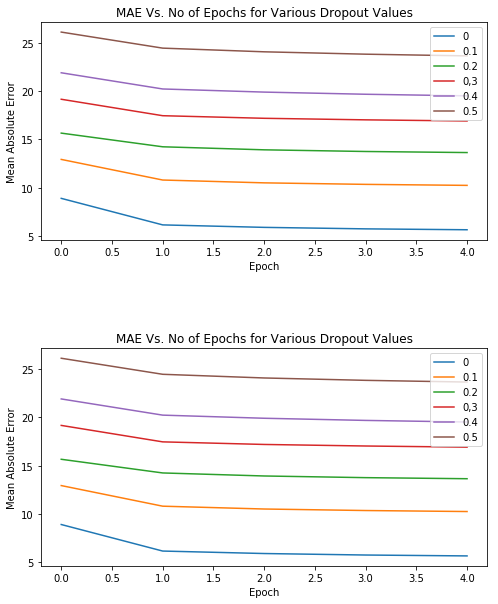

In [14]:
import matplotlib.pyplot as plt
def plot_history(history, history2, history3, history4, history5, history6, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    axes[0].plot(history.history[metric])
    axes[0].plot(history2.history[metric])
    axes[0].plot(history3.history[metric])
    axes[0].plot(history4.history[metric])
    axes[0].plot(history5.history[metric])
    axes[0].plot(history6.history[metric])
    try:
      #axes[0].plot(history.history['val_'+metric])
      #axes[0].plot(history2.history['val2_'+metric])
      #axes[0].plot(history3.history['val3_'+metric])
      axes[0].legend(['0', '0.1', '0.2', '0,3', '0.4', '0.5'], loc='upper right')
    except:
      pass
    axes[0].set_title('MAE Vs. No of Epochs for Various Dropout Values')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    axes[1].plot(history2.history['loss'])
    axes[1].plot(history3.history['loss'])
    axes[1].plot(history4.history['loss'])
    axes[1].plot(history5.history['loss'])
    axes[1].plot(history6.history['loss'])
    try:
      #axes[1].plot(history.history['val_loss'])
      axes[1].legend(['0', '0.1', '0.2', '0,3', '0.4', '0.5'], loc='upper right')
    except:
      pass
    axes[1].set_title('MAE Vs. No of Epochs for Various Dropout Values')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_history(denoise_history_adam_do, denoise_history_adam_do1, denoise_history_adam_do2, denoise_history_adam_do3, denoise_history_adam_do4, denoise_history_adam_do5, 'mean_absolute_error')

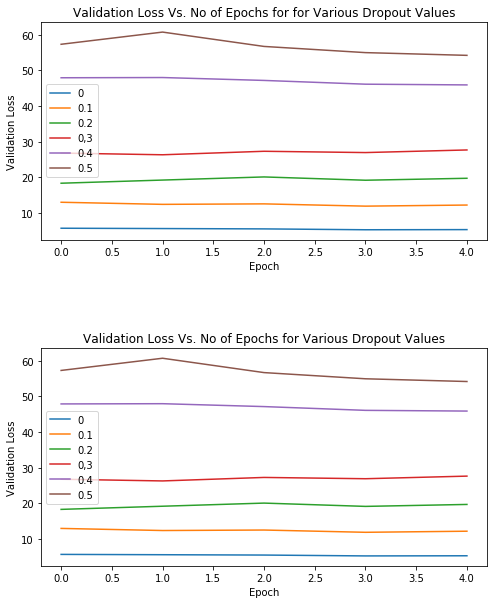

In [15]:
def plot_val_history(history, history2, history3, history4, history5, history6, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].plot(history2.history['val_'+metric])
      axes[0].plot(history3.history['val_'+metric])
      axes[0].plot(history4.history['val_'+metric])
      axes[0].plot(history5.history['val_'+metric])
      axes[0].plot(history6.history['val_'+metric])
      axes[0].legend(['0', '0.1', '0.2', '0,3', '0.4', '0.5'], loc='best')

    except:
      pass
    axes[0].set_title('Validation Loss Vs. No of Epochs for for Various Dropout Values')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    #axes[1].plot(history.history['loss'])
    #axes[1].plot(history2.history['loss'])
    #axes[1].plot(history3.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].plot(history2.history['val_loss'])
      axes[1].plot(history3.history['val_loss'])
      axes[1].plot(history4.history['val_loss'])
      axes[1].plot(history5.history['val_loss'])
      axes[1].plot(history6.history['val_loss'])
      axes[1].legend(['0', '0.1', '0.2', '0,3', '0.4', '0.5'], loc='best')

    except:
      pass
    axes[1].set_title('Validation Loss Vs. No of Epochs for Various Dropout Values')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_val_history(denoise_history_adam_do, denoise_history_adam_do1, denoise_history_adam_do2, denoise_history_adam_do3, denoise_history_adam_do4, denoise_history_adam_do5, 'mean_absolute_error')

## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

**Updated explanation**: Due to the way Keras handles the compile method, it needs a loss as an argument in that compile method. However, our loss is computed in the lambda layer, so we want to minimize the output of that layer. As we want to minimize the output of the Lambda function (in this case the triplet loss), we output as the label in the training_generator a vector of zeros and we compute the mean absolute error of the triplet loss and this vector of zeros. To give you an intuition, what we aim to minimize is
$$  |\text{triplet_loss} - 0| =  |\text{triplet_loss}| = \text{triplet_loss} $$



In [ ]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Here we use the class HPatches, which loads the corresponding files by using the method `read_image_file`. It reads the patches. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class `DataGeneratorDesc`. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

**Updated**: In the previous version of the baseline code, we were training the descriptor model with the noisy patches, not with the denoised ones. By adding the argument `denoise_model=denoise_model` to the class HPatches we can use the denoised images instead to train this descriptor model (if `denoise_model=None`, the noisy patches will be used). However, as it has to compute the denoised patch first, the loading of the data will be slower (6/7 extra min).  If you want to train the model with the clean patches instead, you can set the argument `use_clean=True`. In this last case, even if a denoise model is given, it will not be used. When running this piece of code **the type of patches (denoised, noisy or clean) used is printed**.

In [ ]:
### Descriptor loading and training
# Loading images
hPatches_adam = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adam, use_clean=False)
hPatches_adam_amsgrad = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adam_amsgrad, use_clean=False)
hPatches_sgd = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_sgd, use_clean=False)
hPatches_adadelta = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adadelta, use_clean=False)
hPatches_nadam = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_nadam, use_clean=False)

# Creating training generator
training_generator_adam = DataGeneratorDesc(*hPatches_adam.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adam = DataGeneratorDesc(*hPatches_adam.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_adam_amsgrad = DataGeneratorDesc(*hPatches_adam_amsgrad.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adam_amsgrad = DataGeneratorDesc(*hPatches_adam_amsgrad.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_sgd = DataGeneratorDesc(*hPatches_sgd.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_sgd = DataGeneratorDesc(*hPatches_sgd.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_adadelta = DataGeneratorDesc(*hPatches_adadelta.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adadelta = DataGeneratorDesc(*hPatches_adadelta.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_nadam = DataGeneratorDesc(*hPatches_nadam.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_nadam = DataGeneratorDesc(*hPatches_nadam.read_image_file(hpatches_dir, train=0), num_triplets=10000)

We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

In [ ]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [ ]:
#epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

#for e in range(epochs):
  
descriptor_history_adam = descriptor_model_trip.fit_generator(generator=training_generator_adam, epochs=5, verbose=1, validation_data=val_generator_adam)
descriptor_model_trip.save('descriptor_adam.h5') 

descriptor_history_adam_amsgrad = descriptor_model_trip.fit_generator(generator=training_generator_adam_amsgrad, epochs=5, verbose=1, validation_data=val_generator_adam_amsgrad)
descriptor_model_trip.save('descriptor_adam_amsgrad.h5') 

descriptor_history_sgd = descriptor_model_trip.fit_generator(generator=training_generator_sgd, epochs=5, verbose=1, validation_data=val_generator_sgd)
descriptor_model_trip.save('descriptor_sgd.h5') 

descriptor_history_adadelta = descriptor_model_trip.fit_generator(generator=training_generator_adadelta, epochs=5, verbose=1, validation_data=val_generator_adadelta)
descriptor_model_trip.save('descriptor_adadelta.h5') 

descriptor_history_nadam = descriptor_model_trip.fit_generator(generator=training_generator_nadam, epochs=5, verbose=1, validation_data=val_generator_nadam)
descriptor_model_trip.save('descriptor_nadam.h5') 

### Saves optimizer and weights
#descriptor_model_trip.save('descriptor.h5') 
### Uploads files to external hosting
#!curl -F "file=@descriptor.h5" https://file.io


## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [ ]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adam, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adam_amsgrad, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_sgd, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adadelta, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_, use_clean=False)


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification


### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching


### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [ ]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [ ]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')